# Puzzled Pint 

In this notebook, we scrape a website for data about Puzzled Pint events, and collect information about these events. 

## 1. Get the data

We import the data from the website https://paranoiq.cz/calc/puzzled-pint/data into a local file, then use Beautiful Soup to process the fill, and identify the (single) table. 

In [1]:
import requests

url = "https://paranoiq.cz/calc/puzzled-pint/data"
page = requests.get(url).text
with open('puzzled_pint_statistics.html', 'w') as f:
    f.write(page)

In [2]:
from bs4 import BeautifulSoup 

with open('puzzled_pint_statistics.html') as f:
    text = f.read()
soup = BeautifulSoup(text, "html5lib")

table = soup.find('table')  ## There is a single table
all_rows = table.find_all('tr')

## 2. Build the header

Next we build the header in terms of year and month. The first row in the table lists the years, while the second lists the months. We print the length of the header

In [3]:
years, months = all_rows[:2]           

## Years contain multiple months, as indicated by the colspan
years_header = []
for items in years('th'):
    if items.get_text() and items.get('colspan'):
        years_header.extend([int(items.get_text())]* int(items.get('colspan')))
        
## Only one month per column        
months_header = [items.get_text().strip() for items in months('th')[1:] if items.get_text()]

## Zip years (with multiplicity) and months
header = list(zip(months_header, years_header))

## Store the total number of header items as a variable
len_header = len(header)
print(len_header)

123


## 3. Auxilliary functions

We need to define some auxilliary functions in order to process the entries of the table later on. The first involves converting dashes to zeros and strings to integers, while the second removes trailing zeros from a list of integers. 

In [4]:
def process_num(s: str):
    if s == '-': 
        return 0
    else:
        try:
            return int(s)
        except:
            return s

In [5]:
from typing import List

def remove_trailing_zeros(items: List[int]) -> List:
    if items == []:
        return "This is the zero list"
    elif items[-1] == 0:
        return remove_trailing_zeros(items[:-1])
    else: 
        return items

## 4. Location class

The Location class will capture the data for each location. It is a NamedTuple. 

In [6]:
from typing import NamedTuple, Tuple

class Location(NamedTuple):
    name: str
    start_date: Tuple[str]
    team_data: List[int]
        
    def creat_dir(self) -> None:
        dirName = 'locations/' + self.name
        try:
            # Create target Directory
            os.mkdir(dirName)
            #print("Directory " , dirName ,  " Created ") 
        except FileExistsError:
            print("Directory " , dirName ,  " already exists")
        
        
    def graph(self)-> None:
        ys = [v for v in self.team_data]
        ys.reverse()
        len_ys, m = len(ys), max(ys)

        f, ax = plt.subplots(1, figsize=(min(36,len_ys+4), min(m, 10)))
        ax.plot(ys)
        ax.grid(True)

        if len_ys < 36:
            labels = [ str(h[0])+ str(h[1]) for h in header[:len_ys]]
            labels.reverse()
            plt.xticks(list(range(len_ys)),labels )
        else:
            _xticks=[[],[]]
            for j in range(len(ys)-1,0, -1):
                if header[j][0] == 'Jan':
                    _xticks[0].append(len(ys) - j +1)
                    _xticks[1].append('Jan ' +  str(header[j][1]))
            _xticks[0].append(0)
            _xticks[1].append(str(header[len_ys-1][0]) + str(header[len_ys-1][1]))
            plt.xticks(_xticks[0], _xticks[1])

        if m > 20:
            plt.yticks(list(range(0, m+2, 5)))
        else:
            plt.yticks(list(range(0, m+2, 1)))

        plt.title(self.name)
        plt.ylabel('Number of Teams')
        #plt.xlabel('Event')
        plt.axis([-1, len_ys , 0, m+2])
        plt.savefig('locations/' + str(self.name) + '/teams_over_time.png')
        #plt.show()

## 5. Process the data

We process the data by making a list that will contain all the location data. We go through the rows of the table and fill in this list. The length of this list is the number of locations, and is stored as a variable num_loc.

Then we create a directory and plot for each location.

In [7]:
all_loc_data: List[Location] = []

locations_rows = all_rows[2:]
for location in locations_rows:
    loc_raw_data =[process_num(r.get_text().strip()) for r in location.find_all('td')]
    loc_name = loc_raw_data[0] 
    loc_raw_data.pop(0)
    assert len(loc_raw_data) == len_header
    loc_raw_data = remove_trailing_zeros(loc_raw_data)
    loc_start_date = header[len(loc_raw_data)-1]
    all_loc_data.append(Location(loc_name, loc_start_date, loc_raw_data))

num_loc = len(all_loc_data)

<ipython-input-6-2c93a9f7fbe3>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots(1, figsize=(min(36,len_ys+4), min(m, 10)))


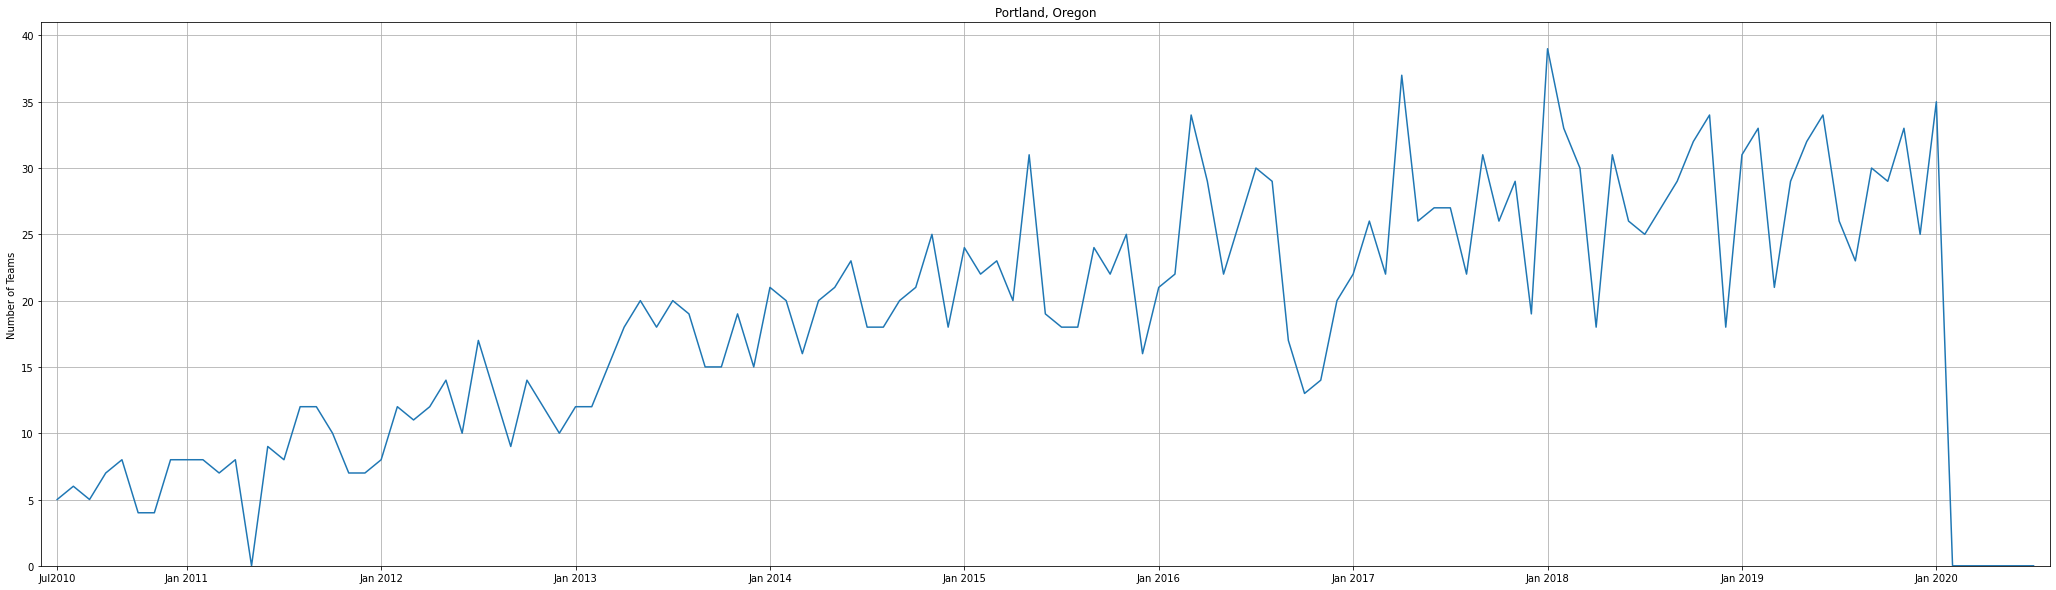

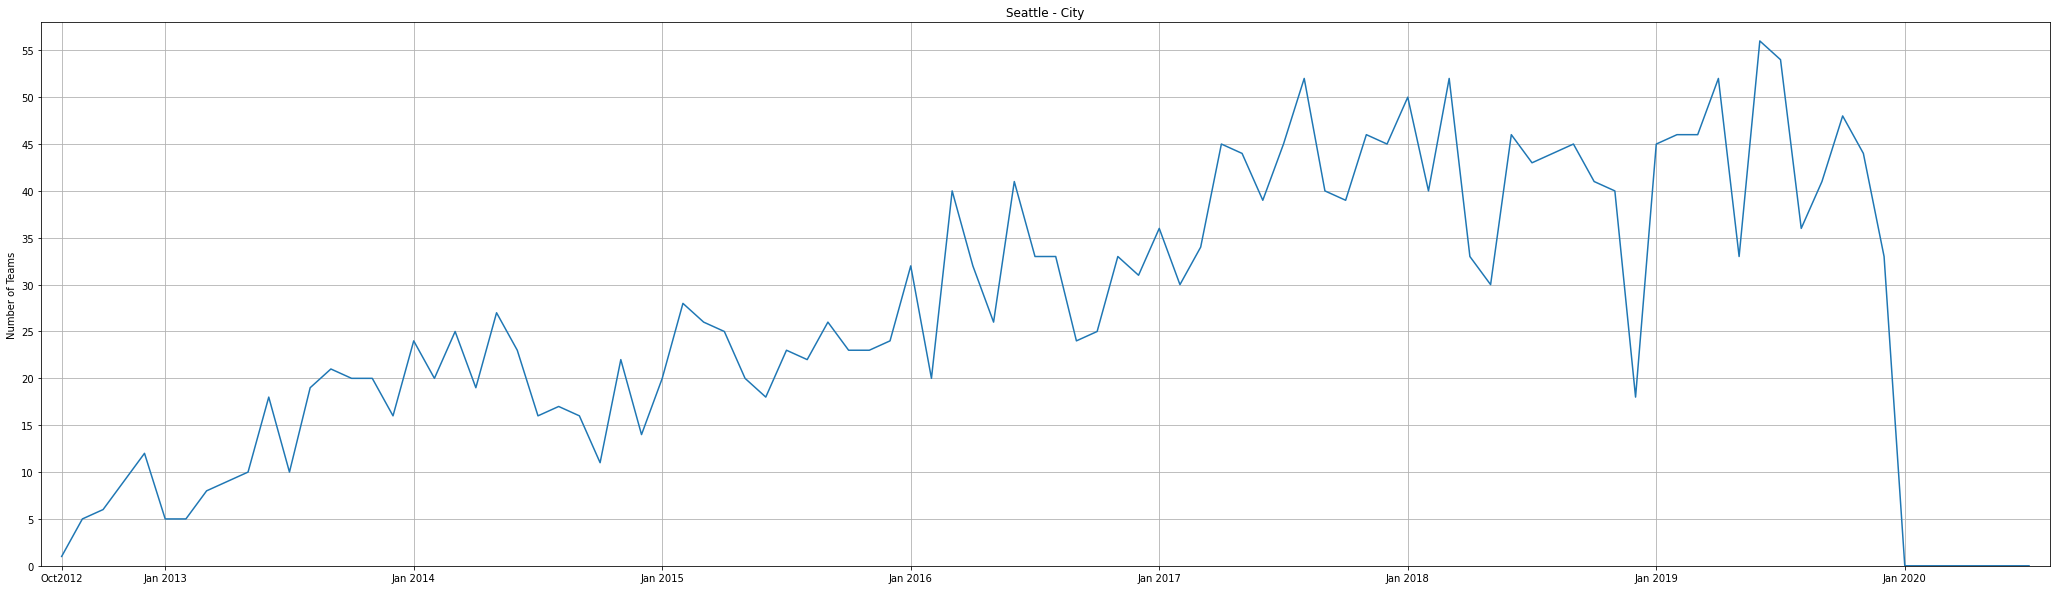

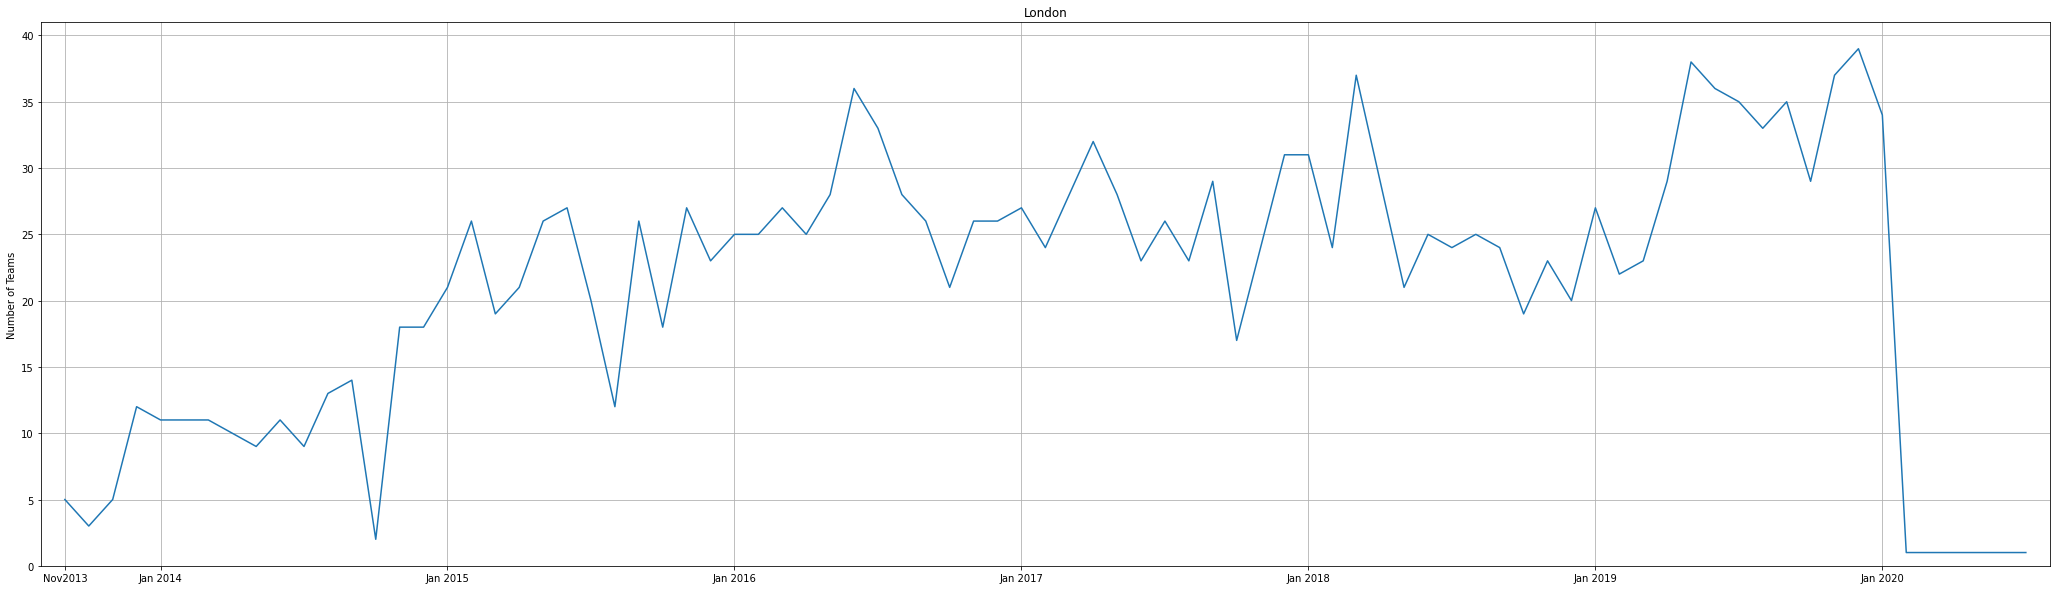

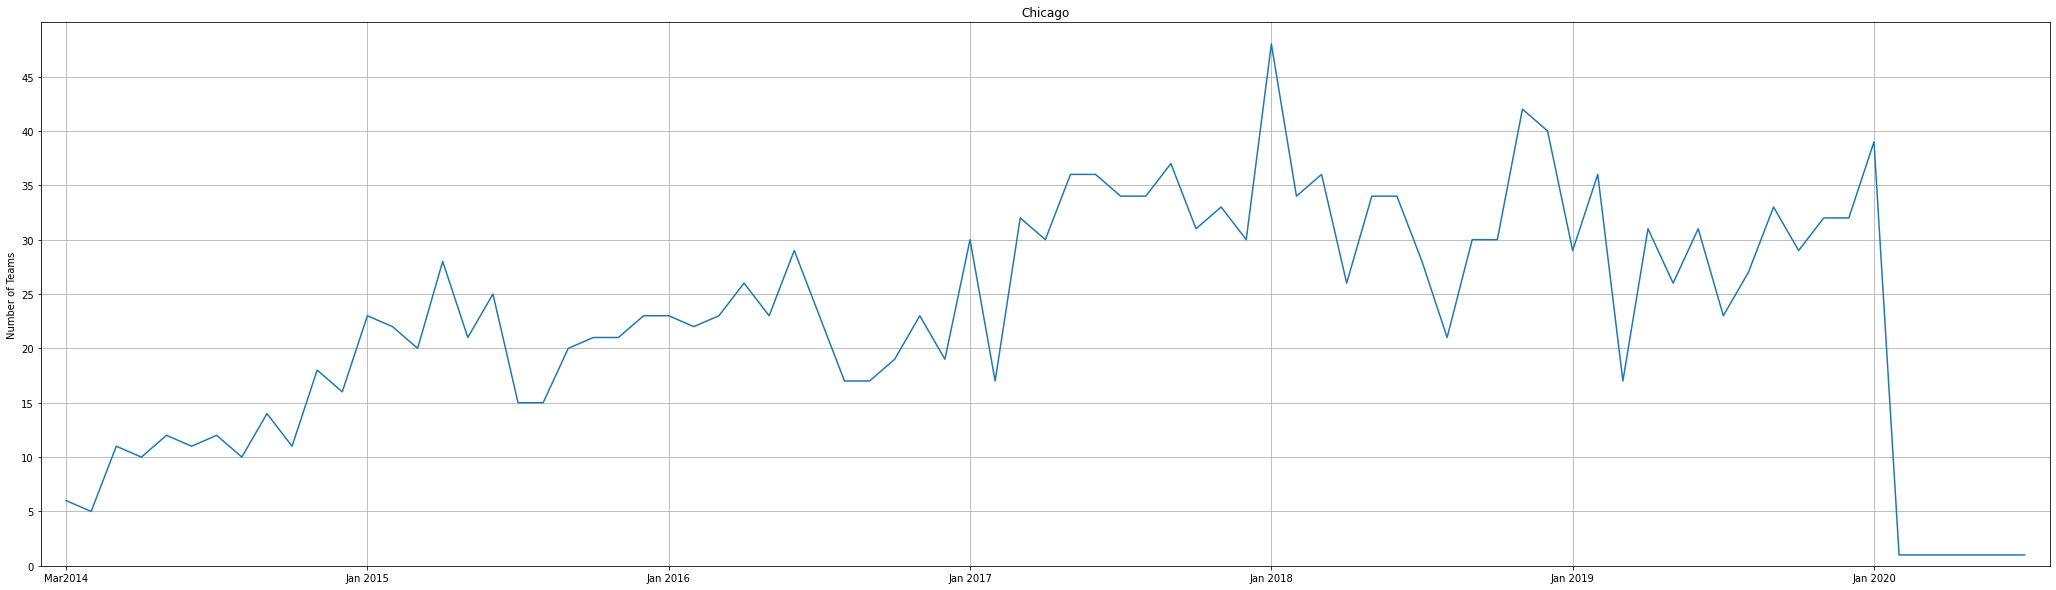

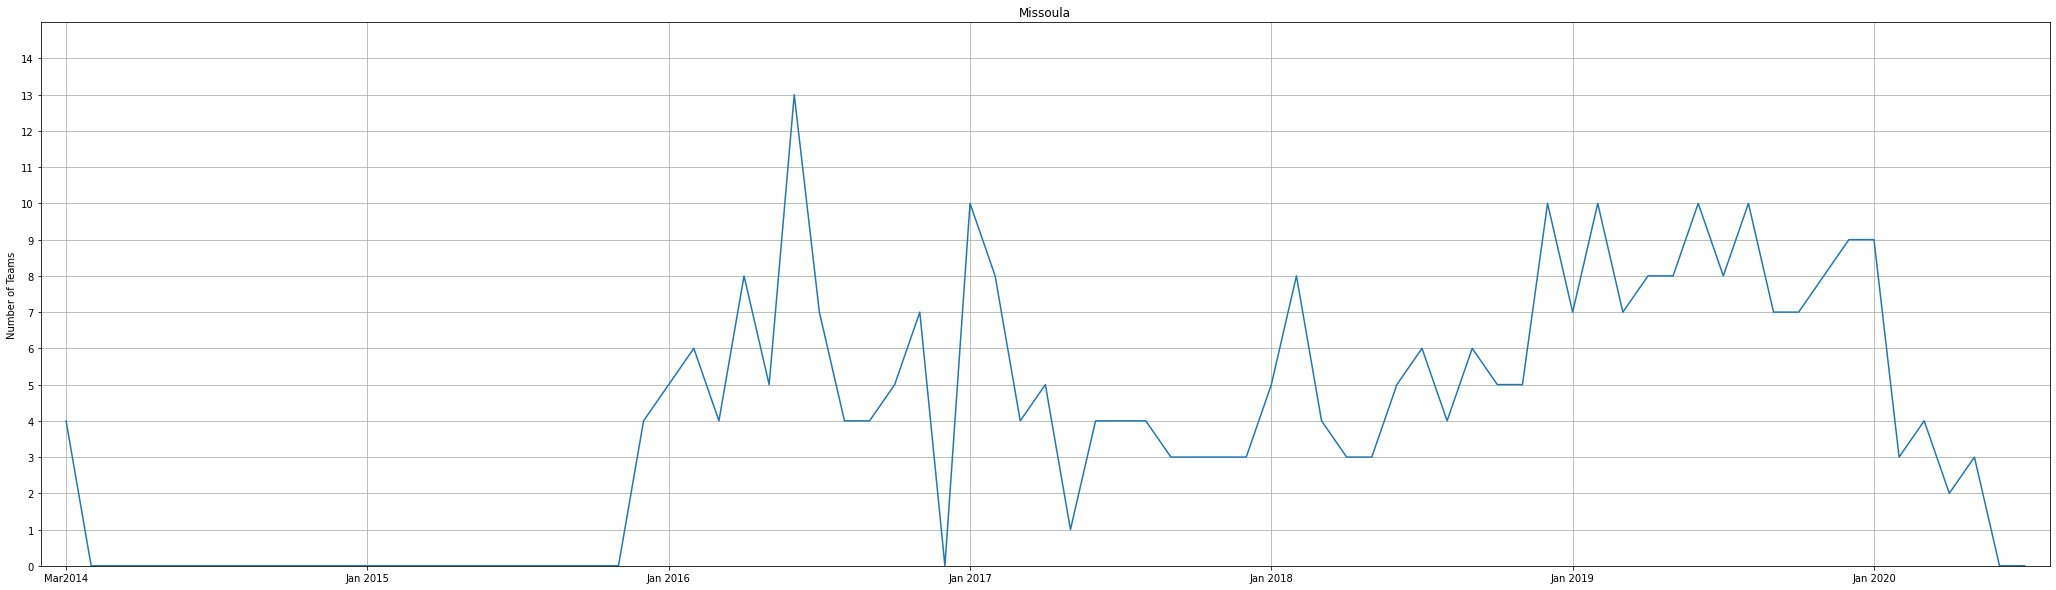

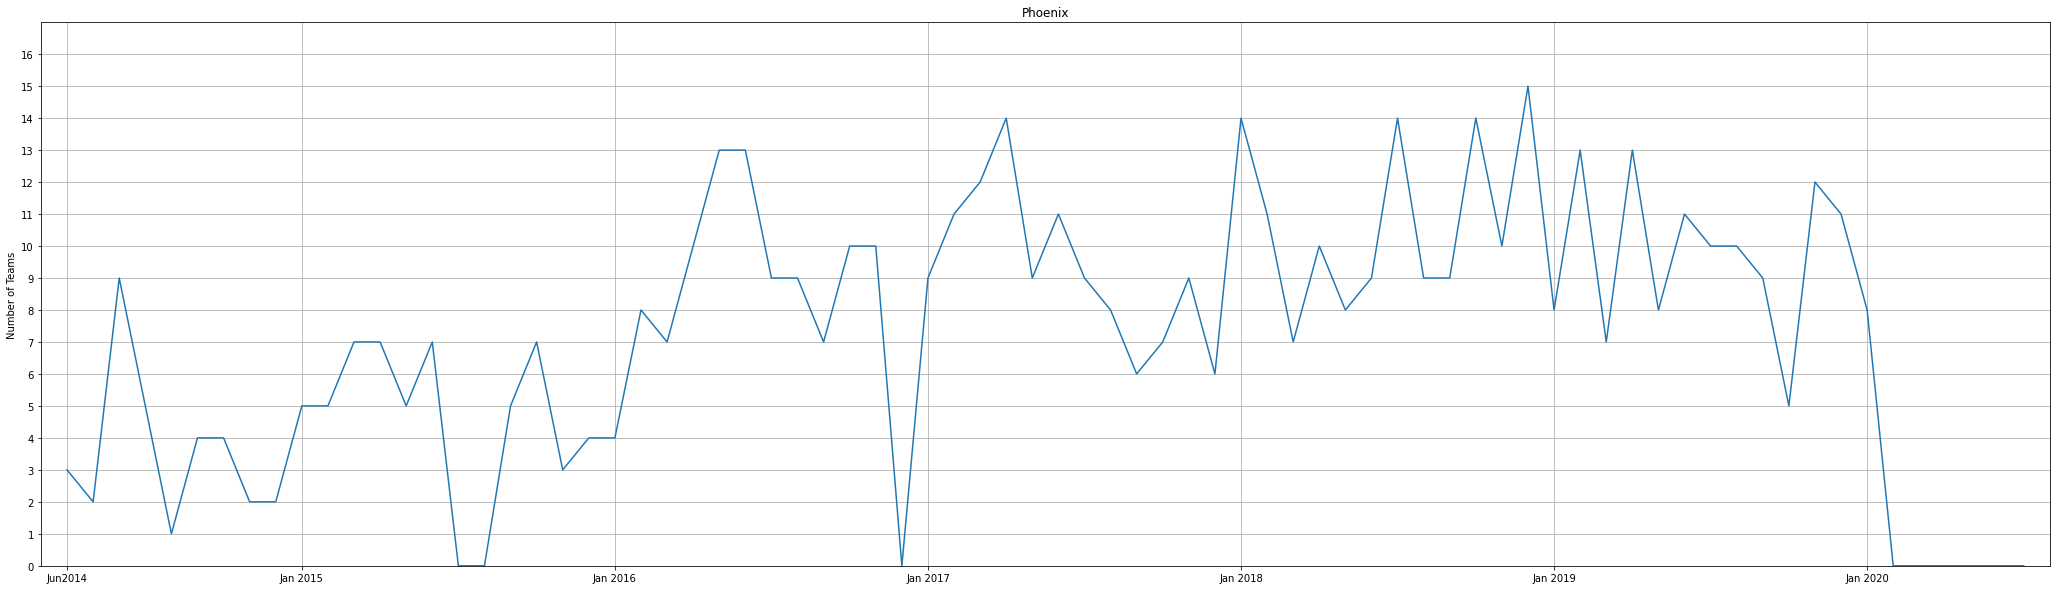

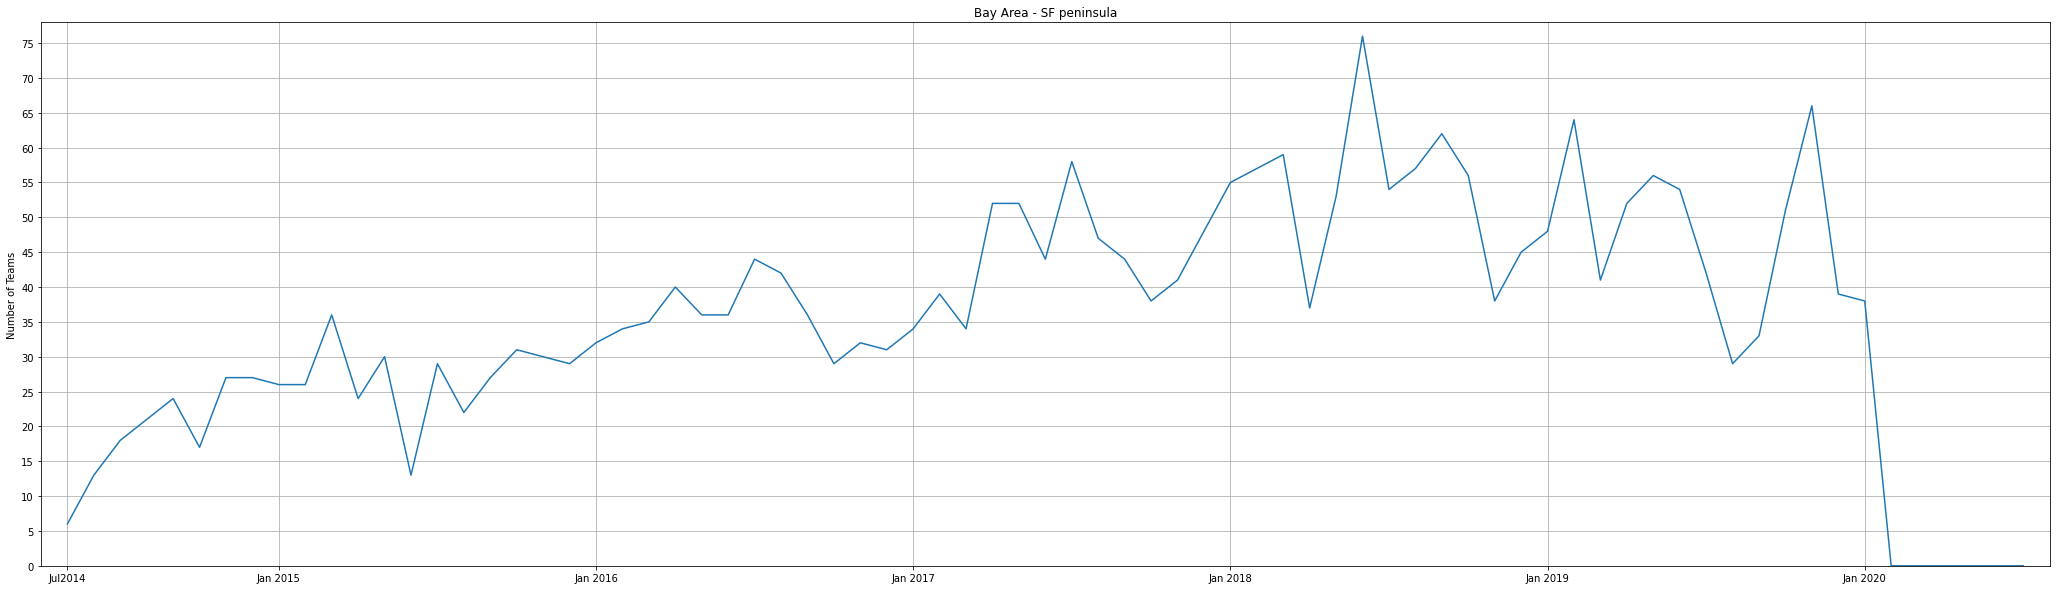

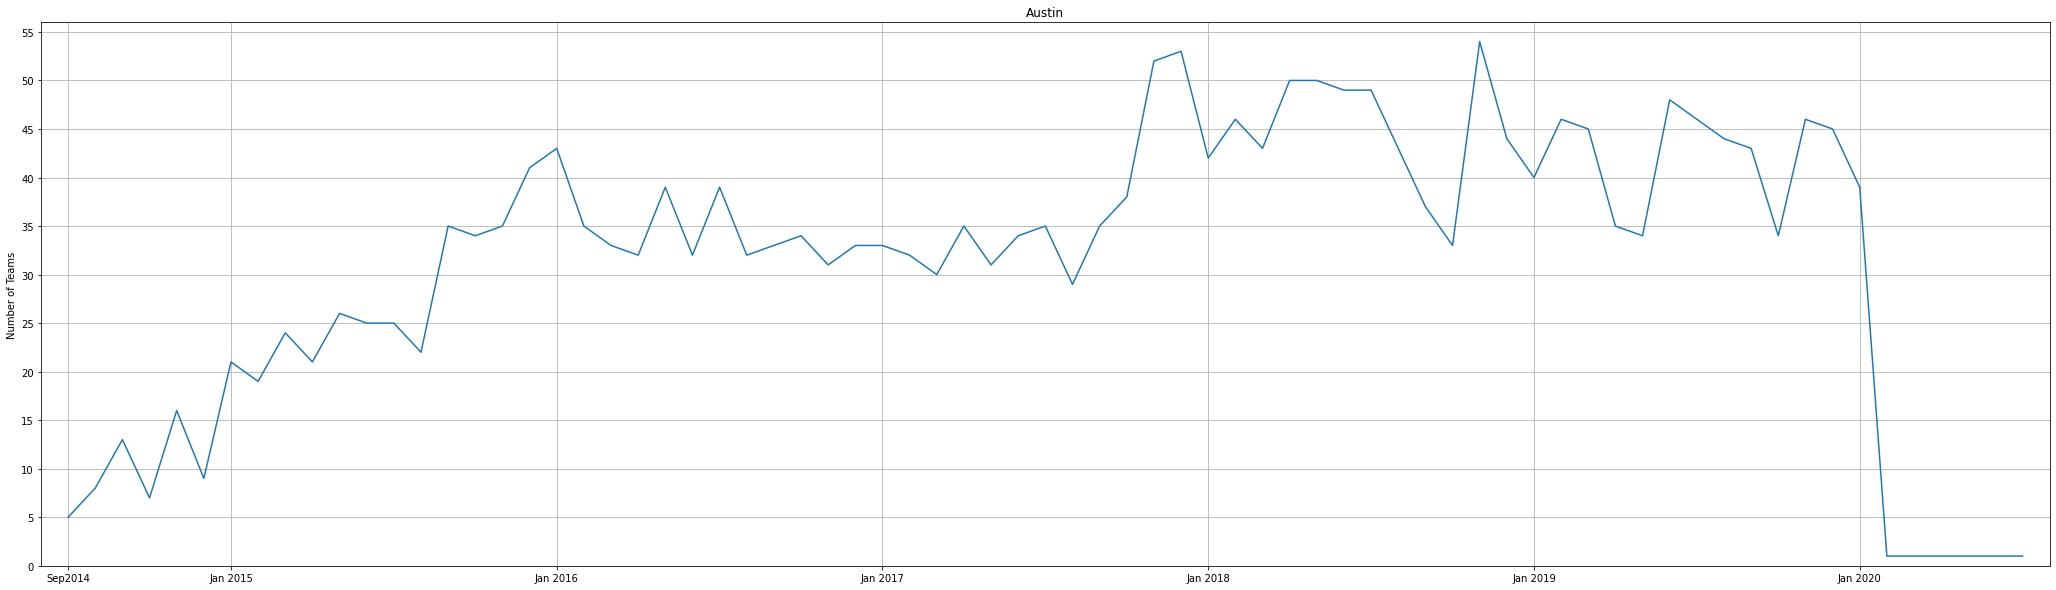

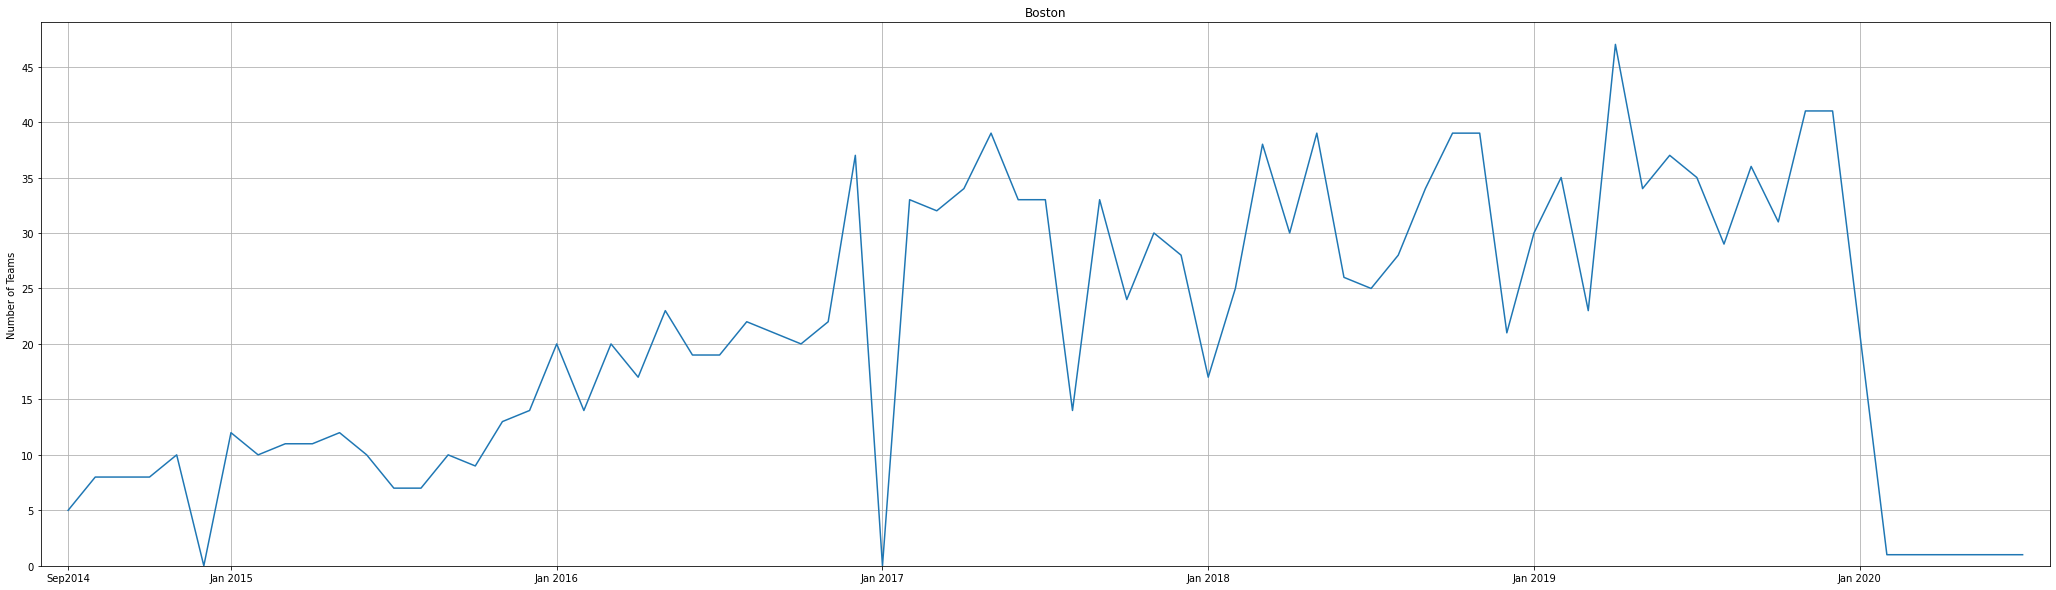

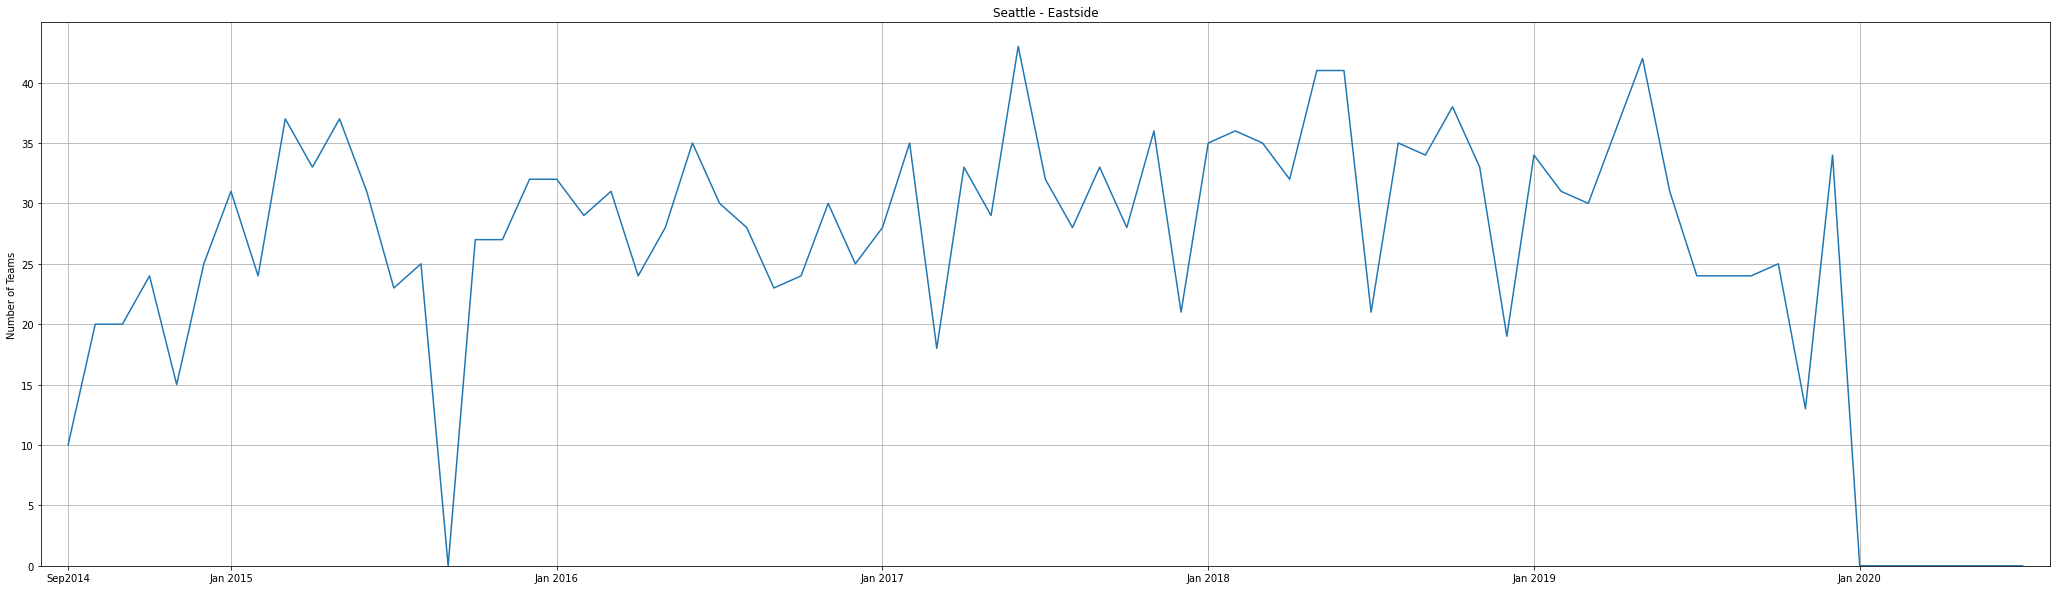

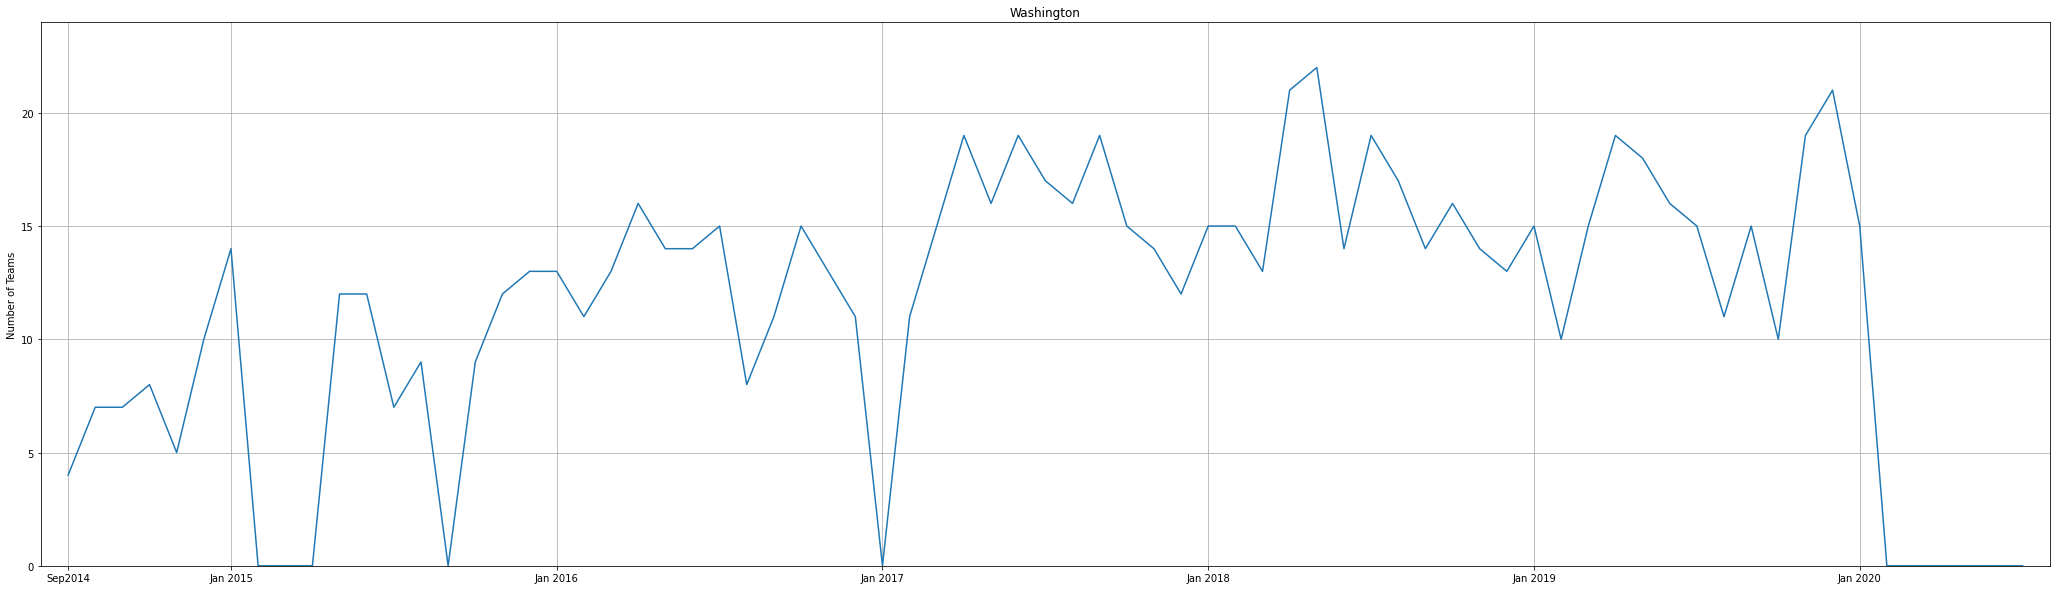

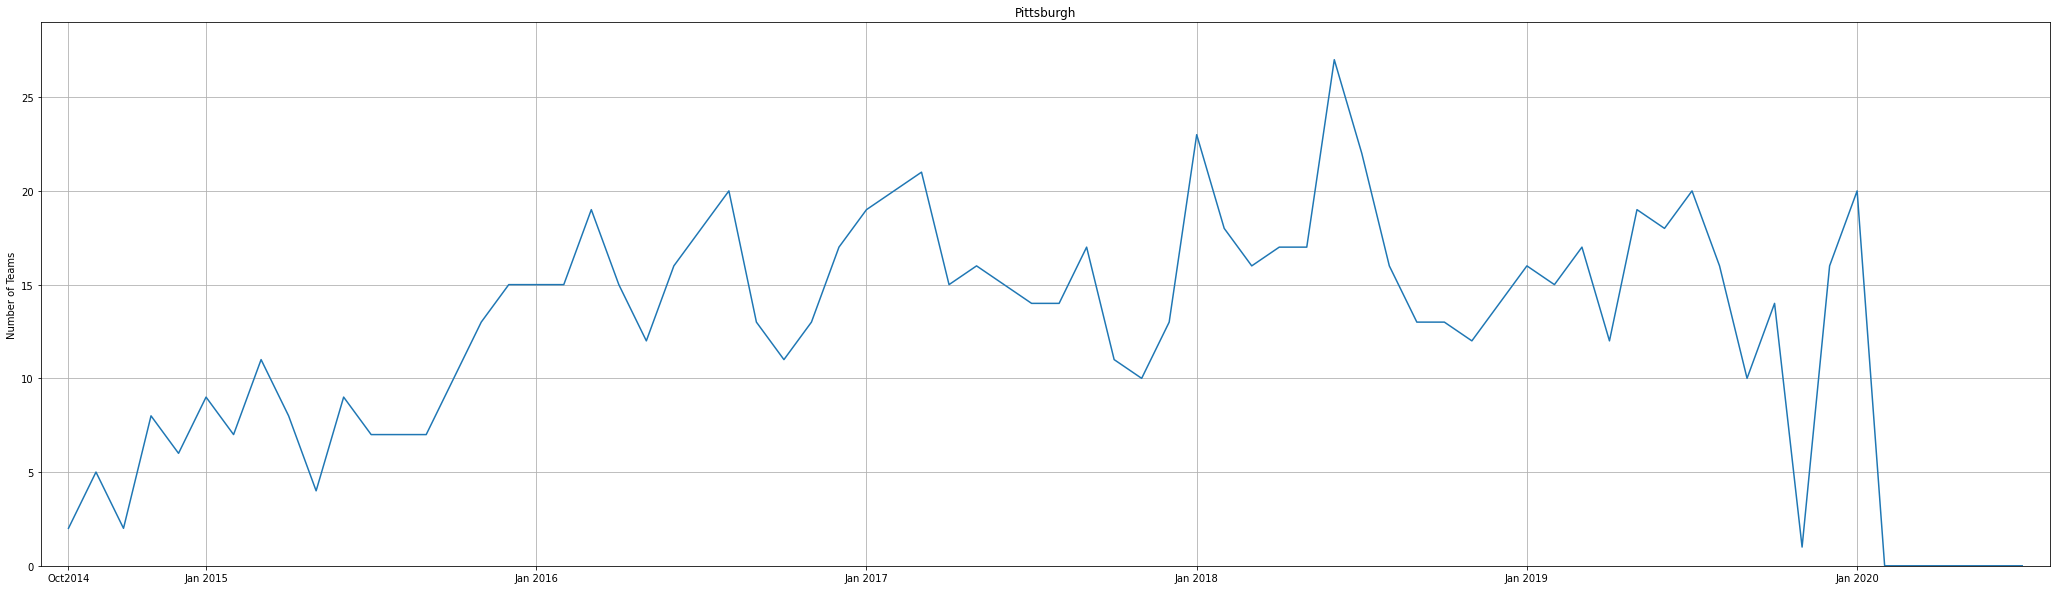

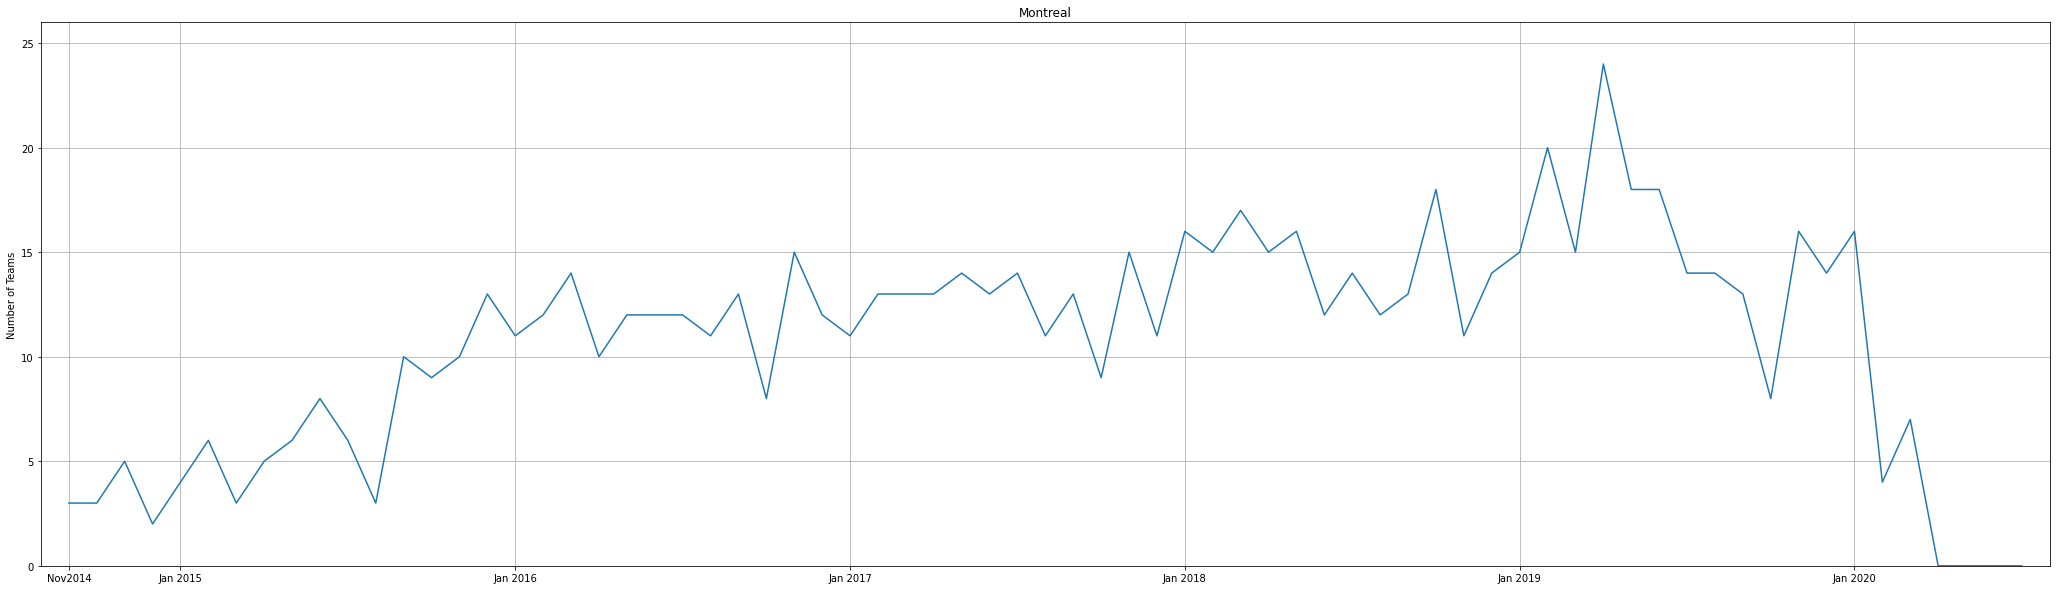

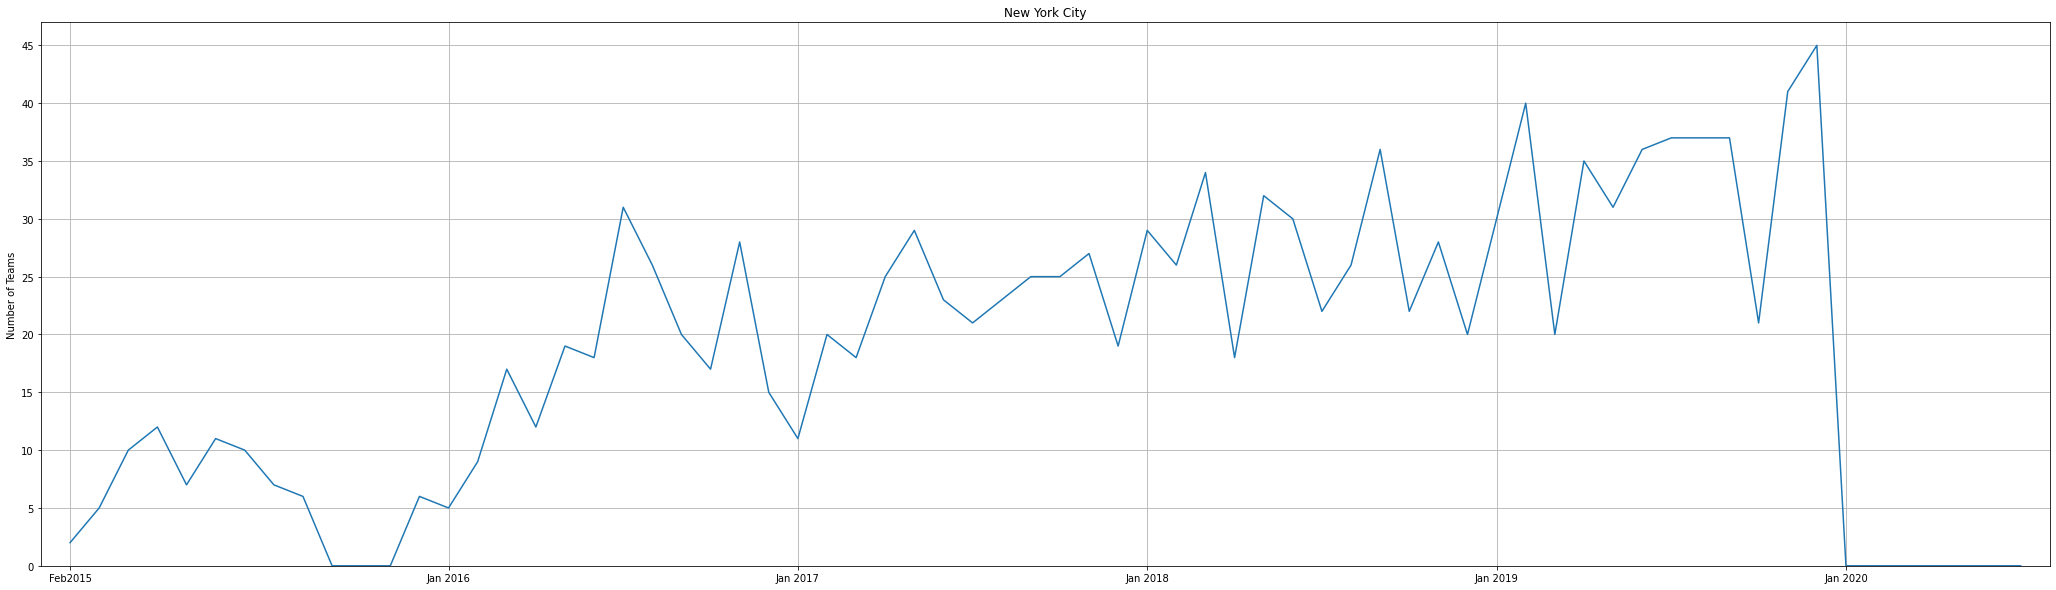

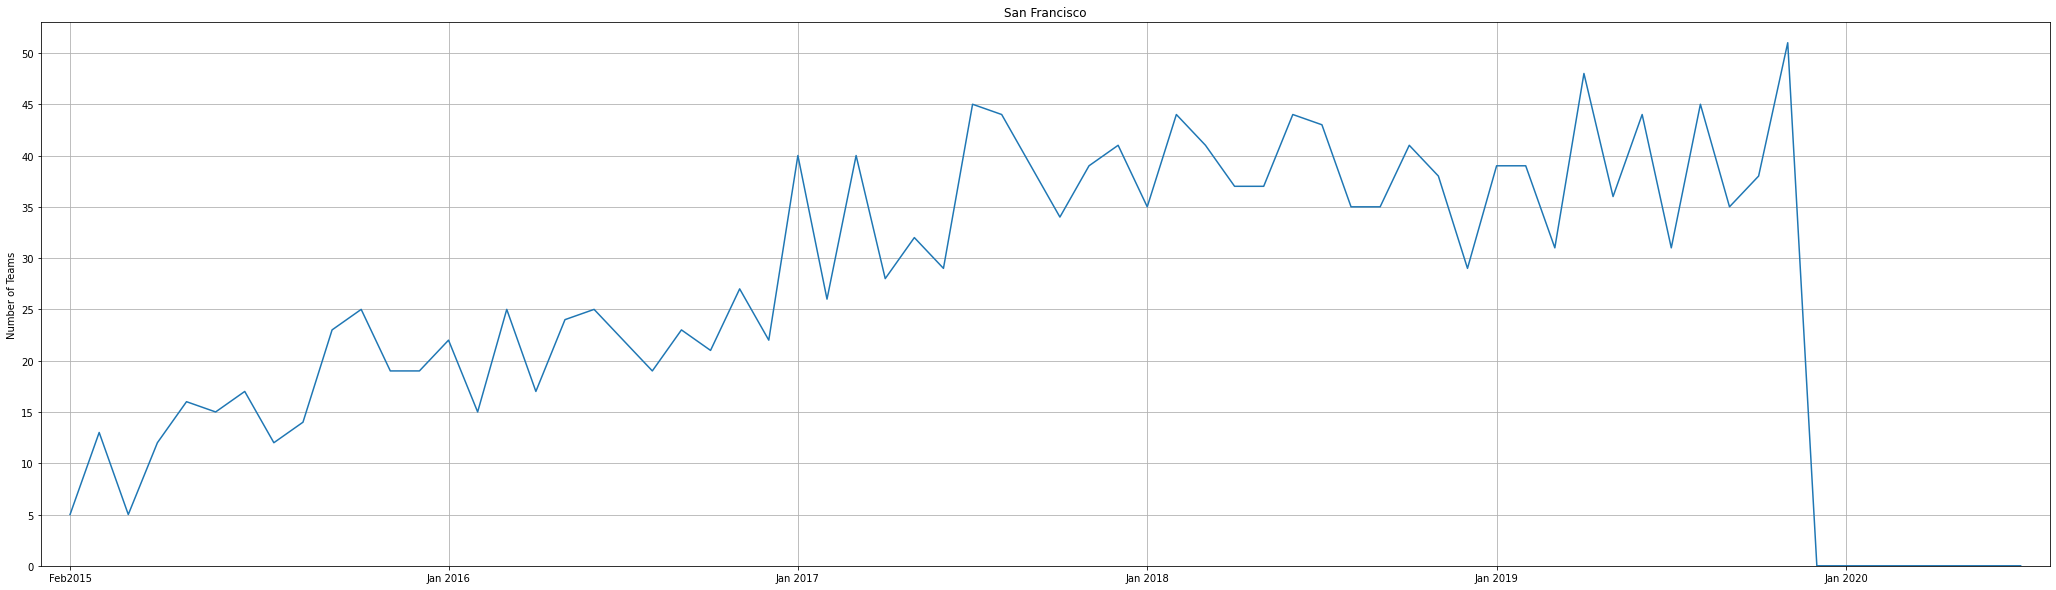

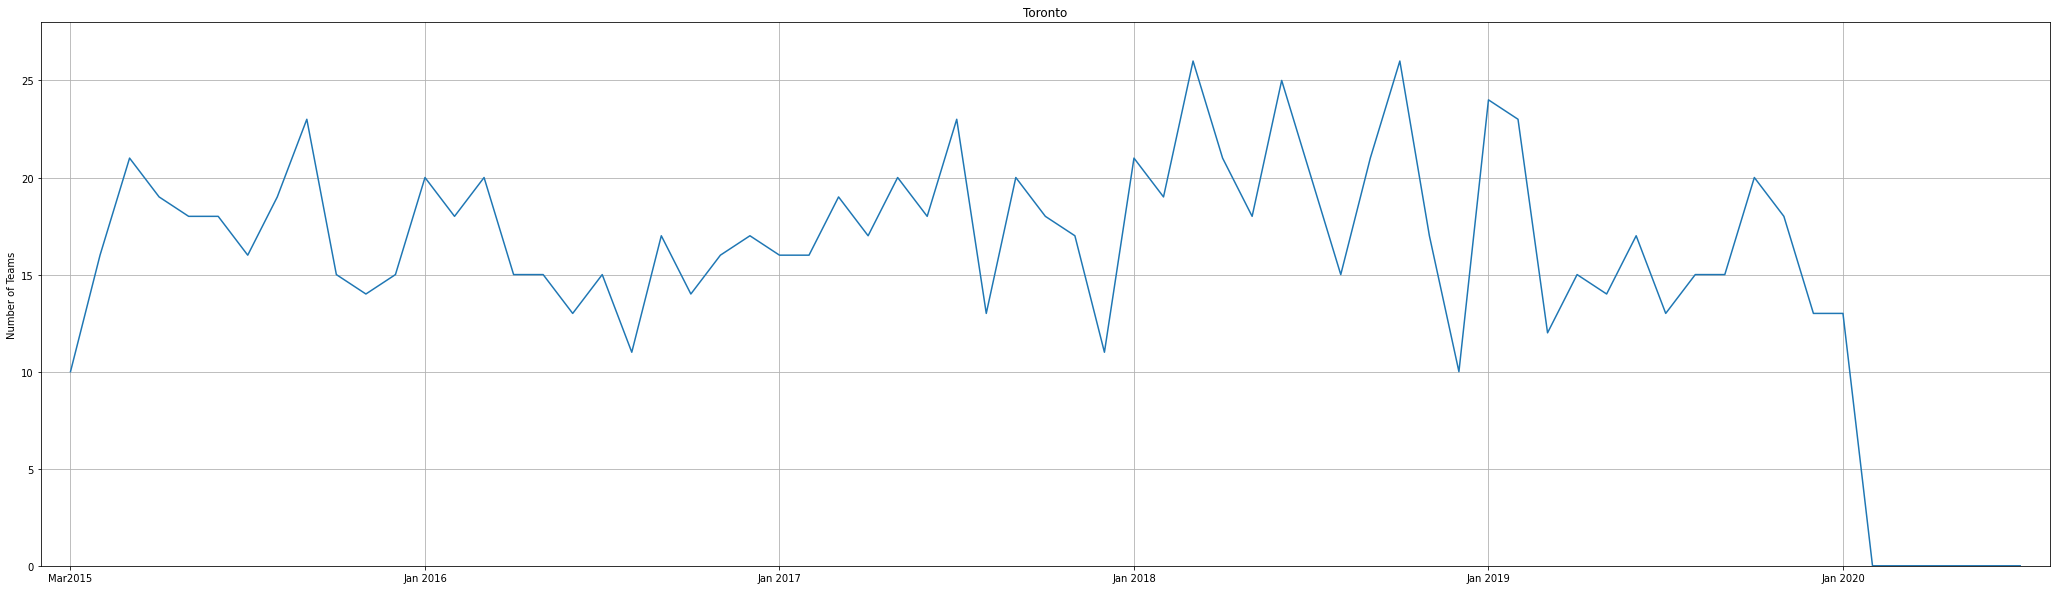

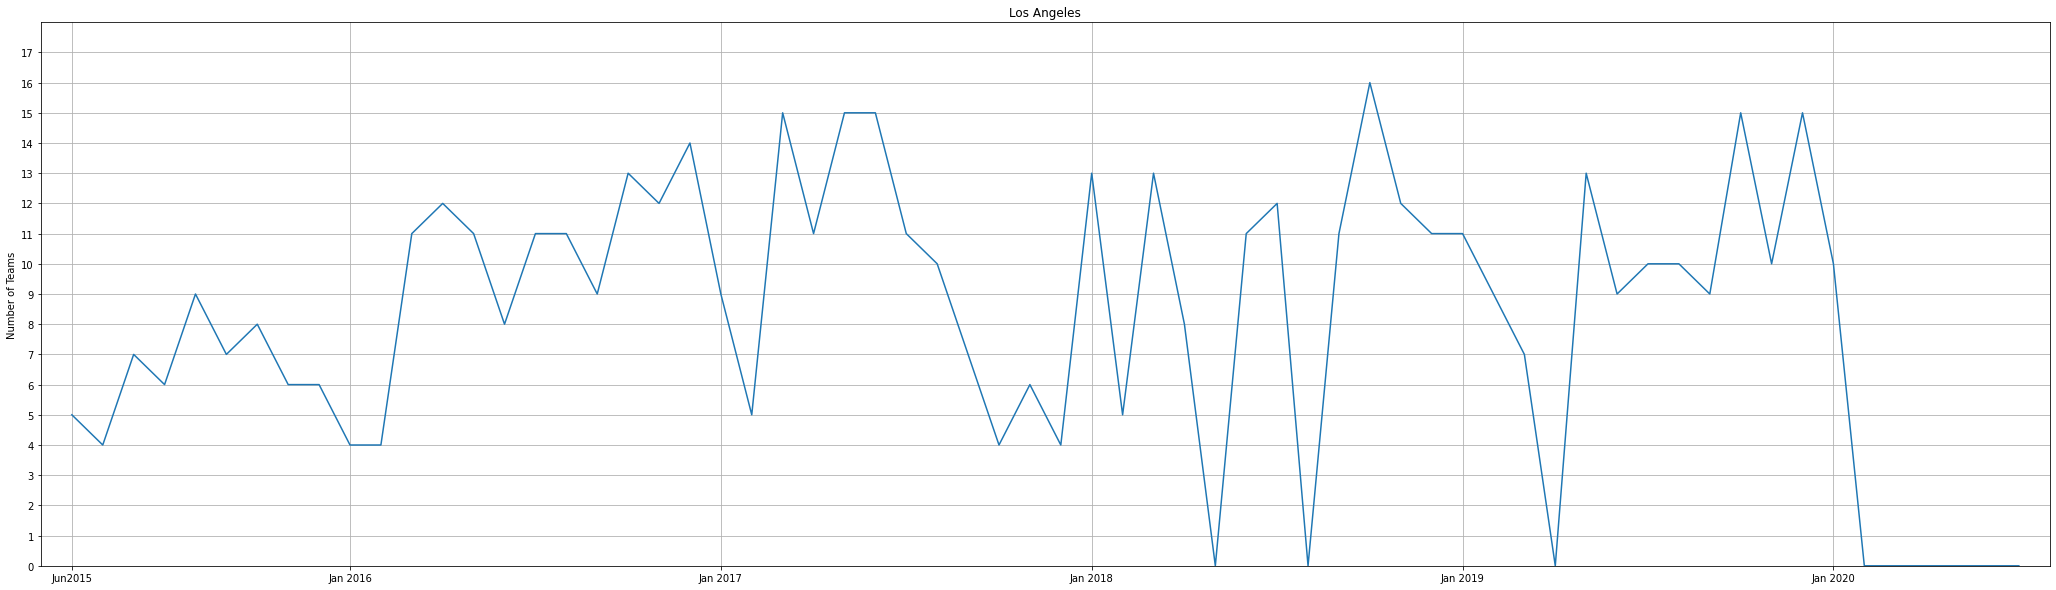

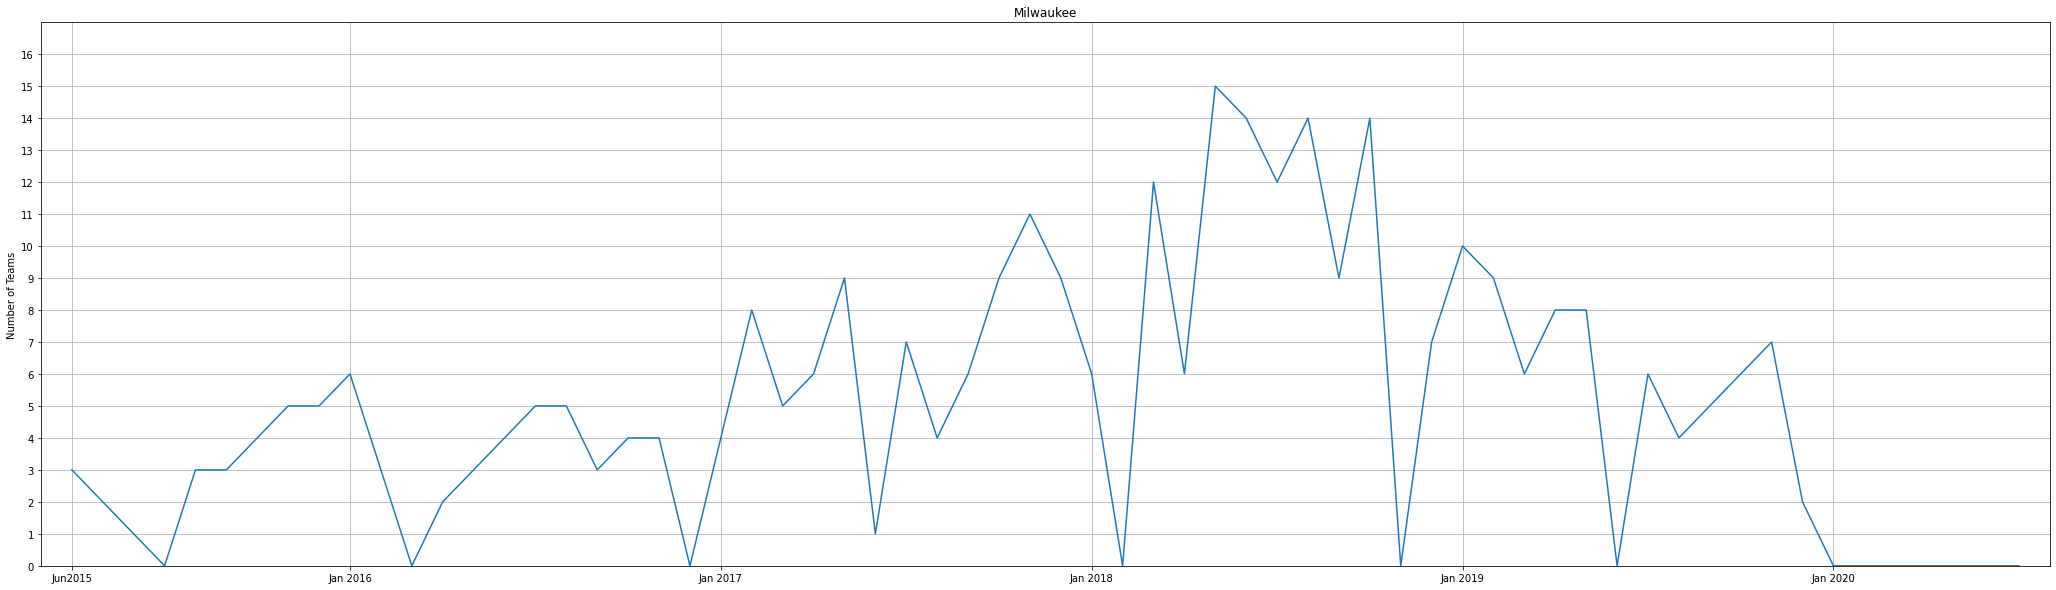

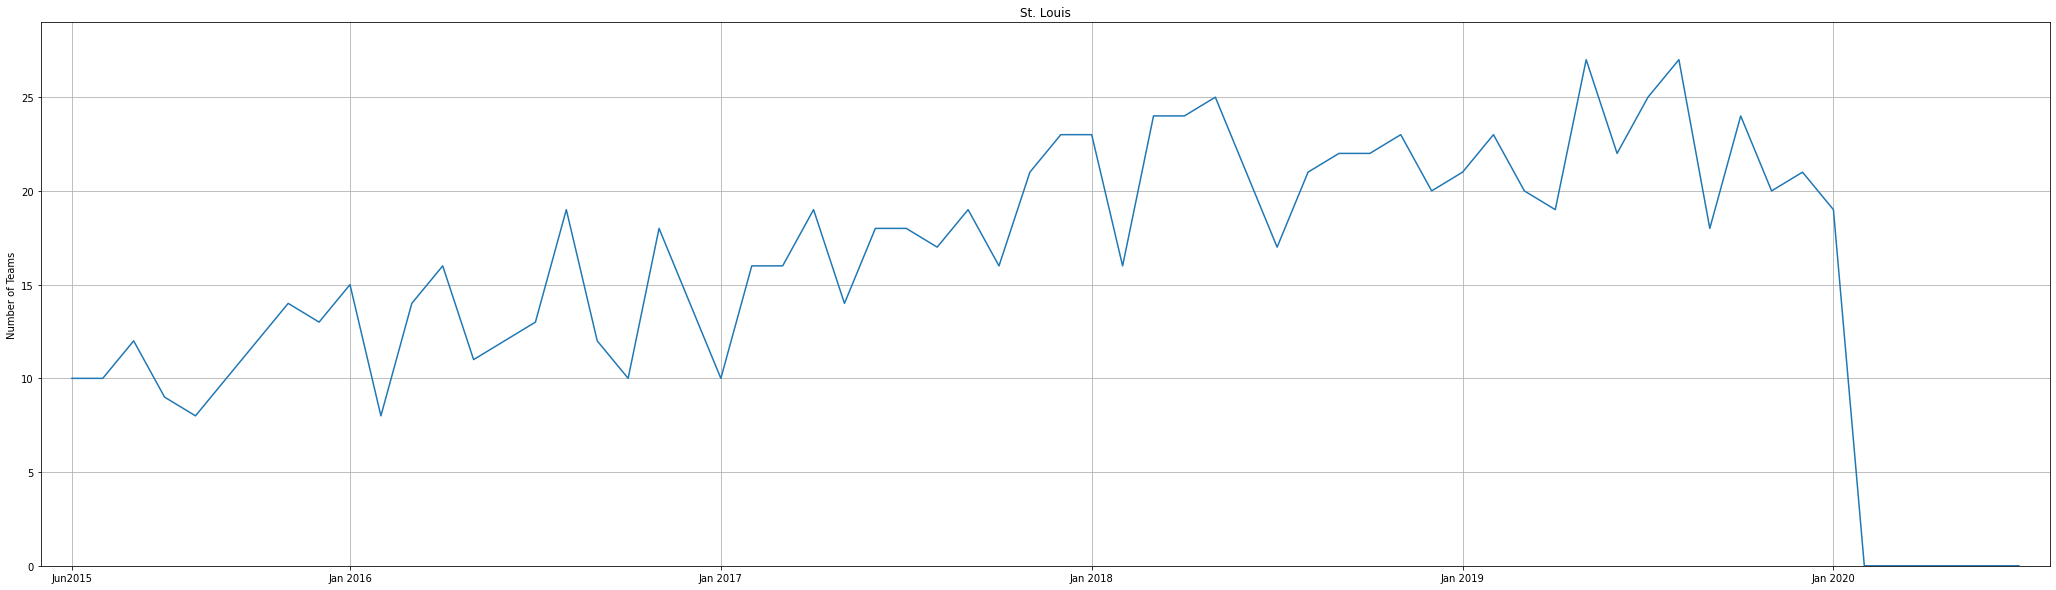

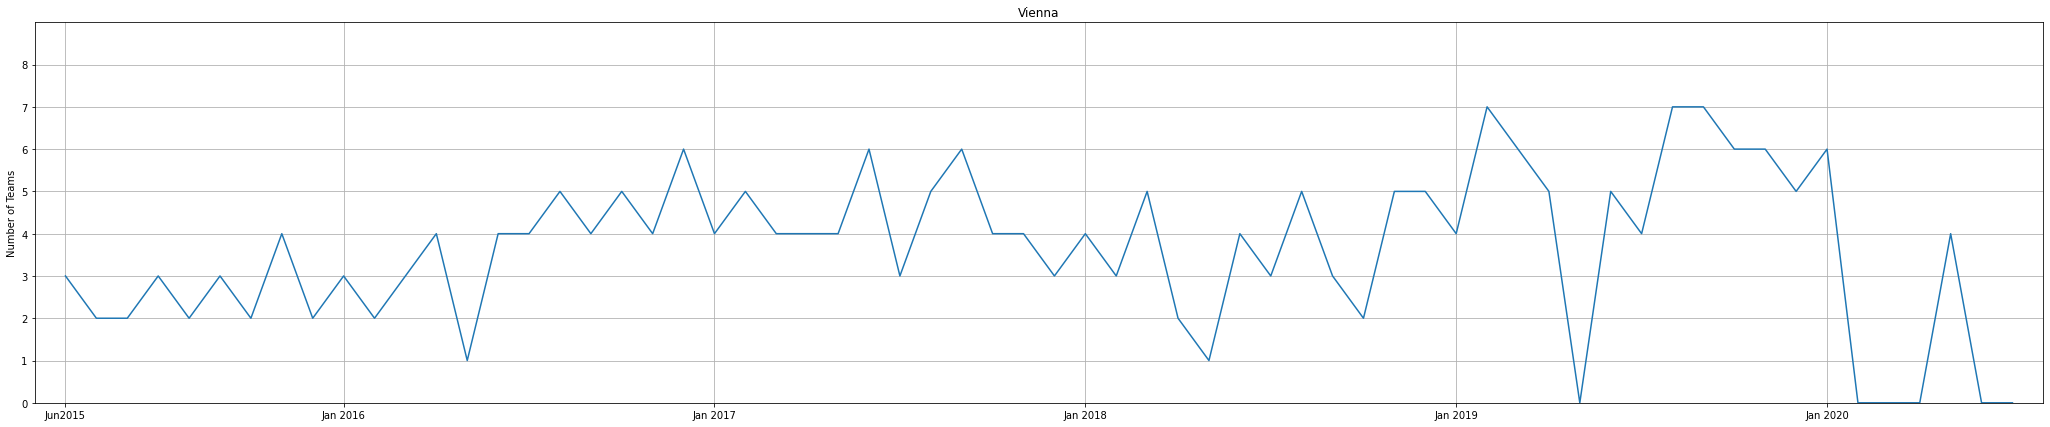

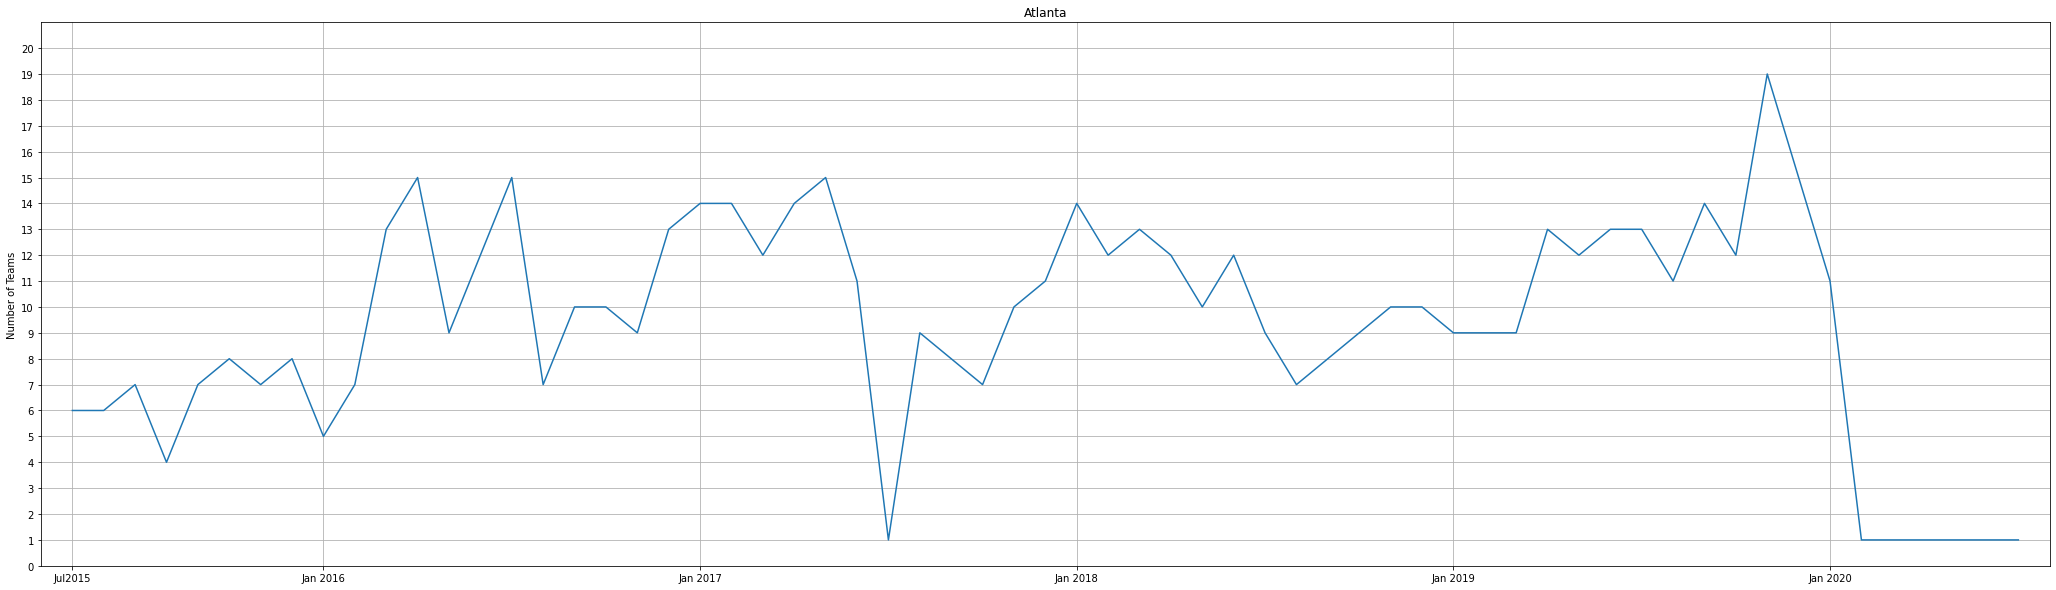

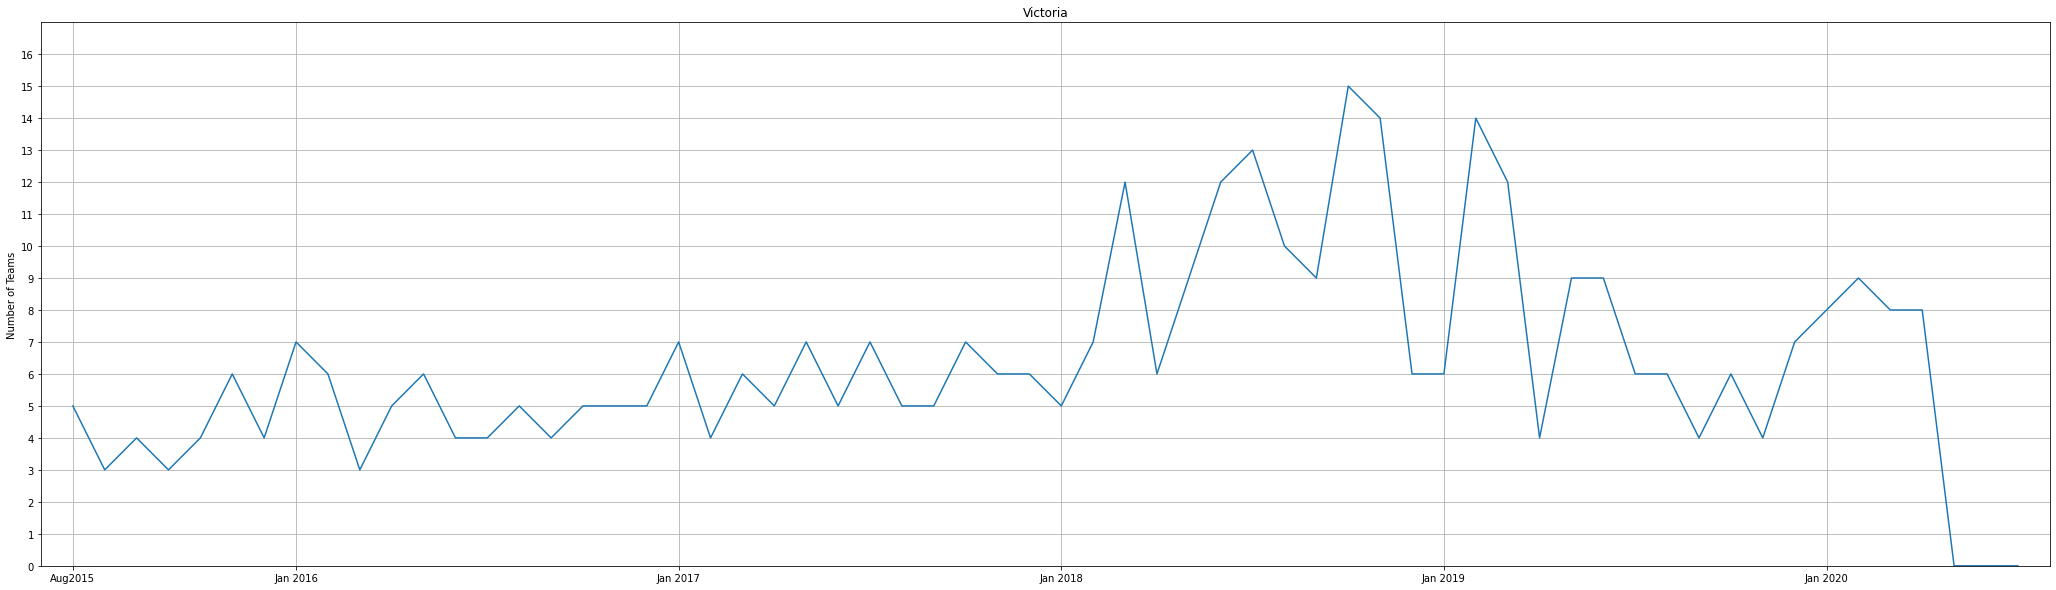

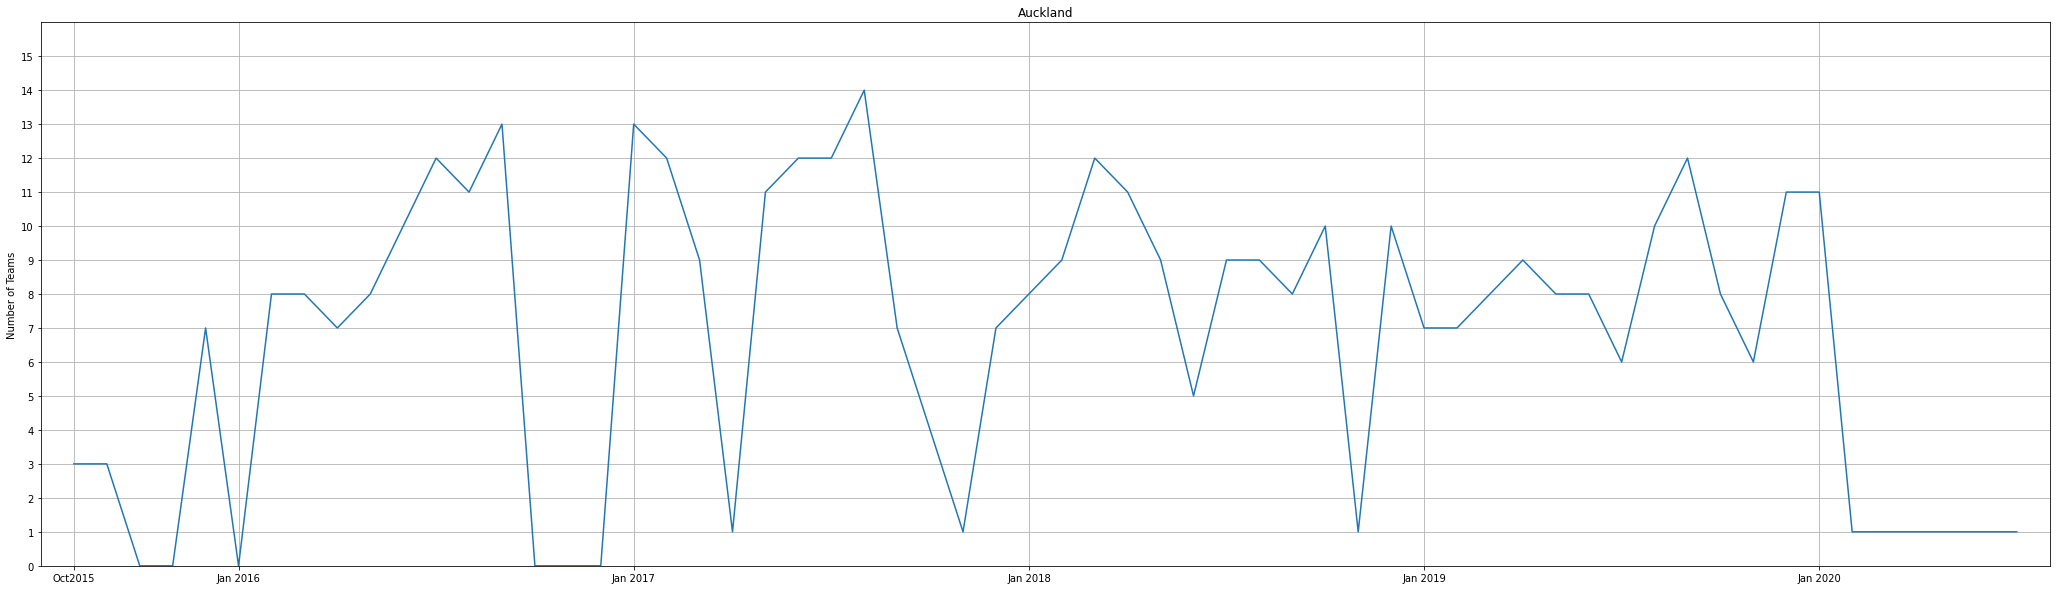

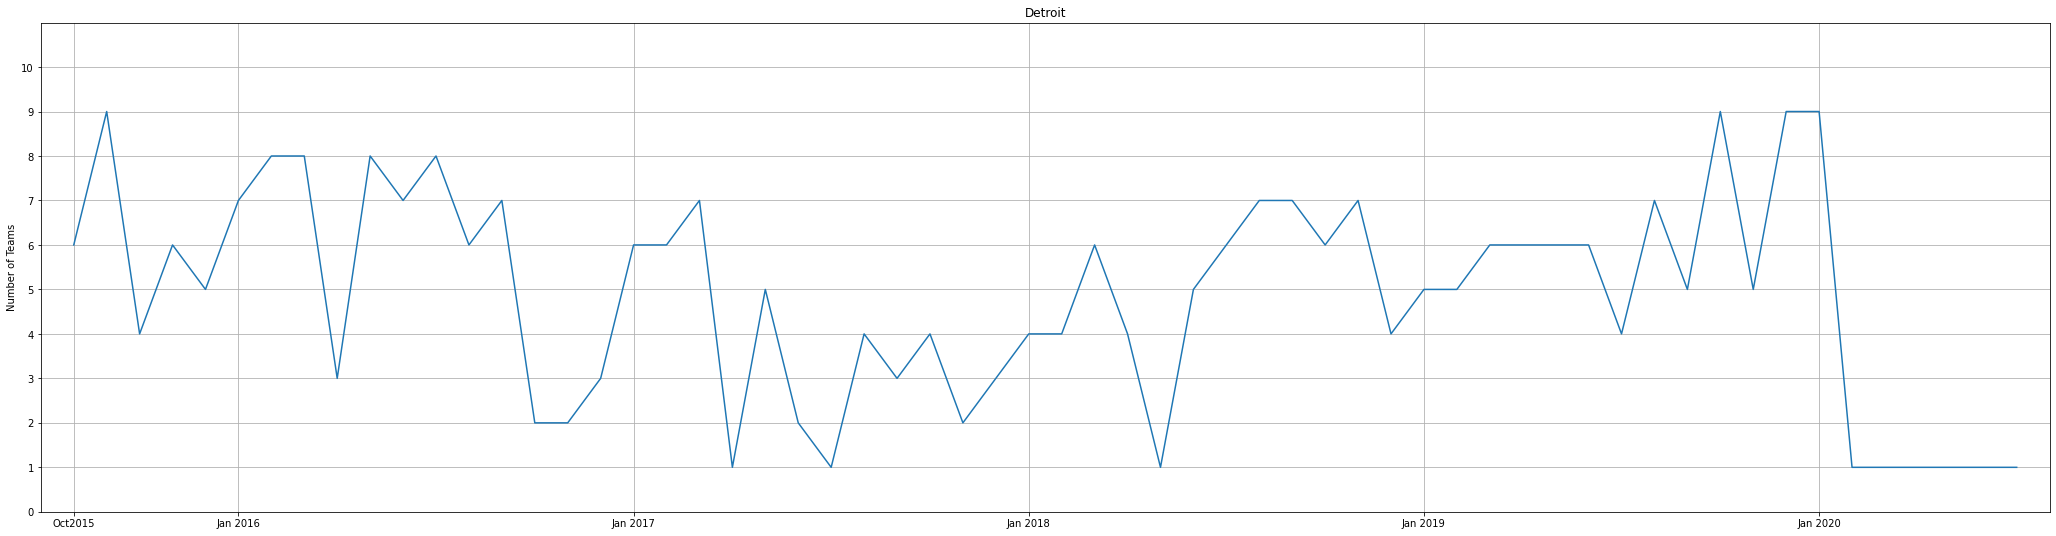

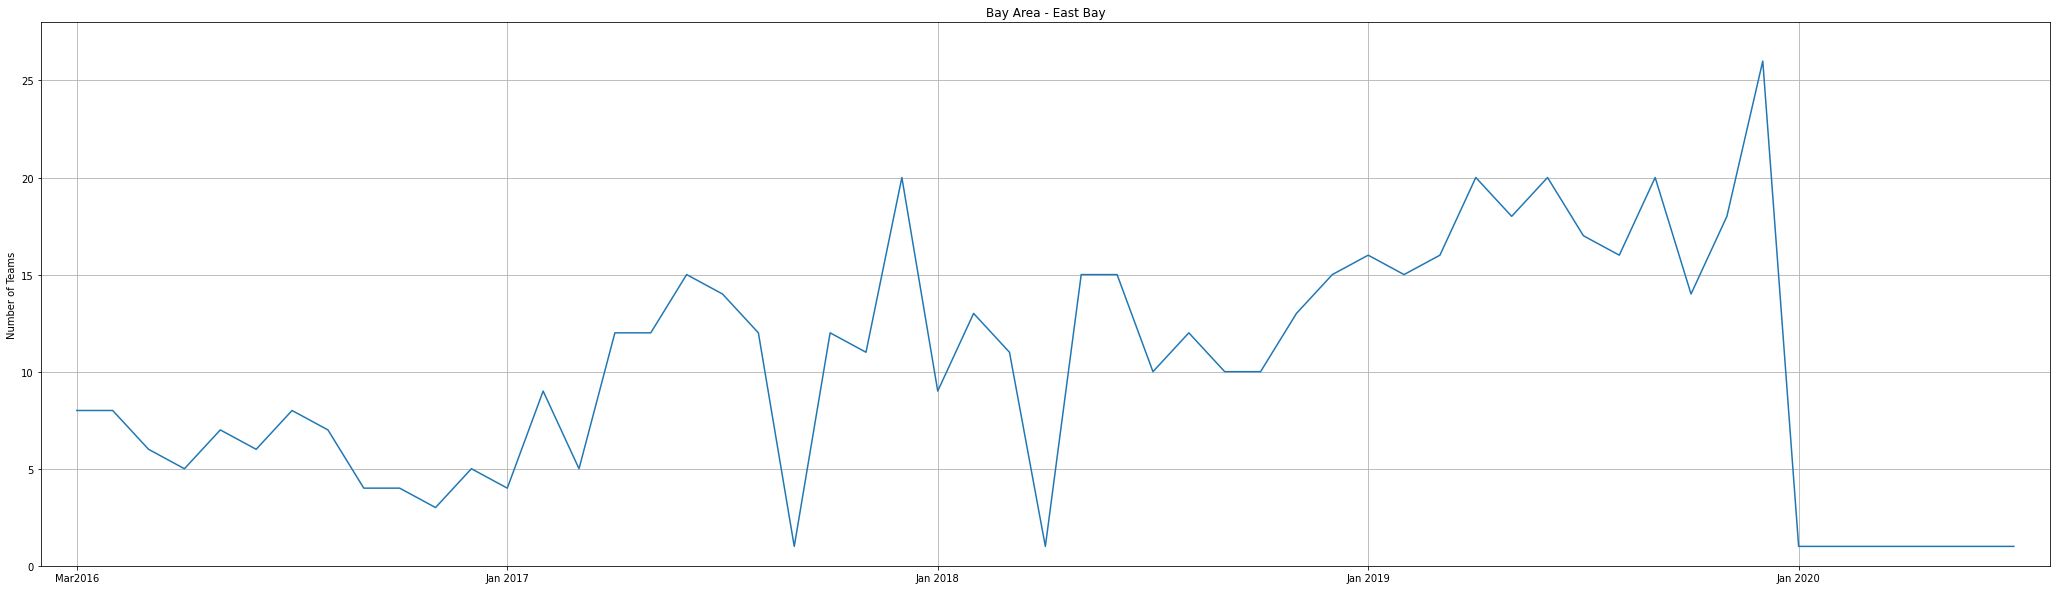

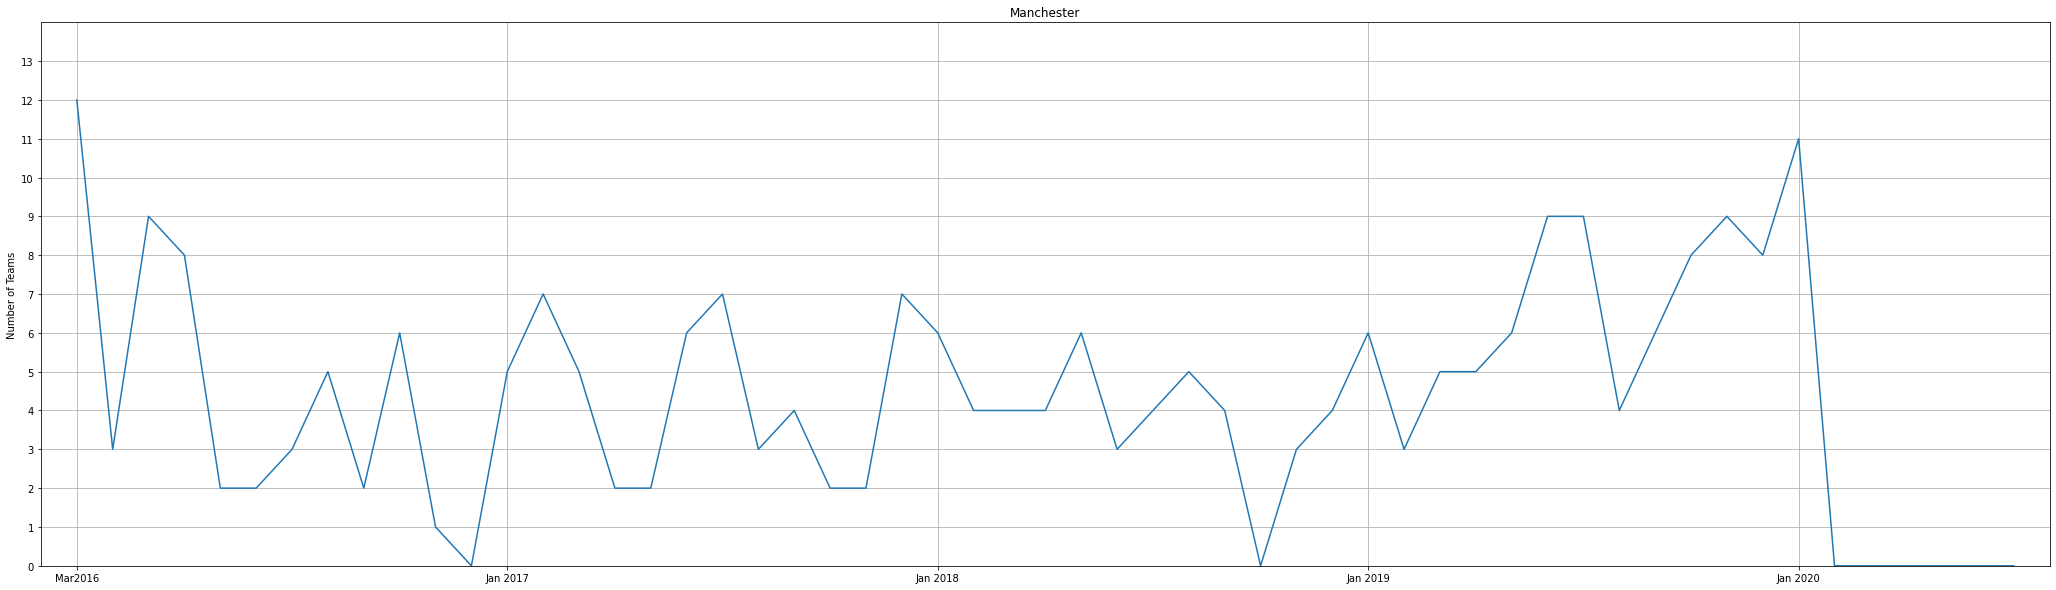

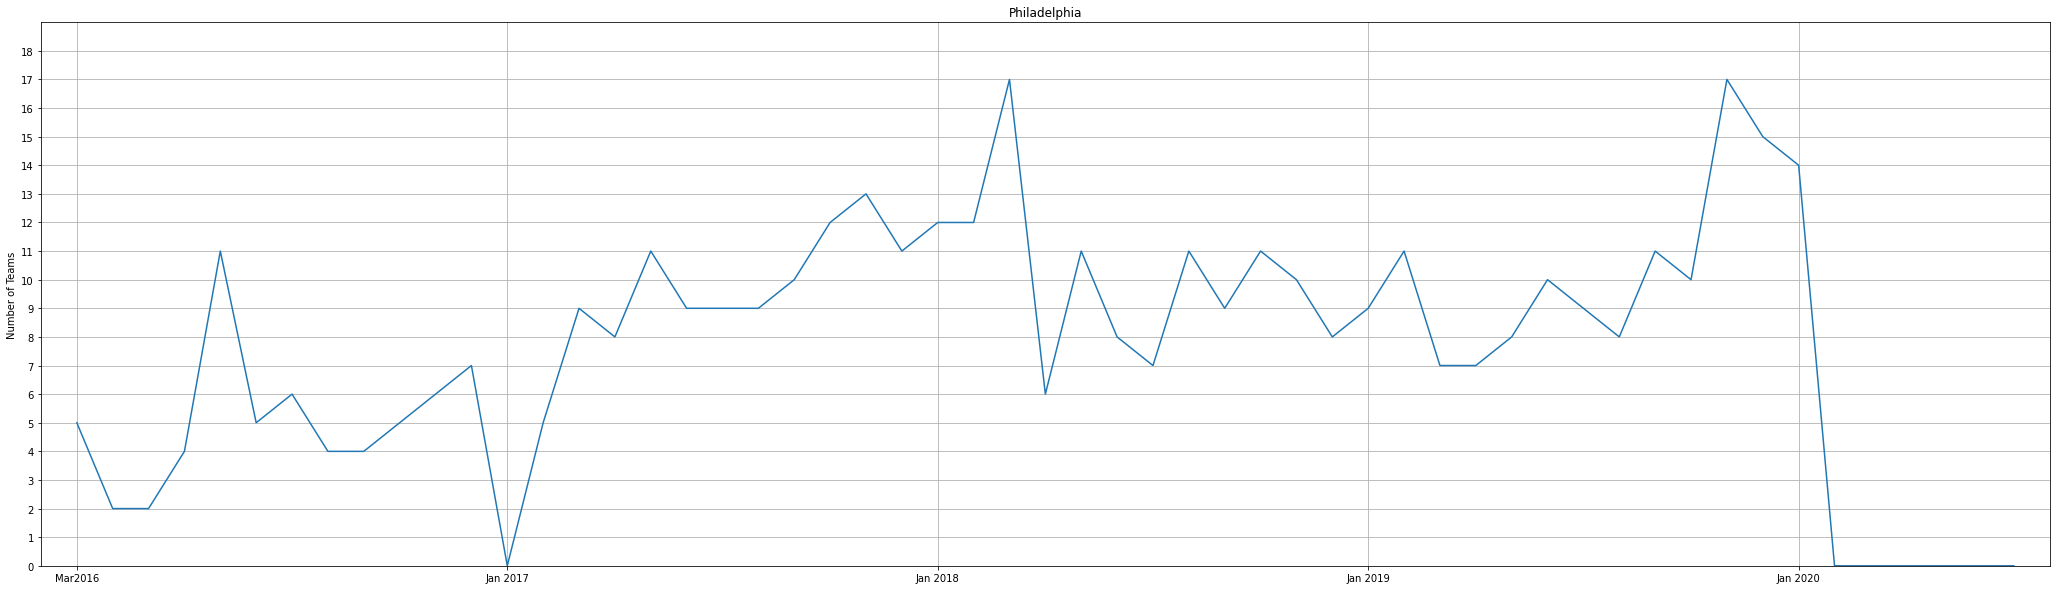

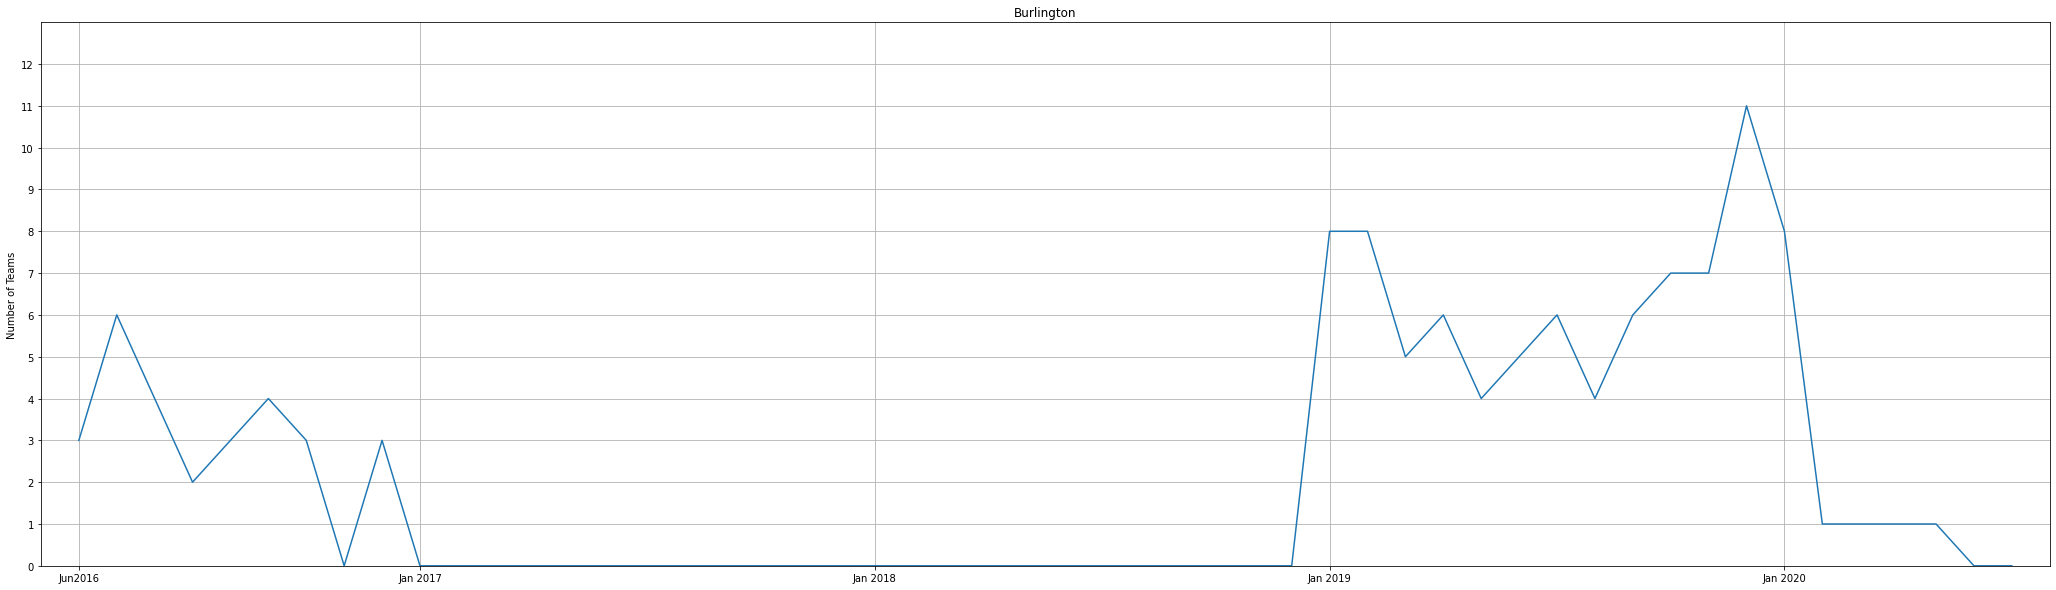

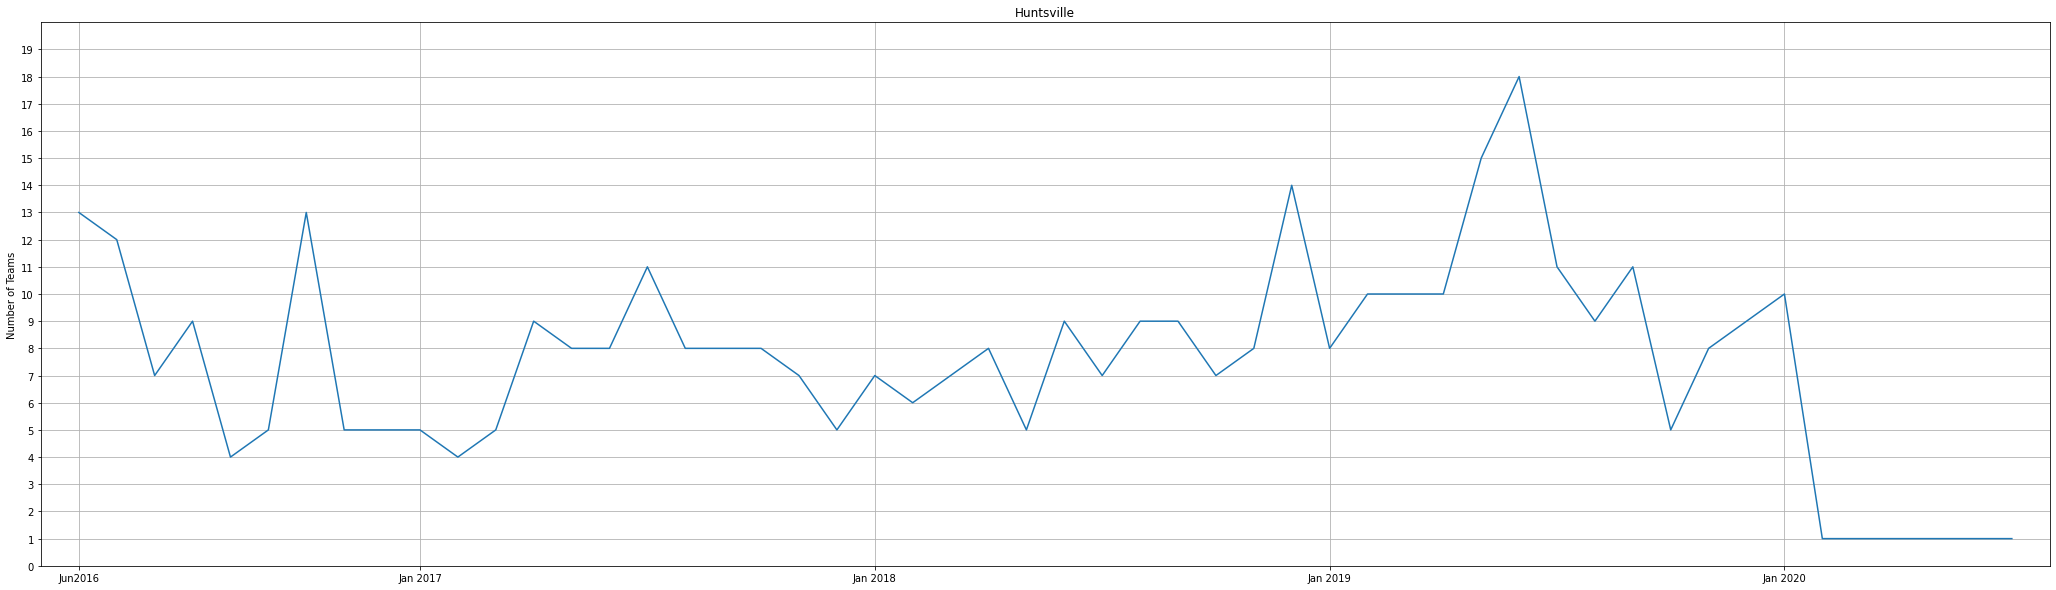

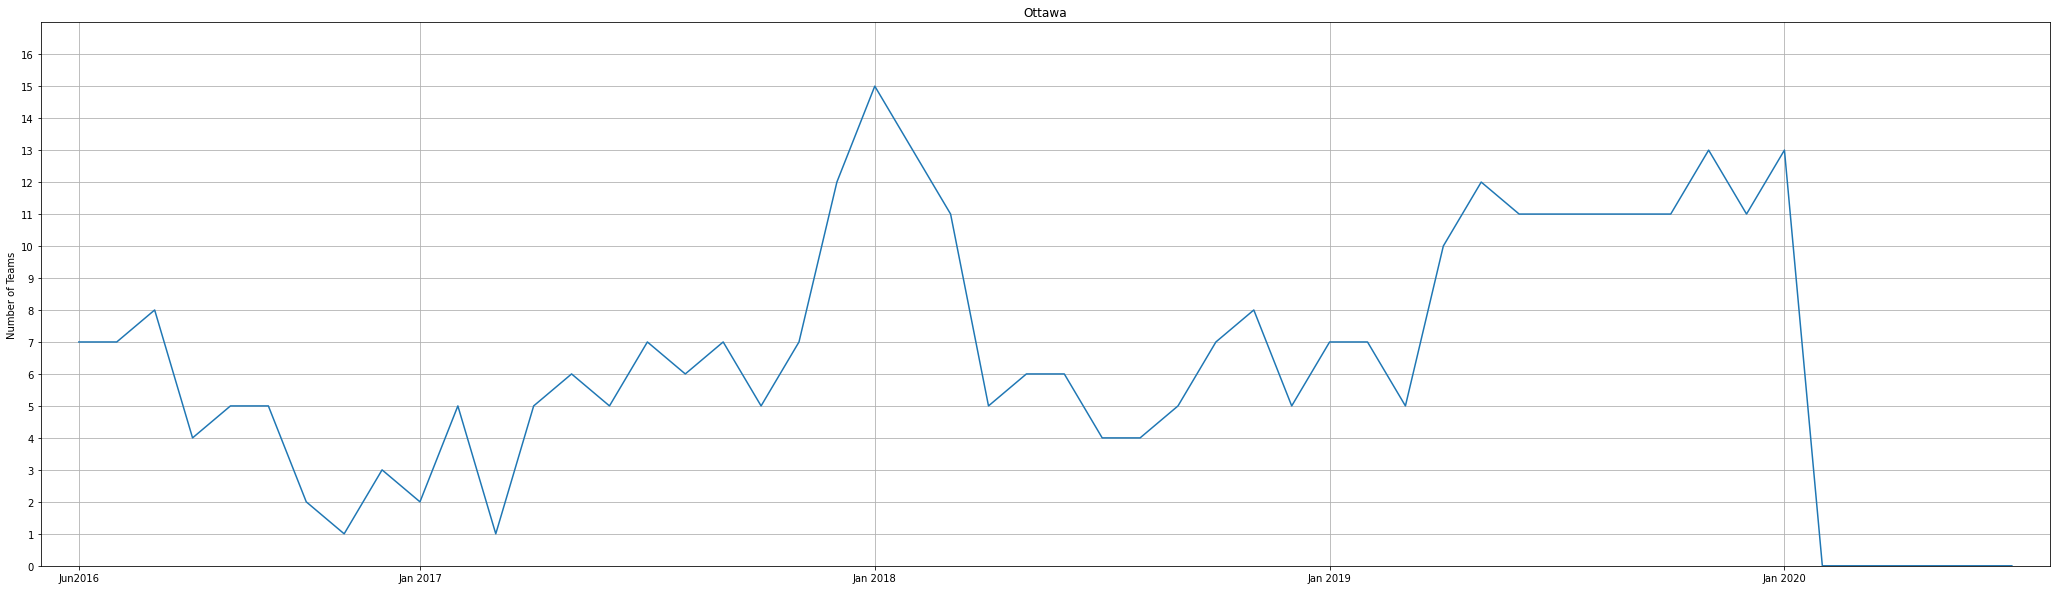

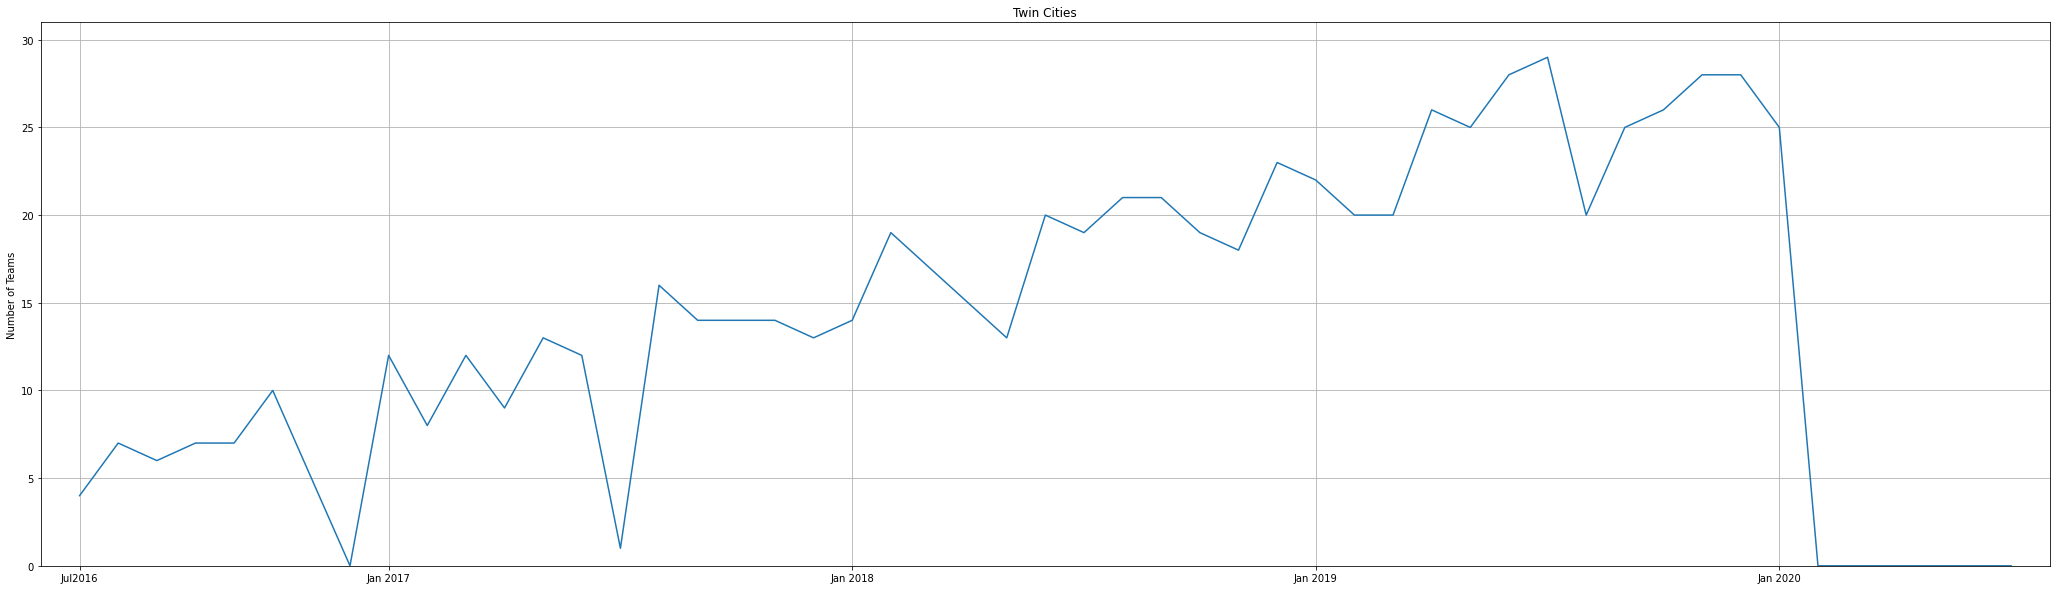

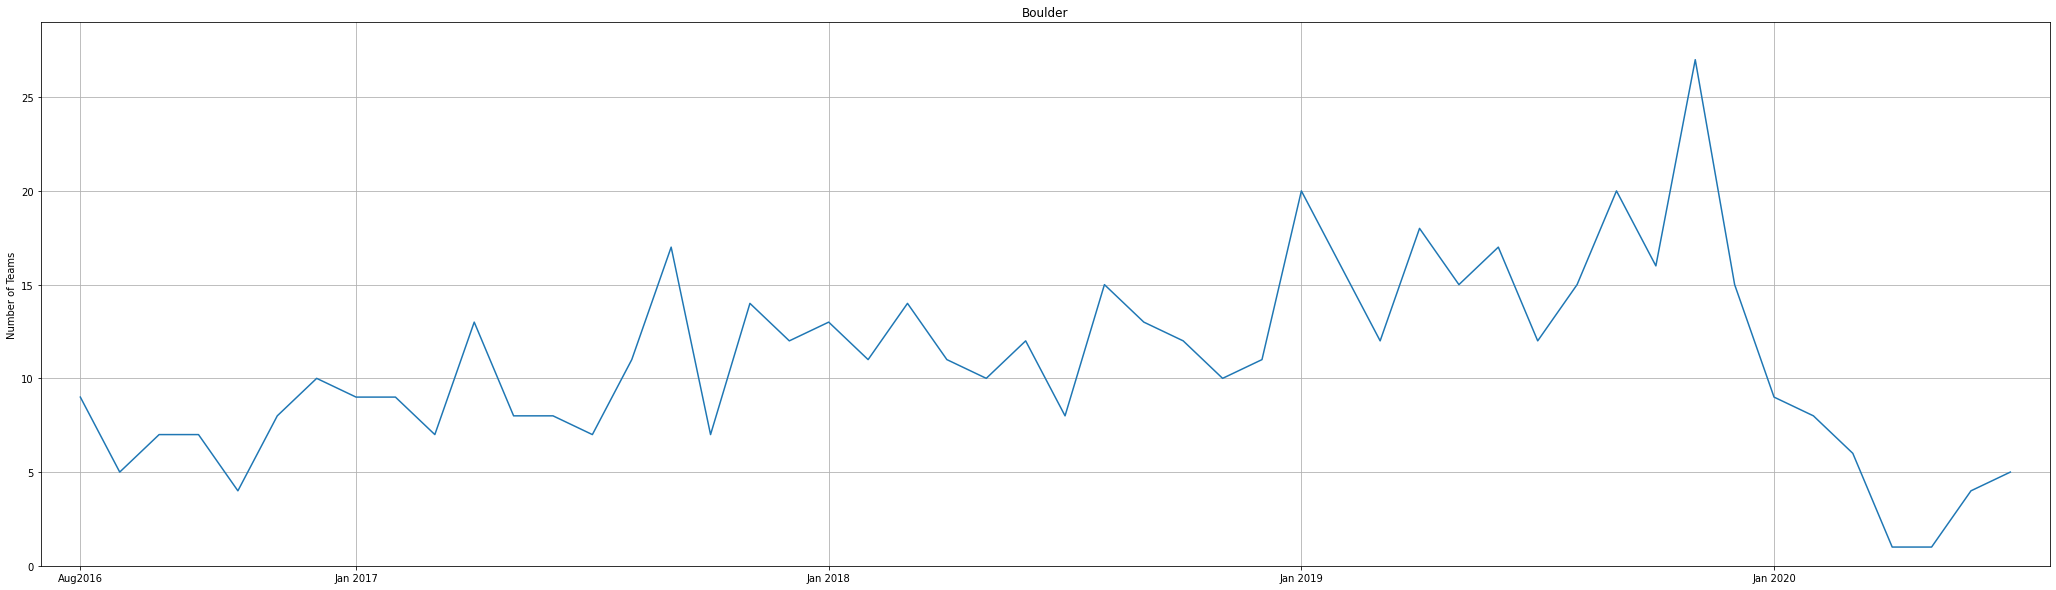

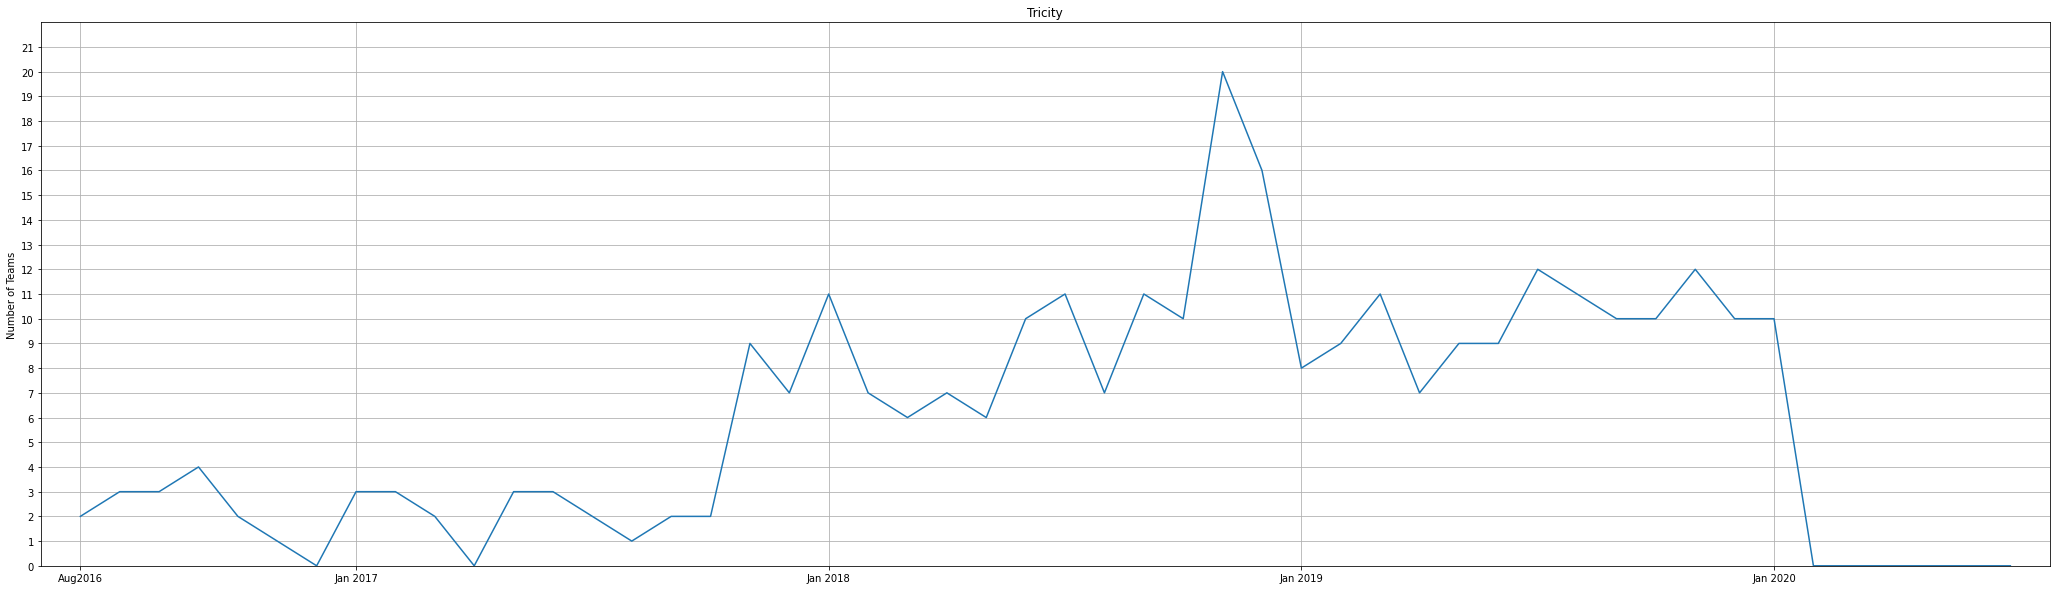

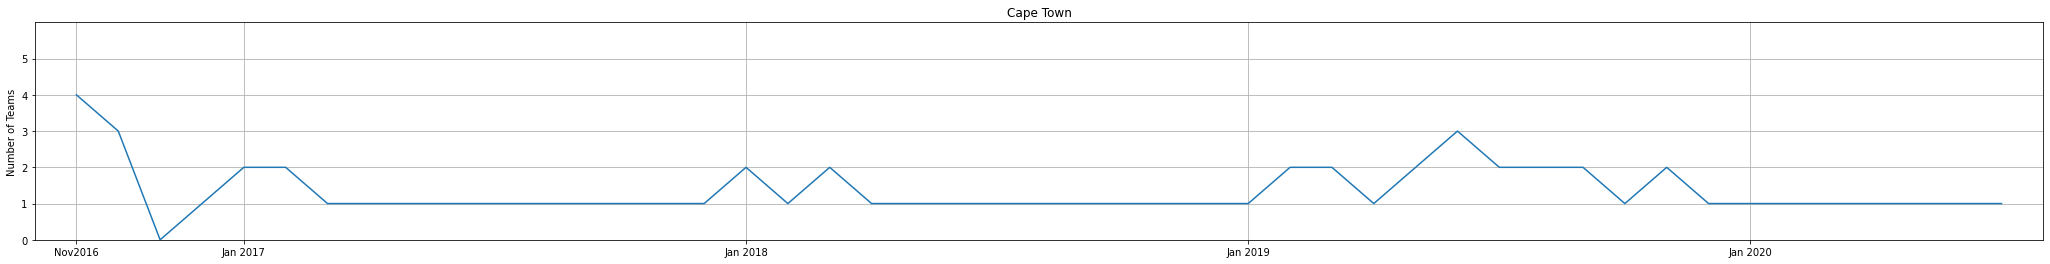

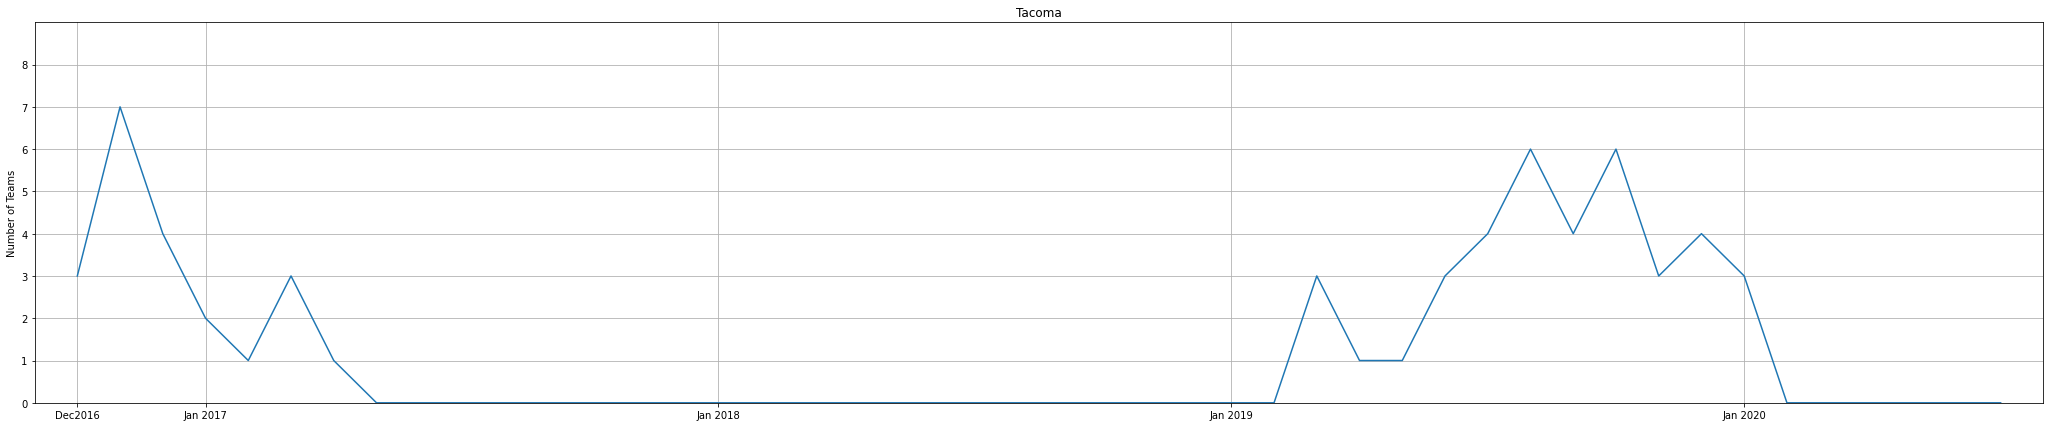

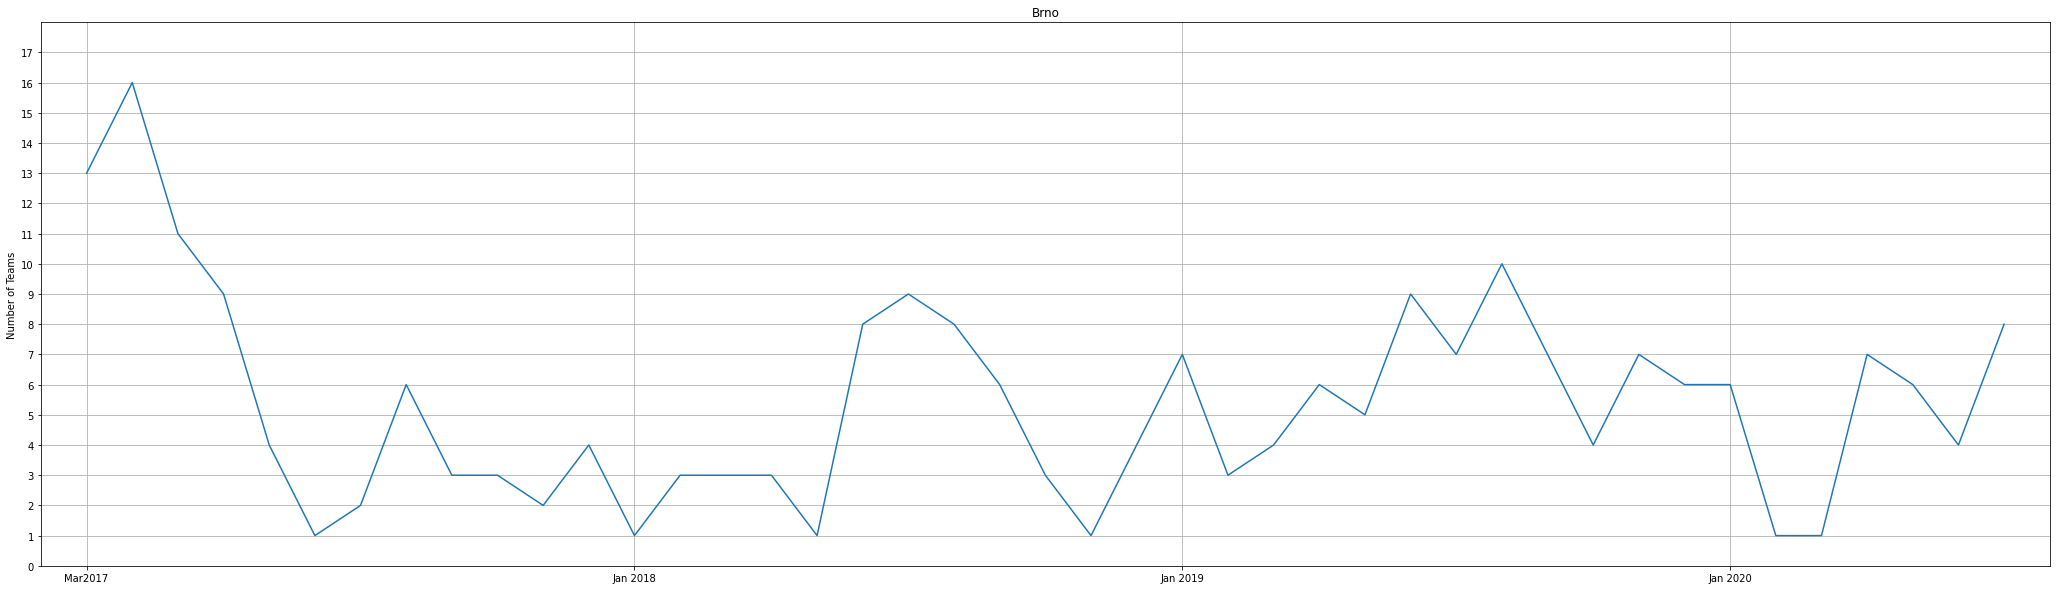

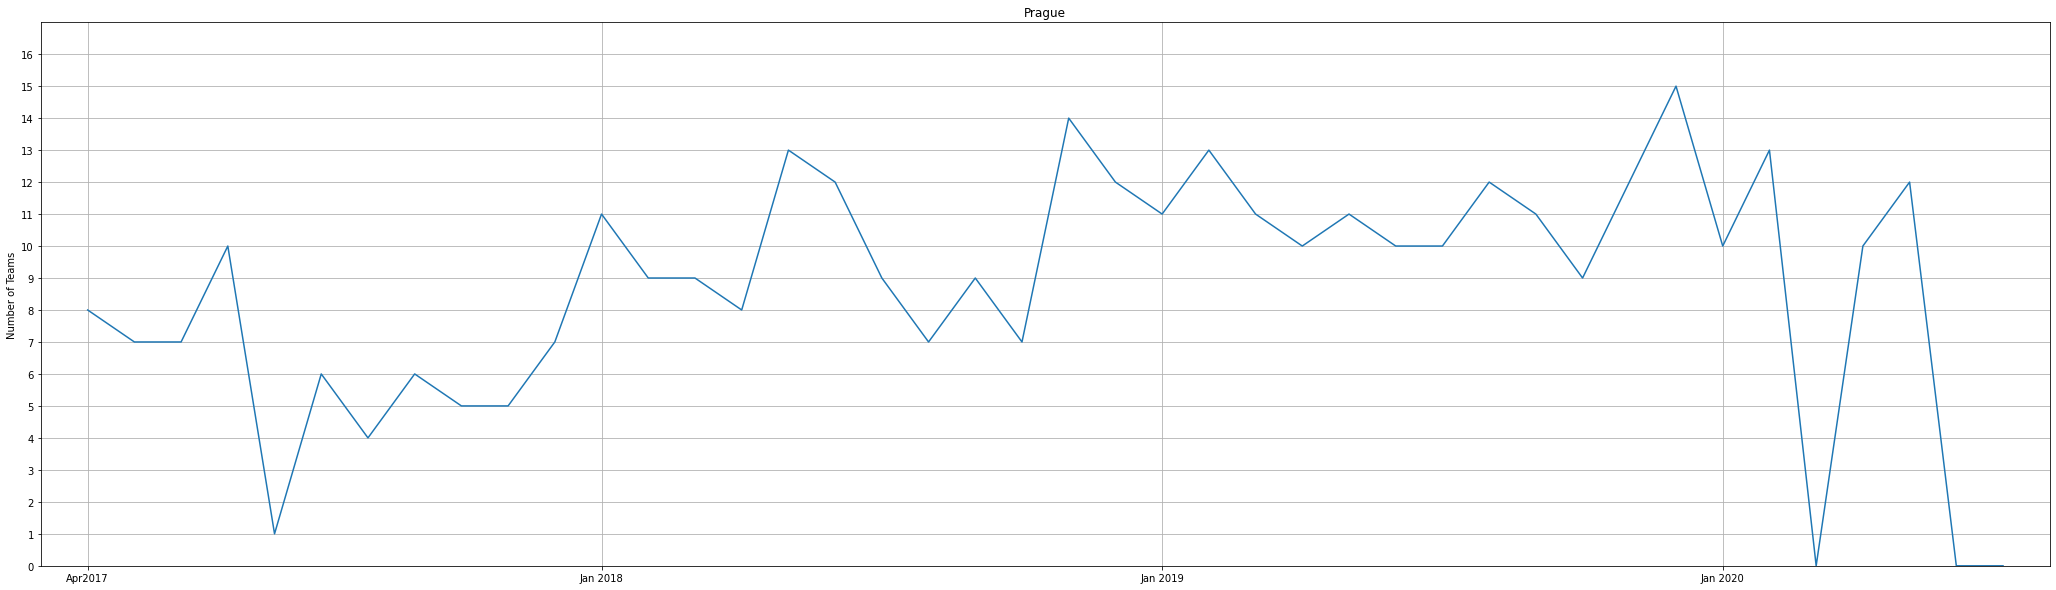

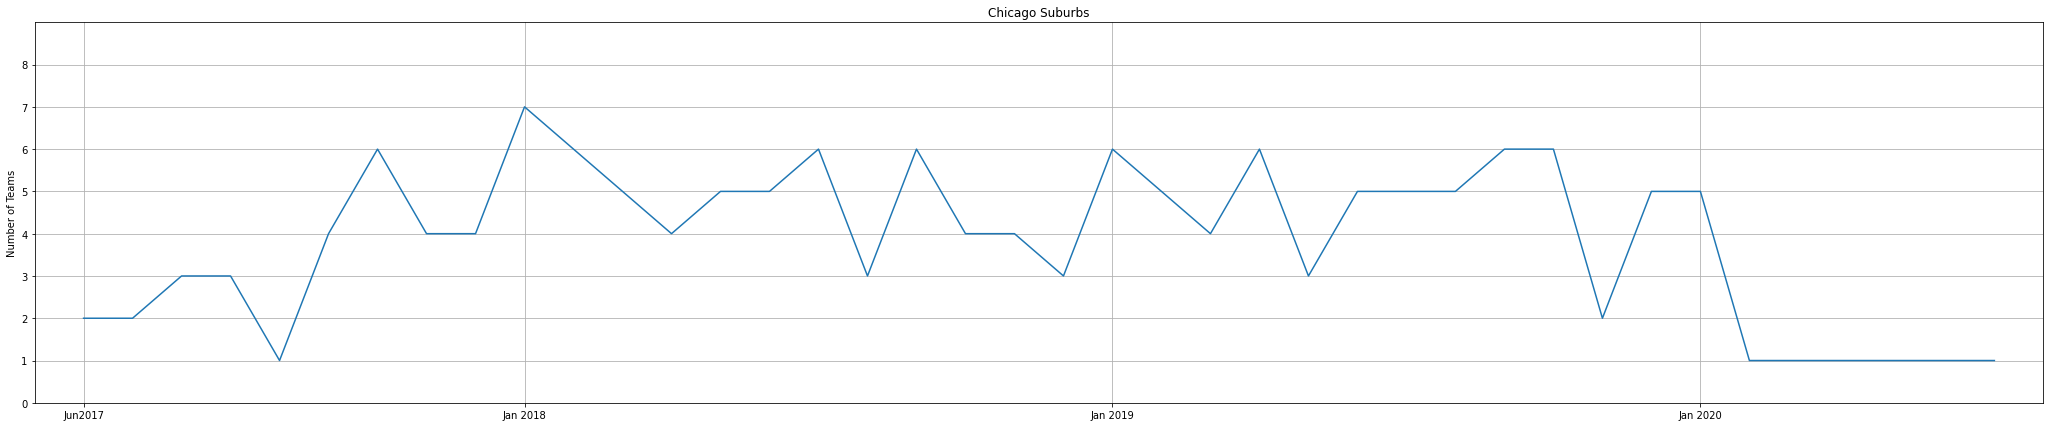

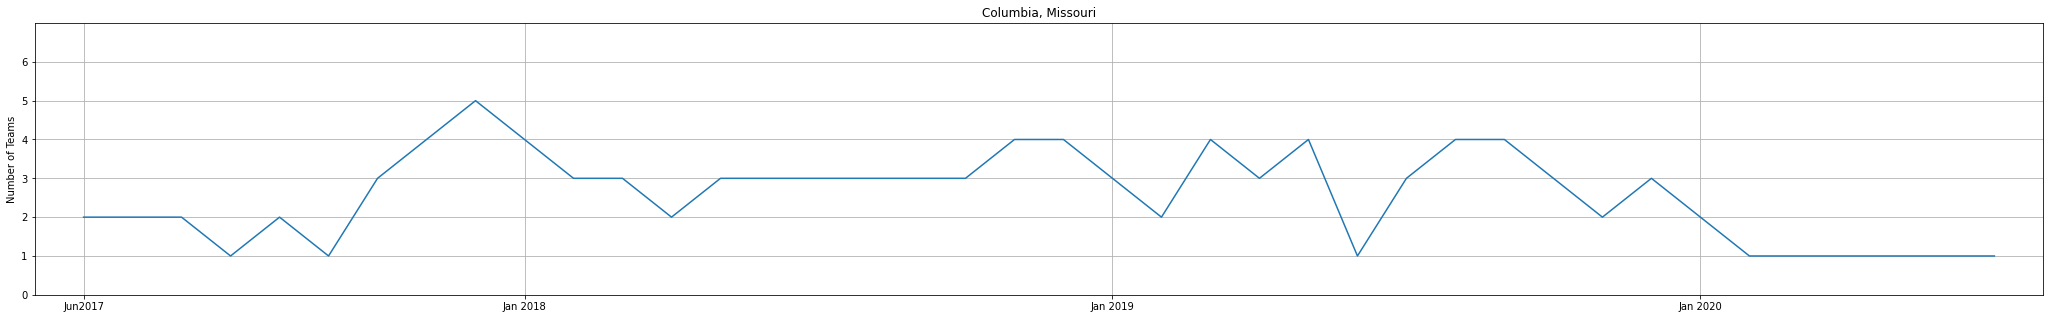

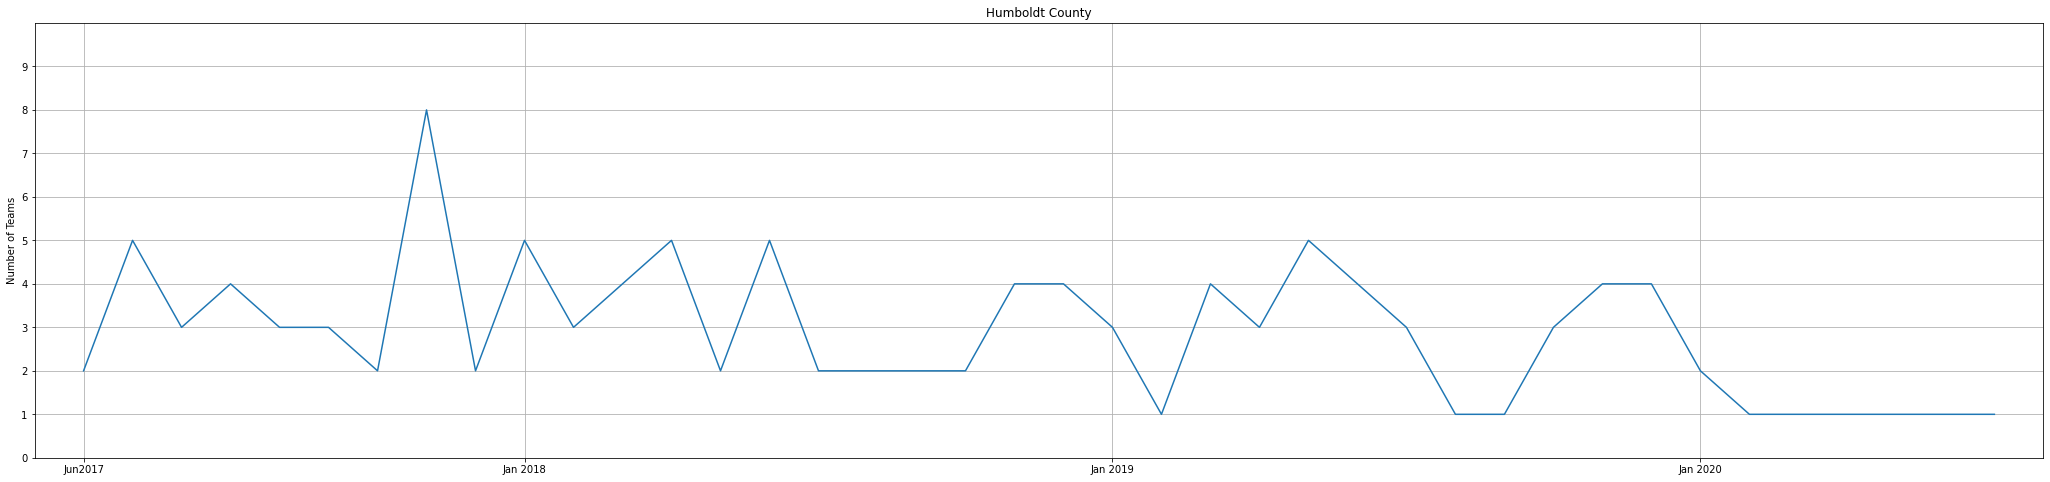

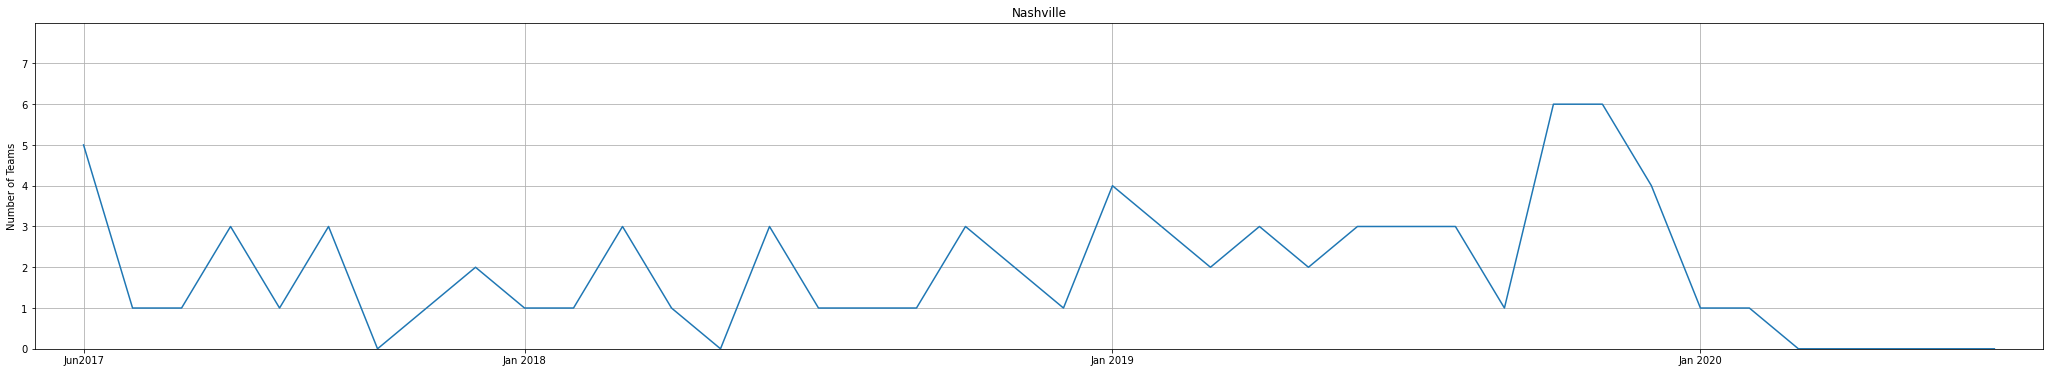

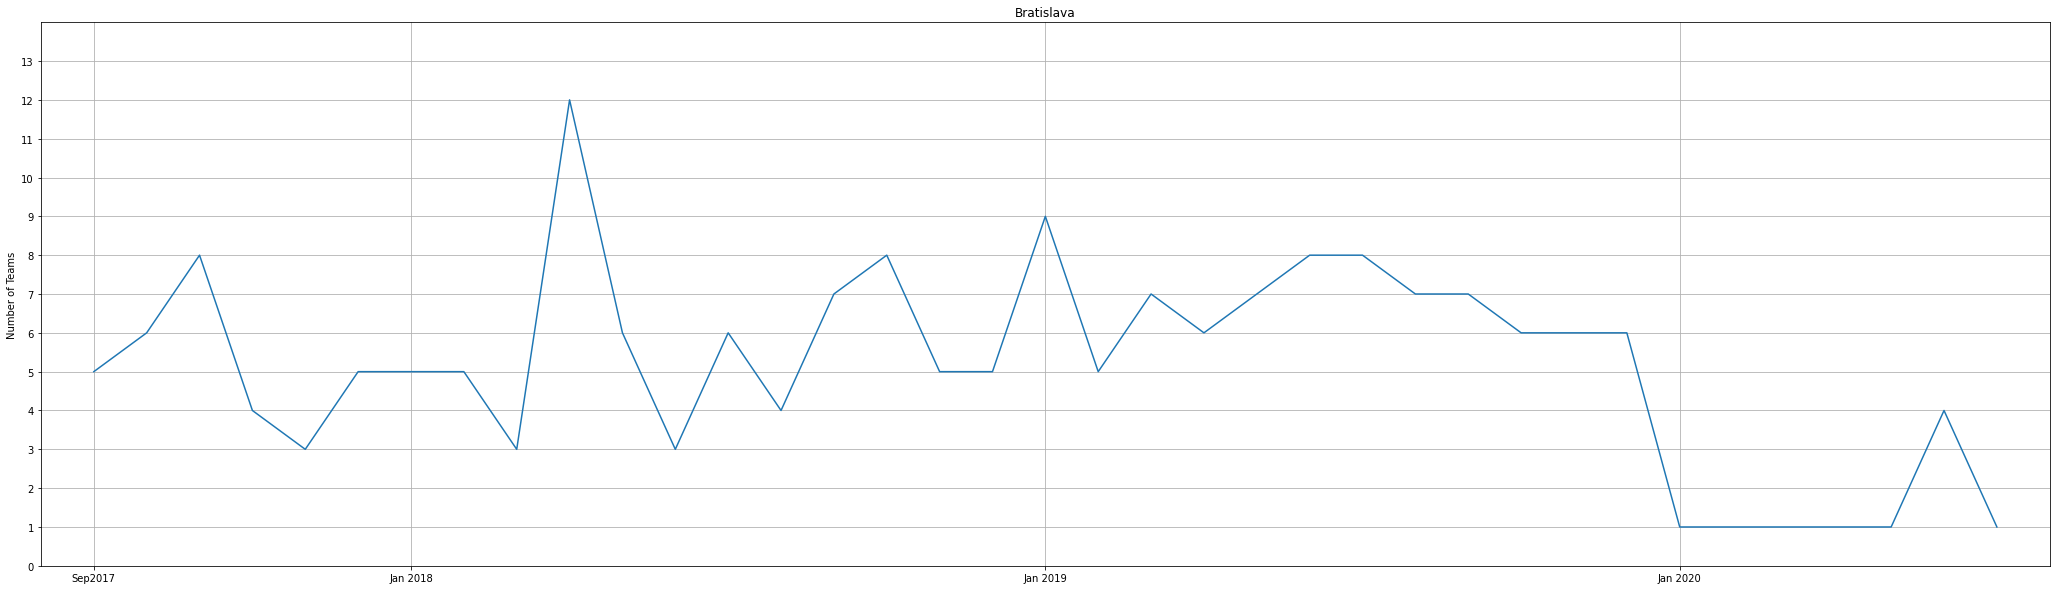

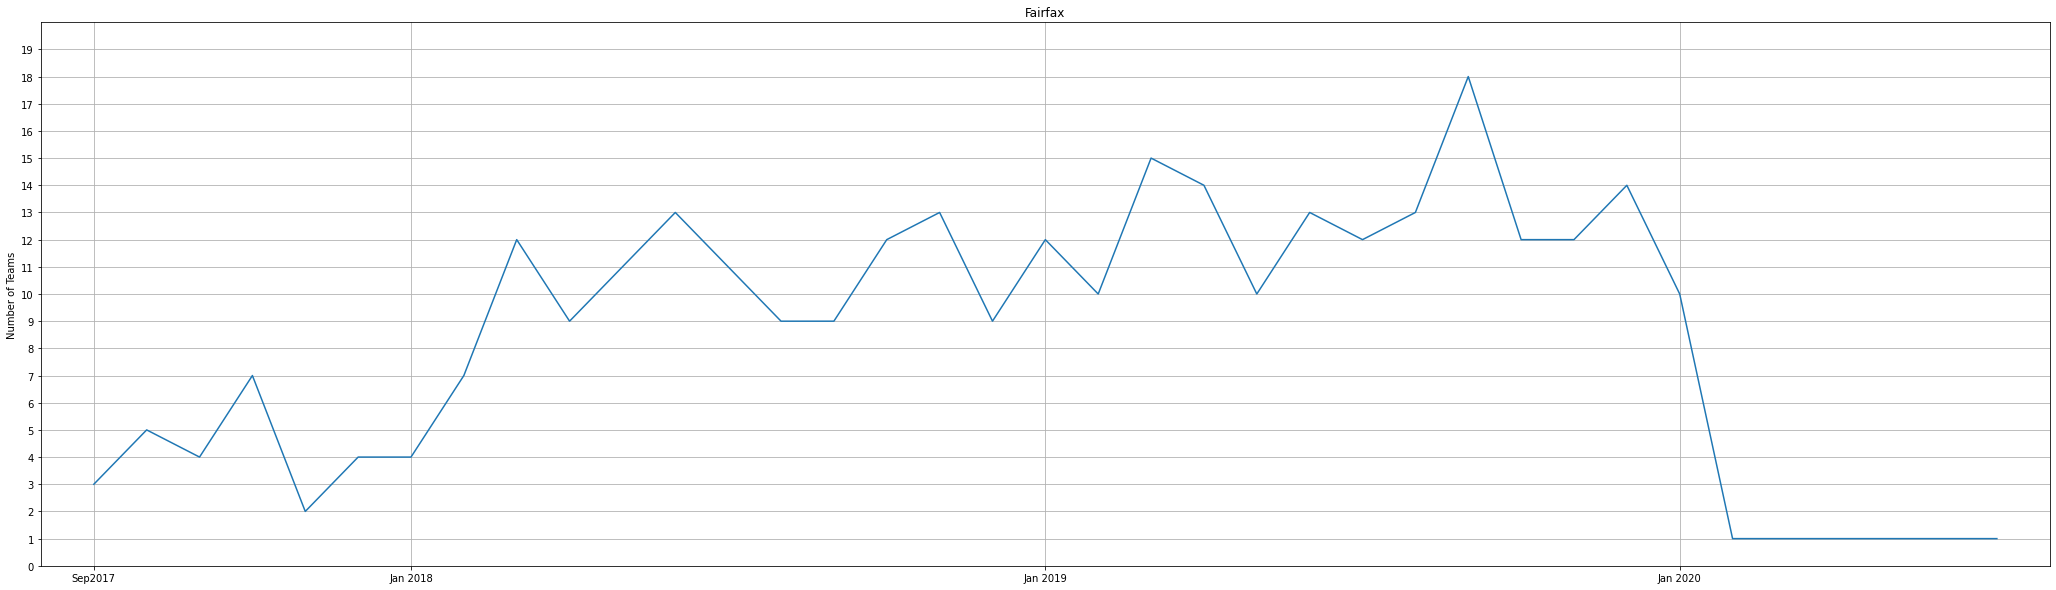

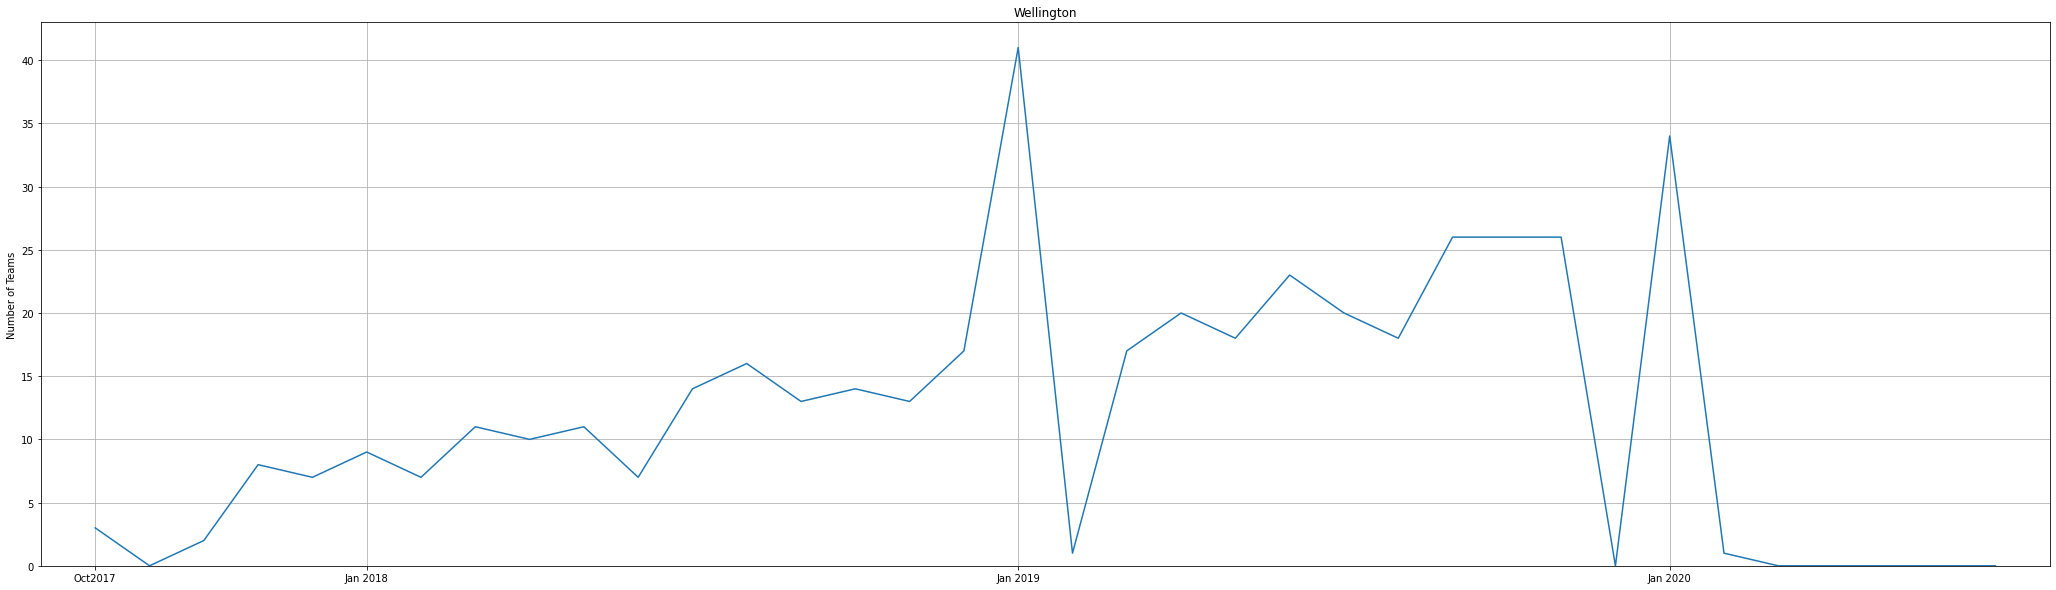

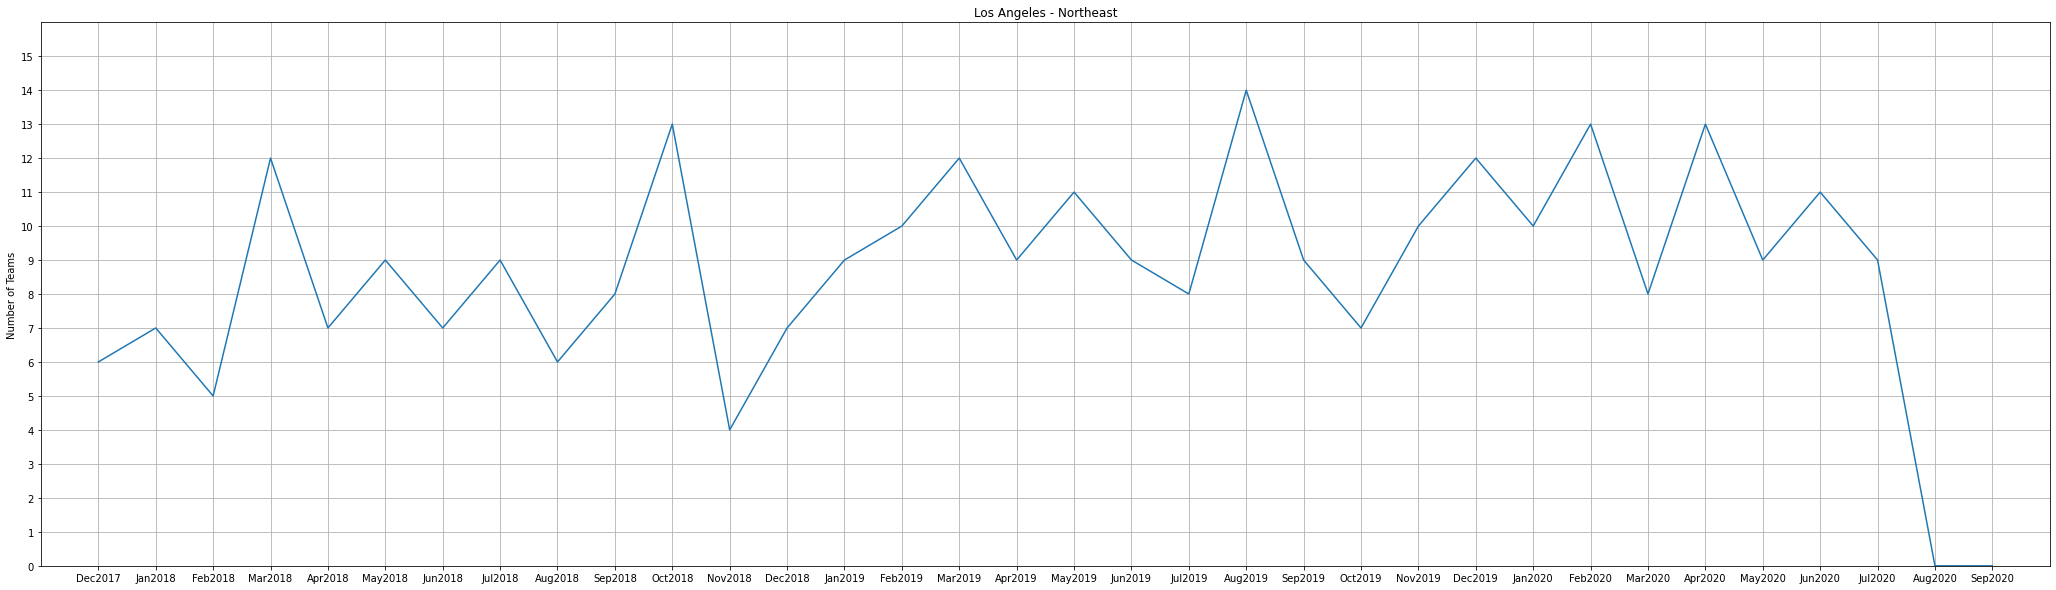

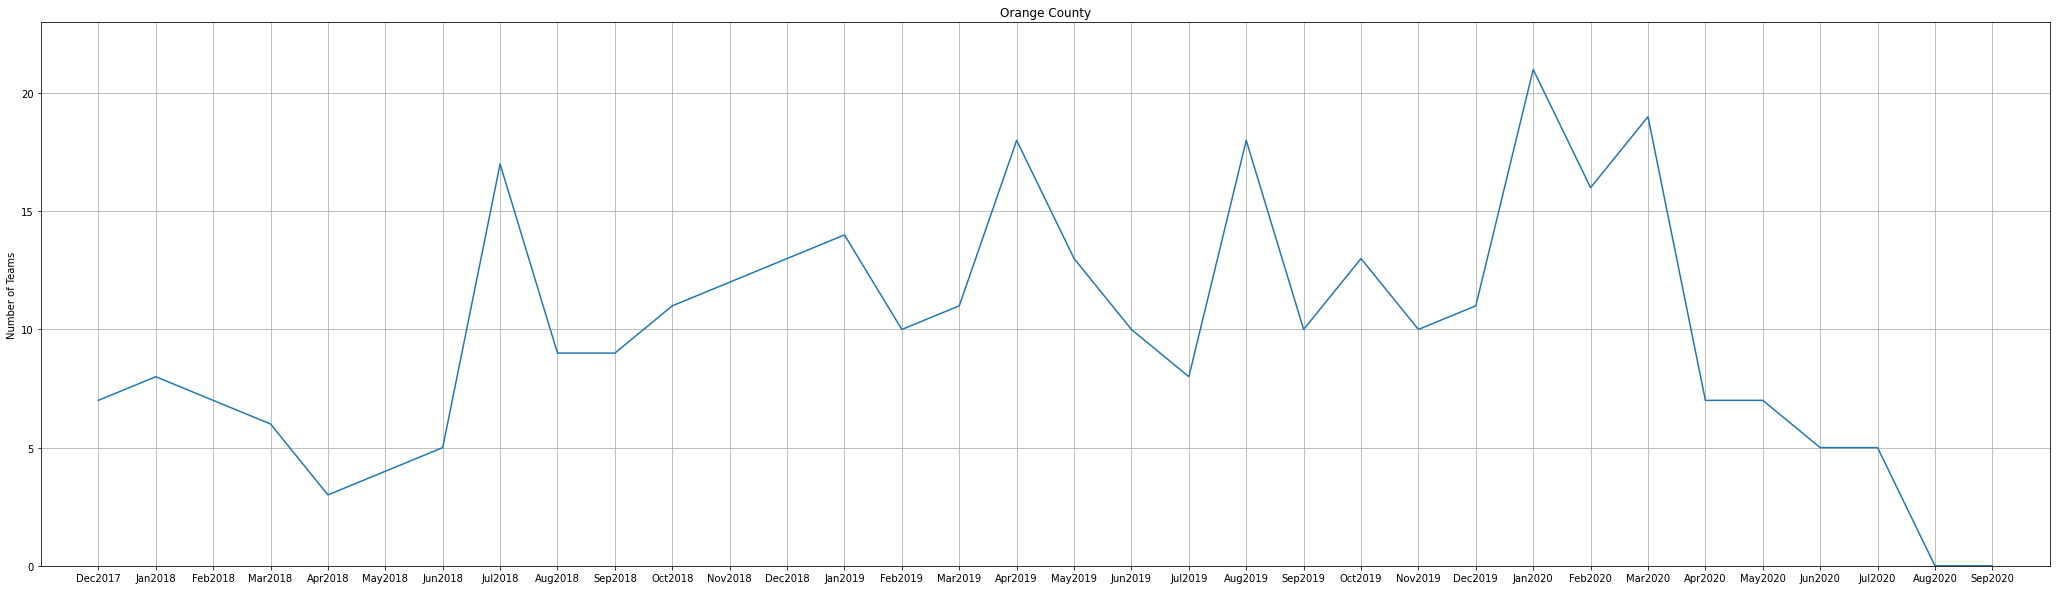

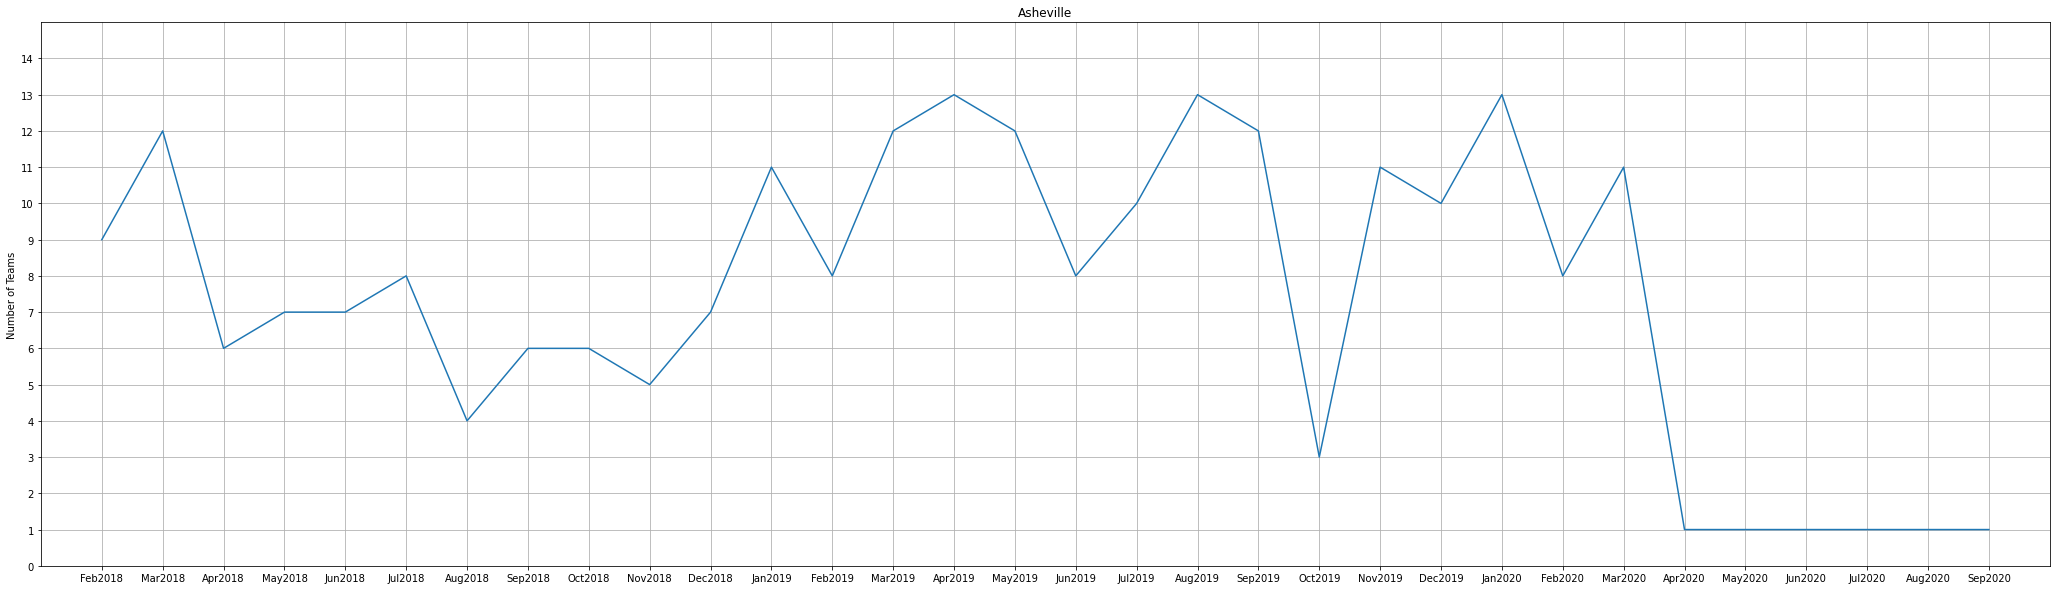

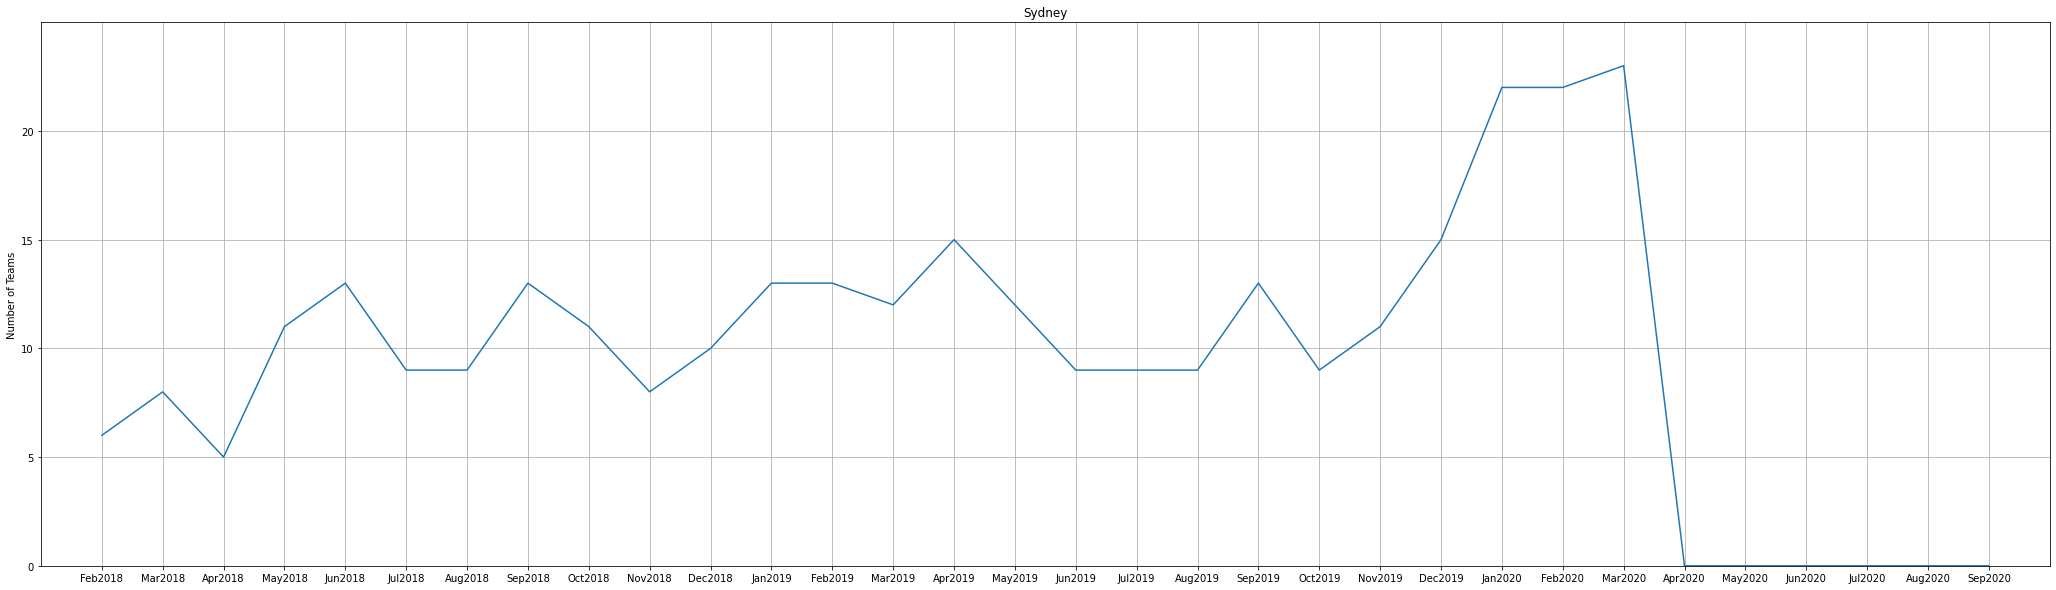

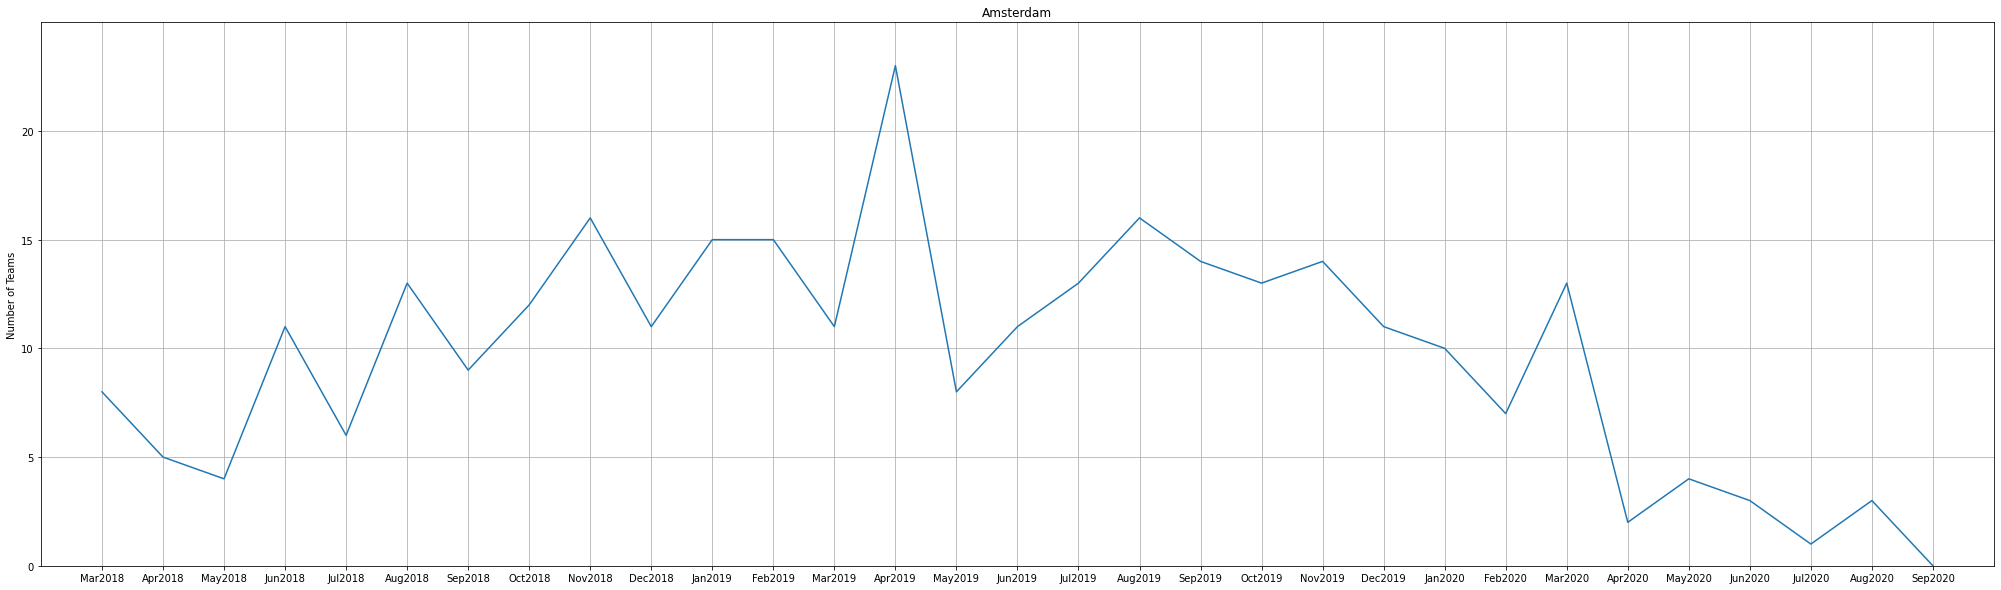

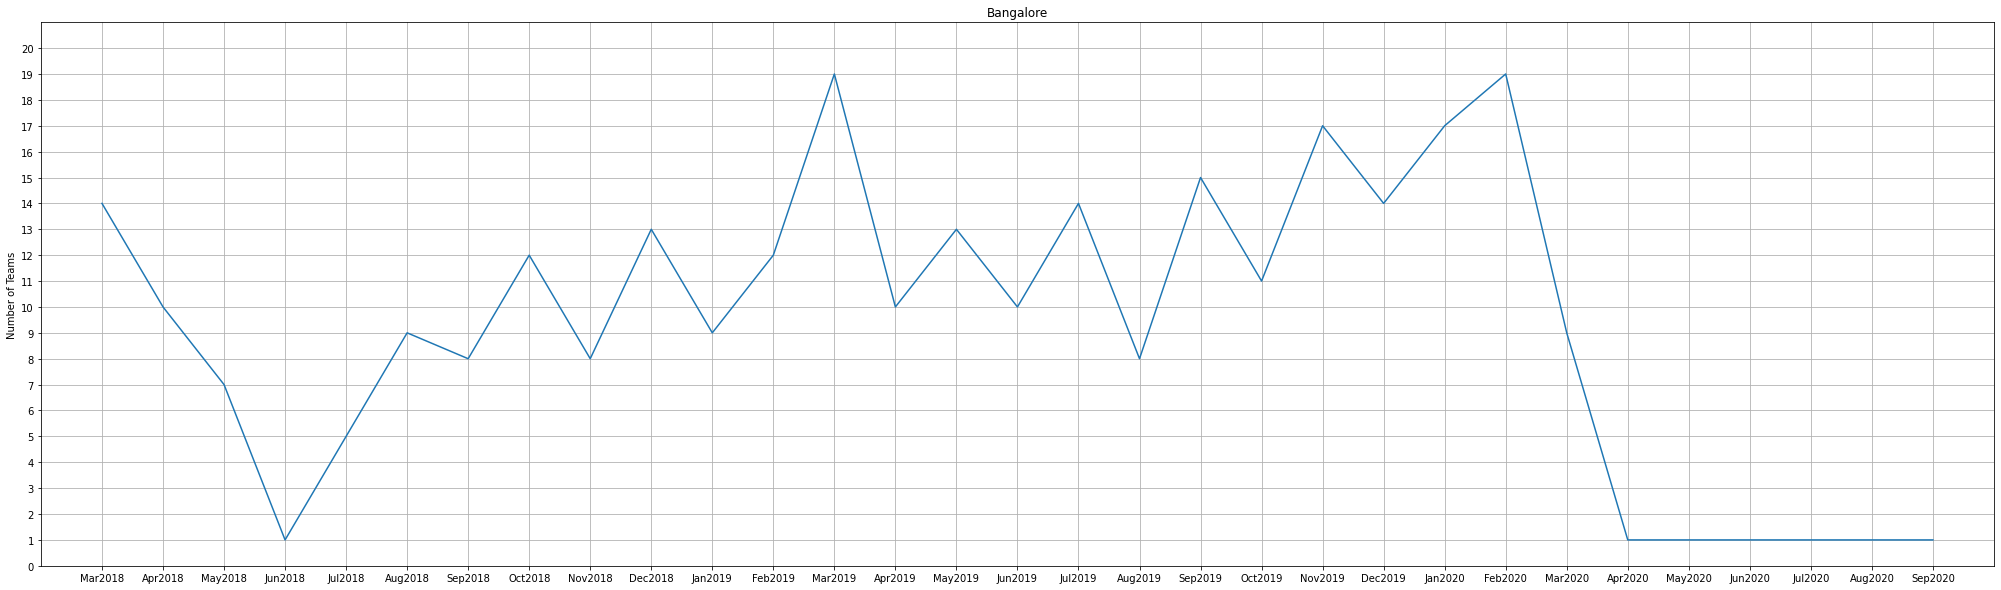

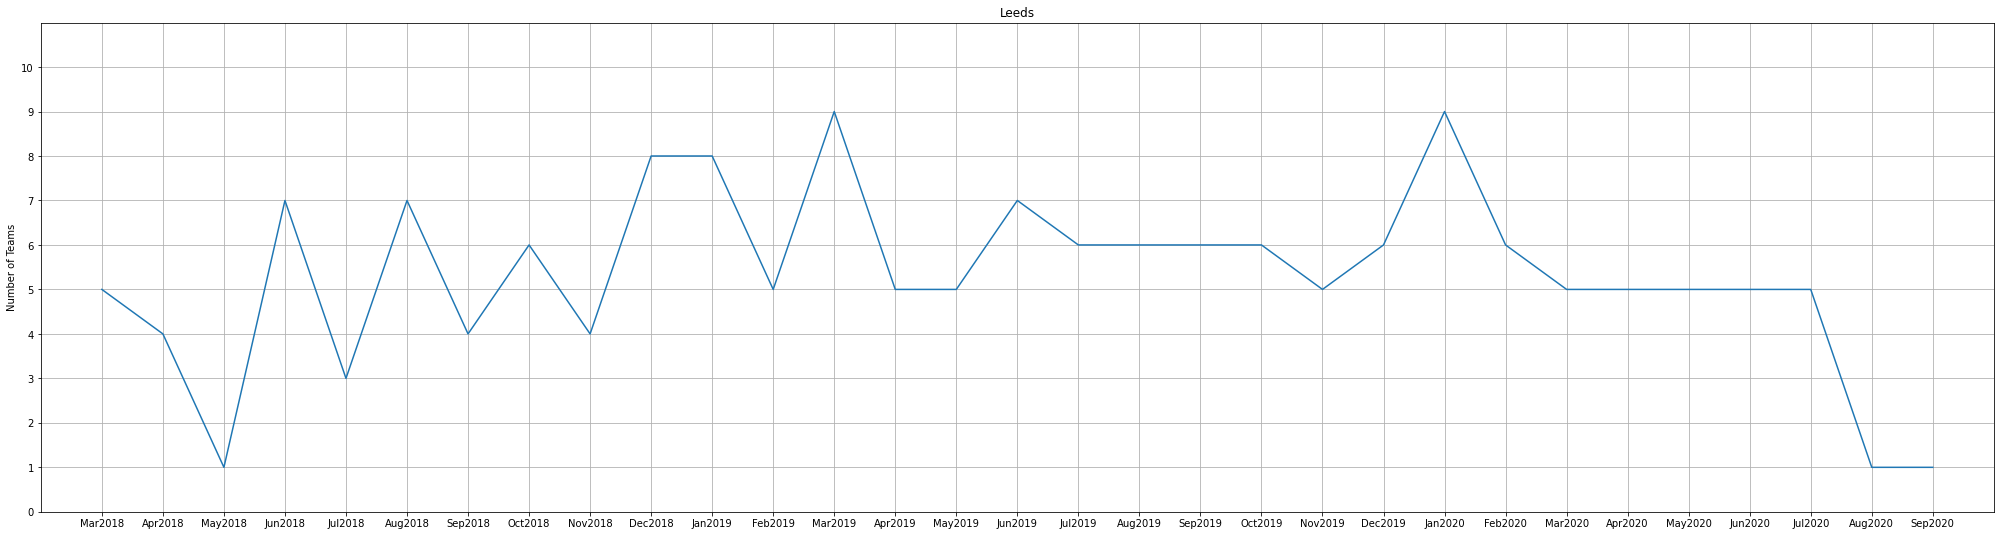

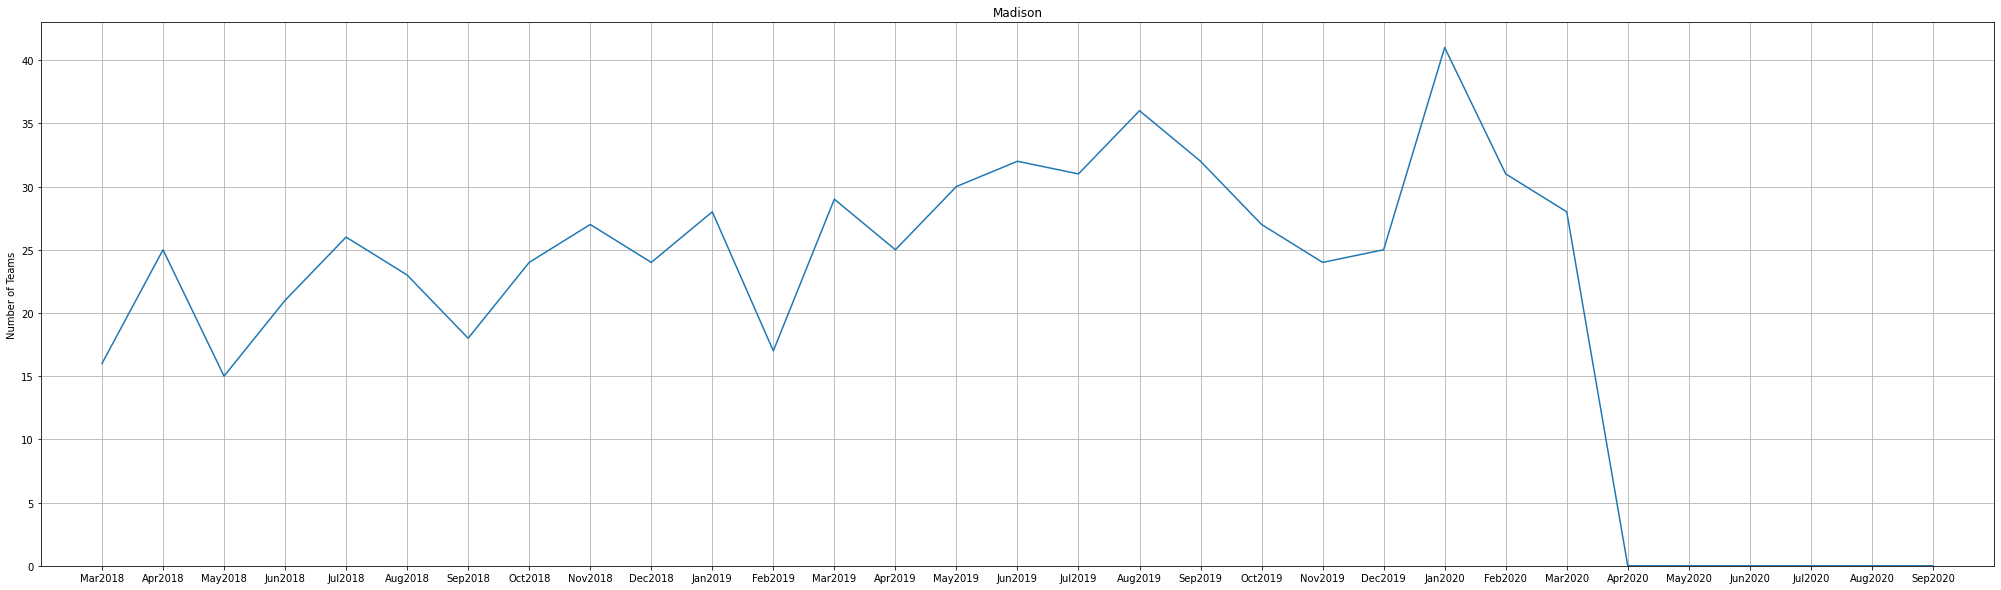

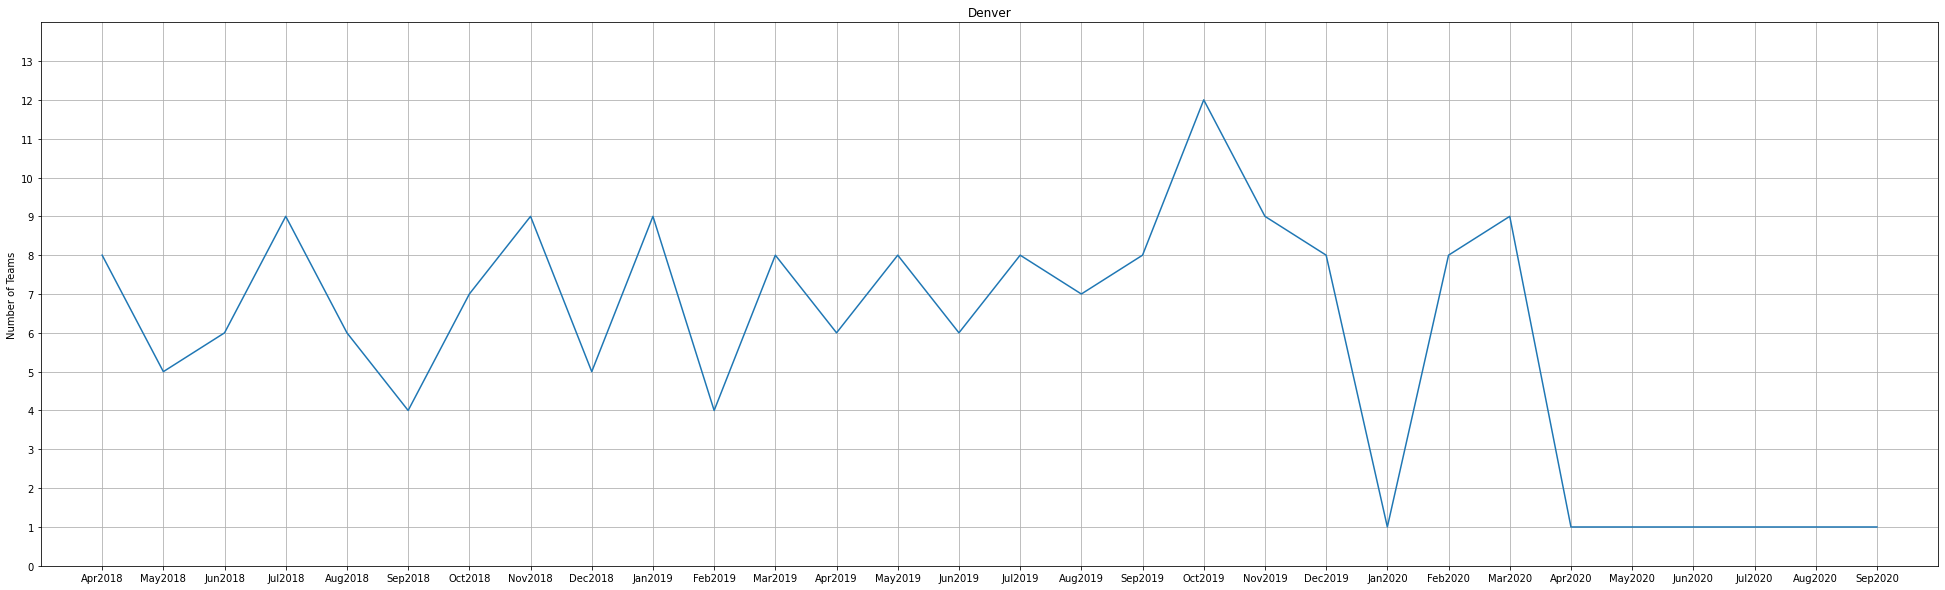

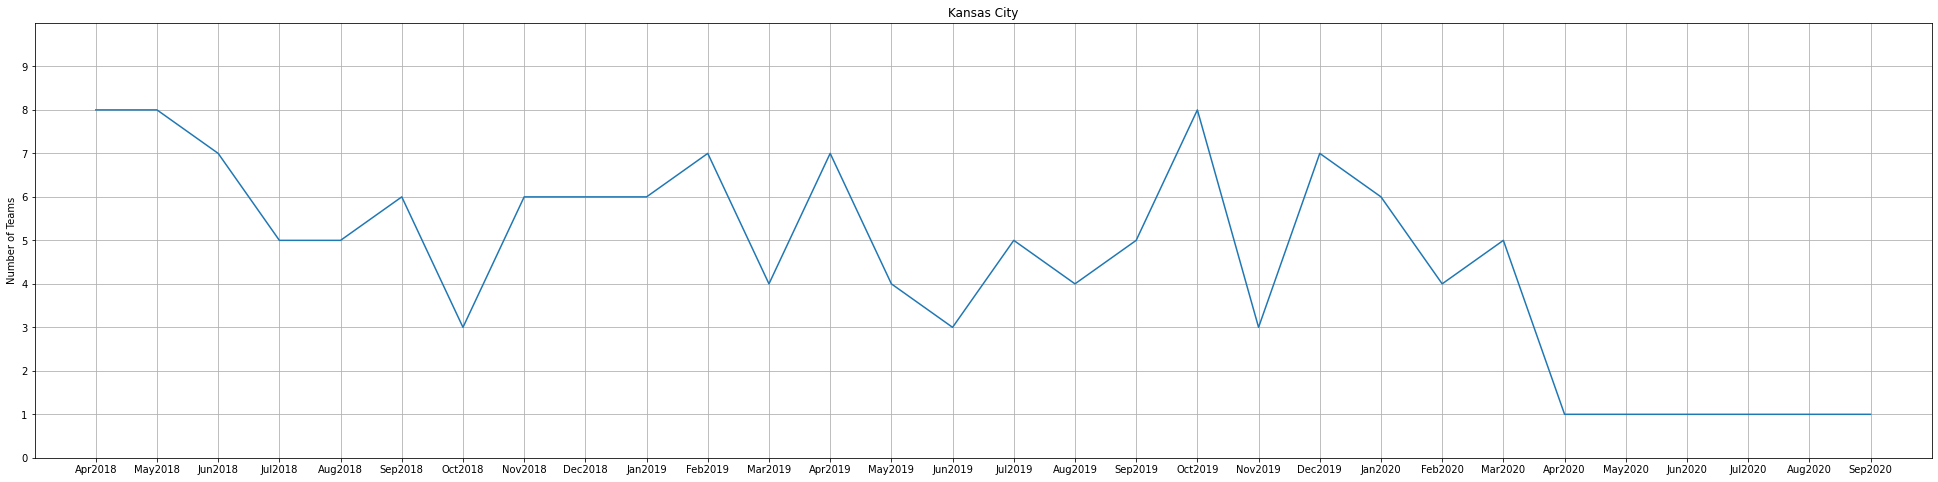

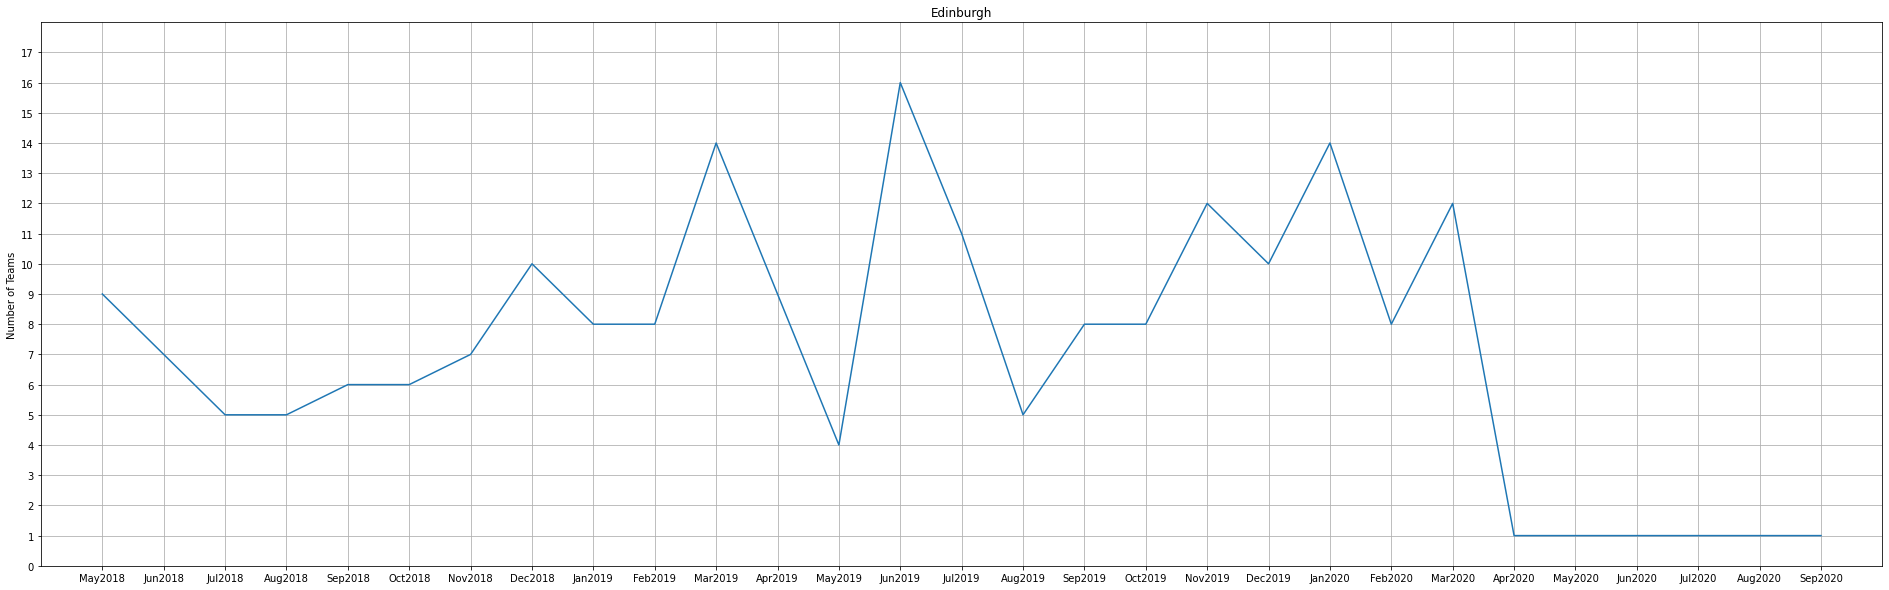

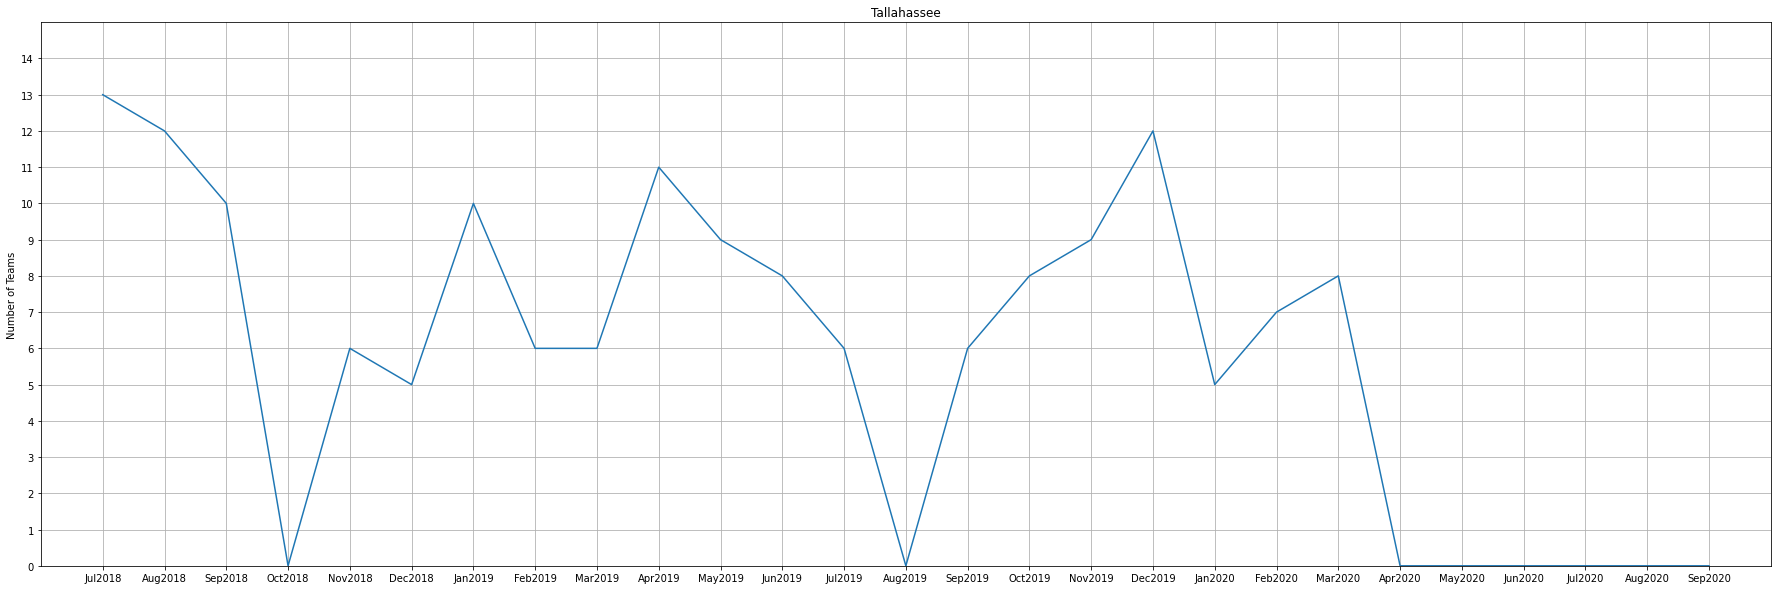

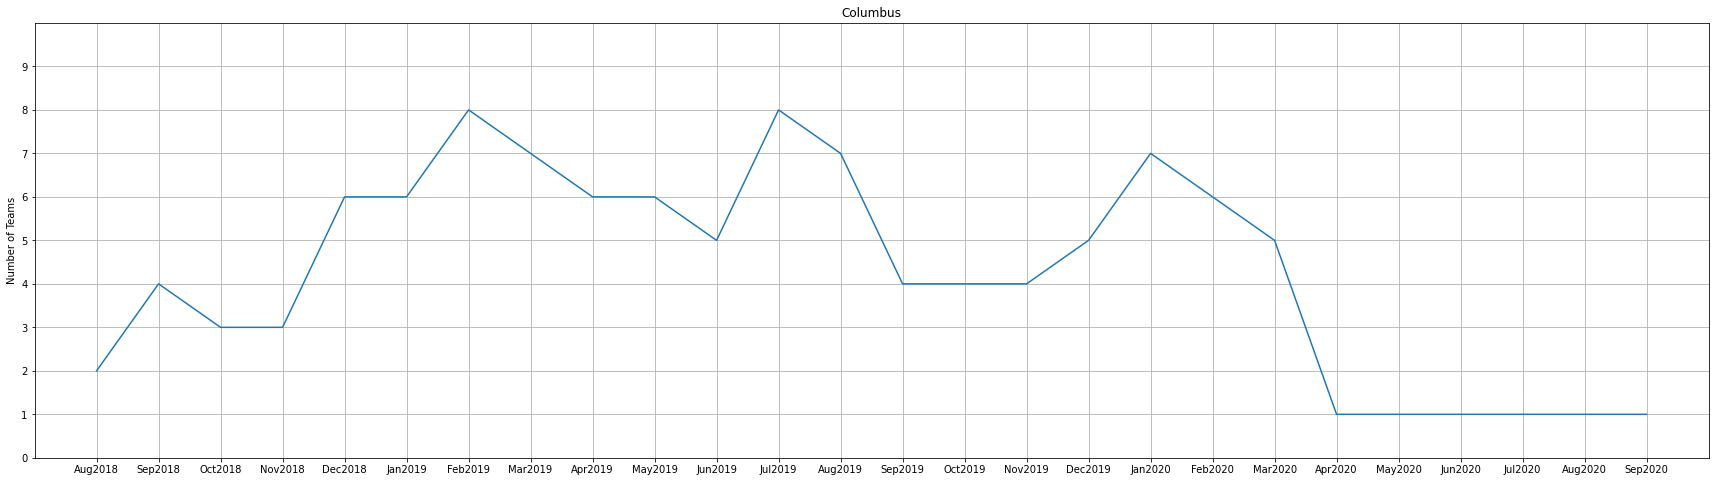

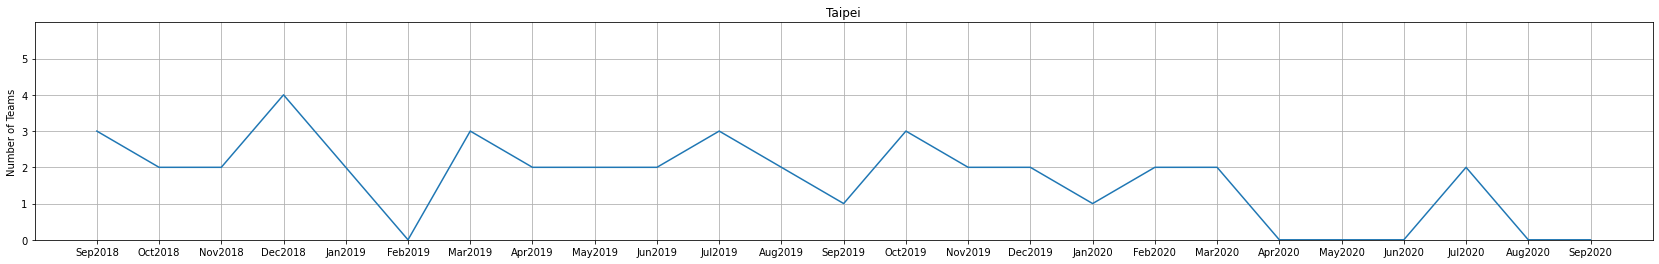

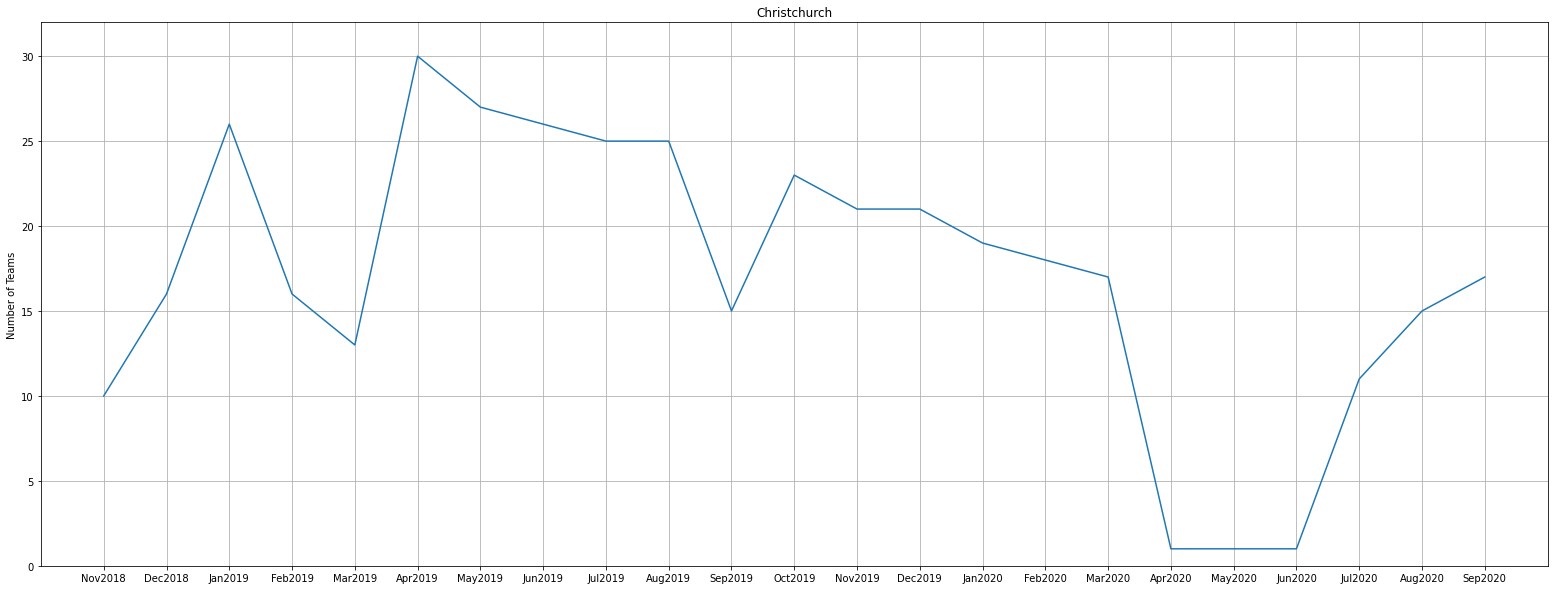

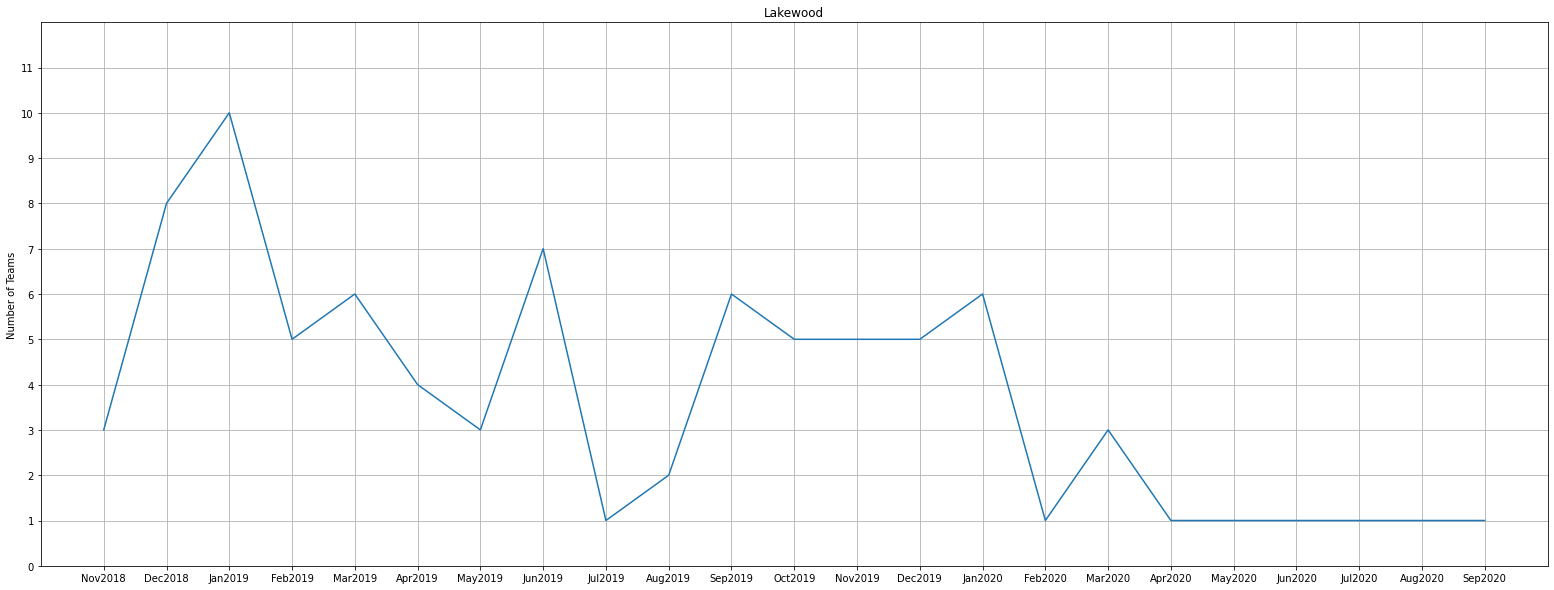

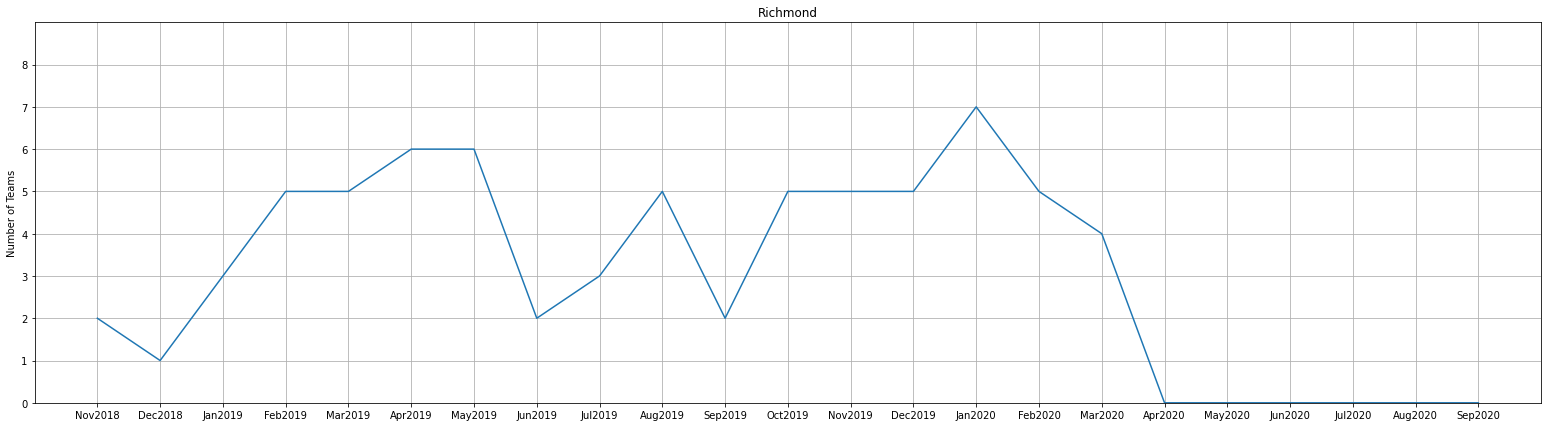

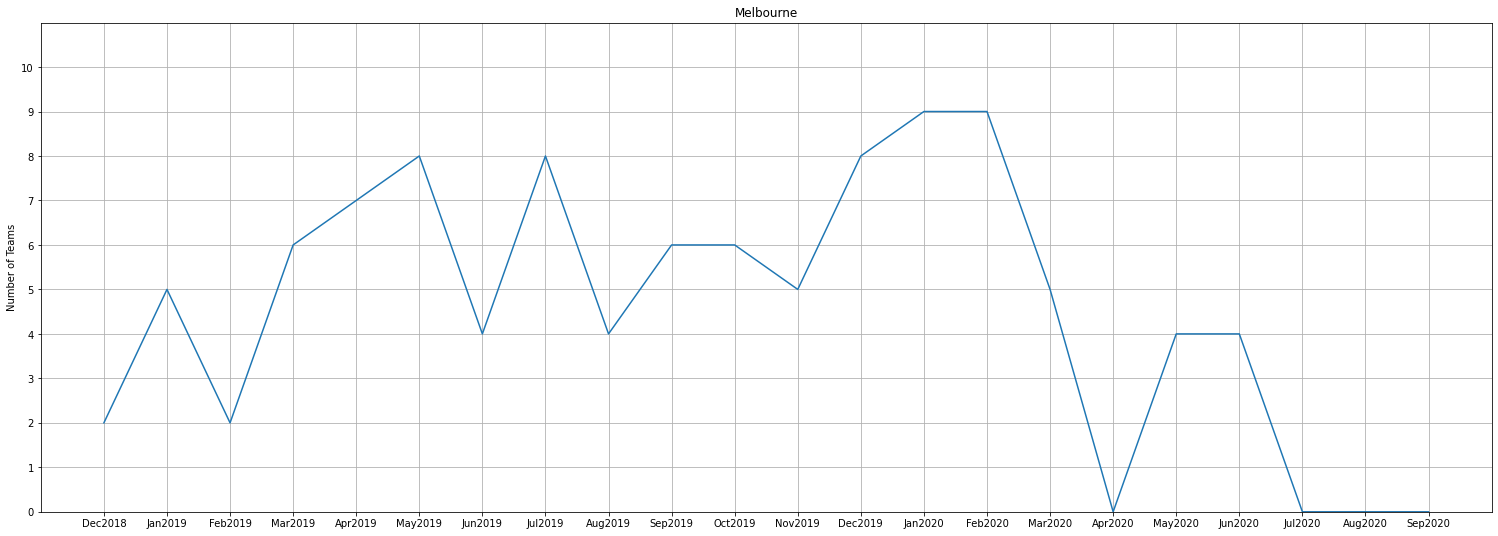

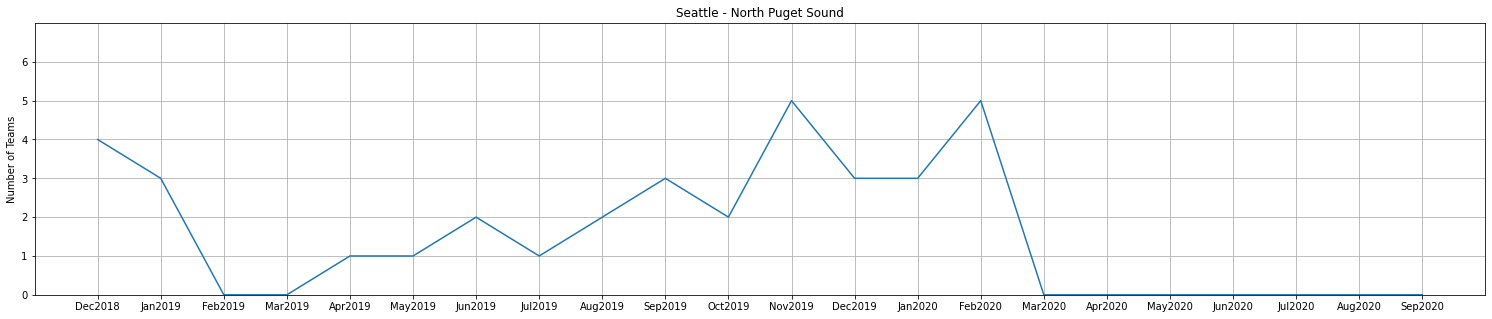

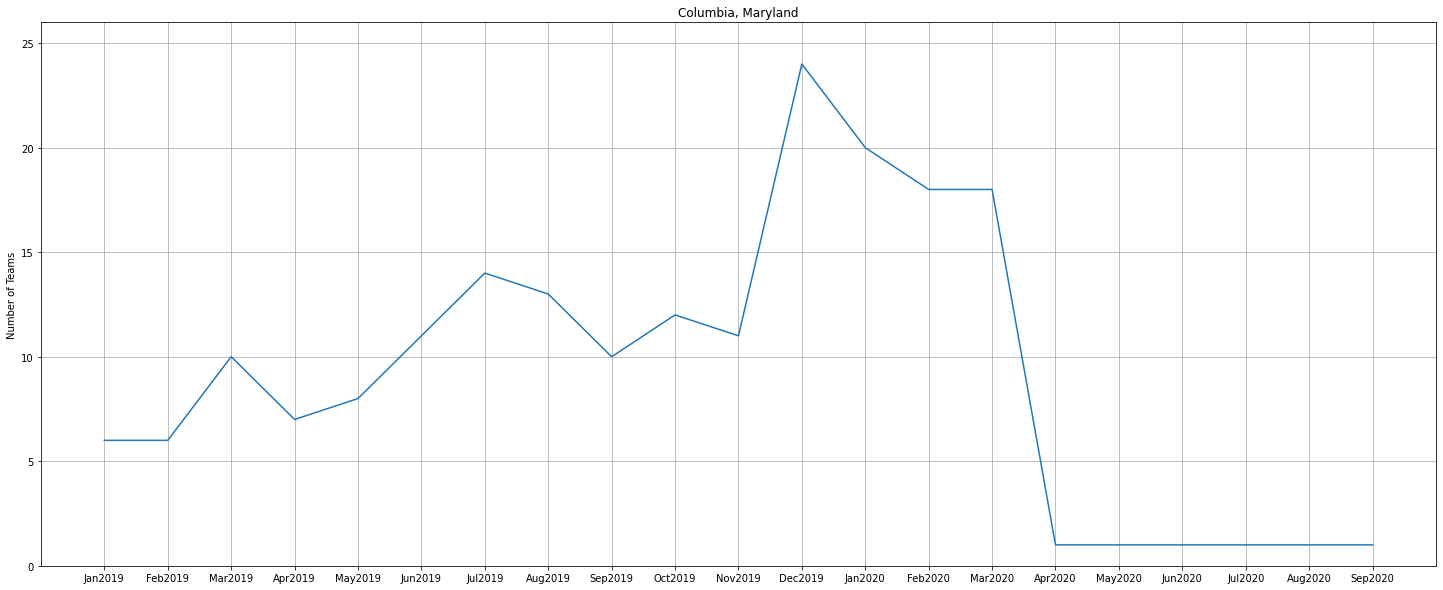

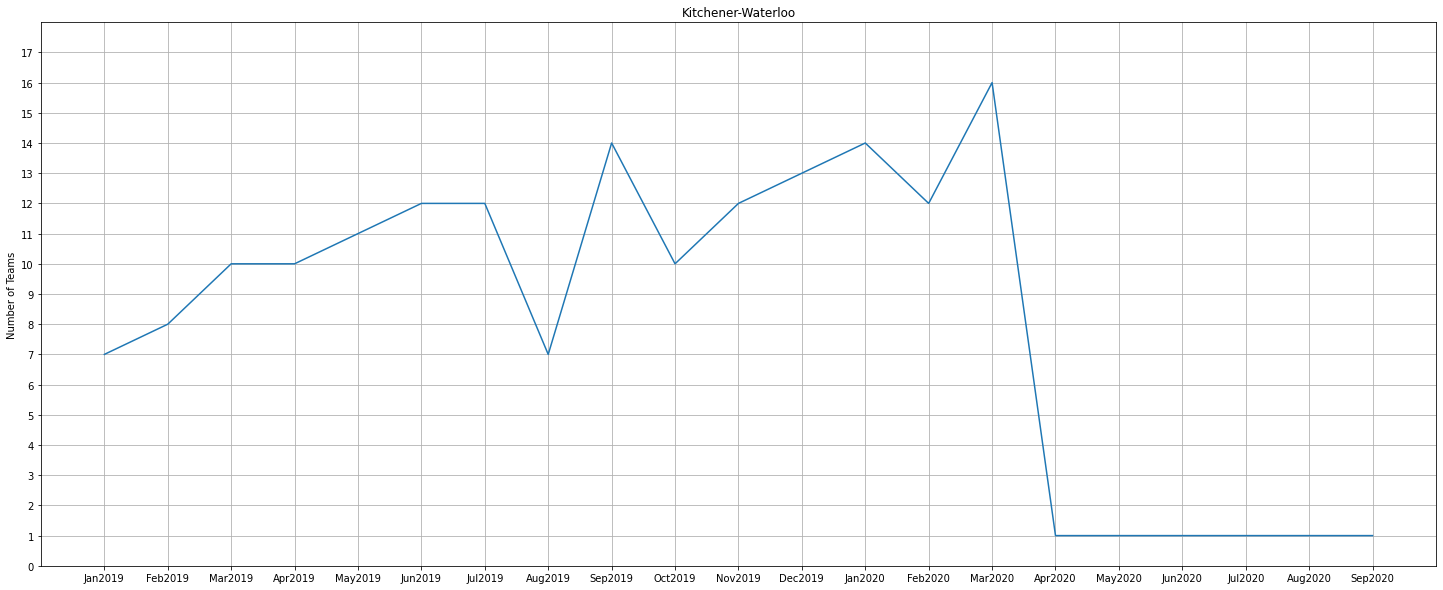

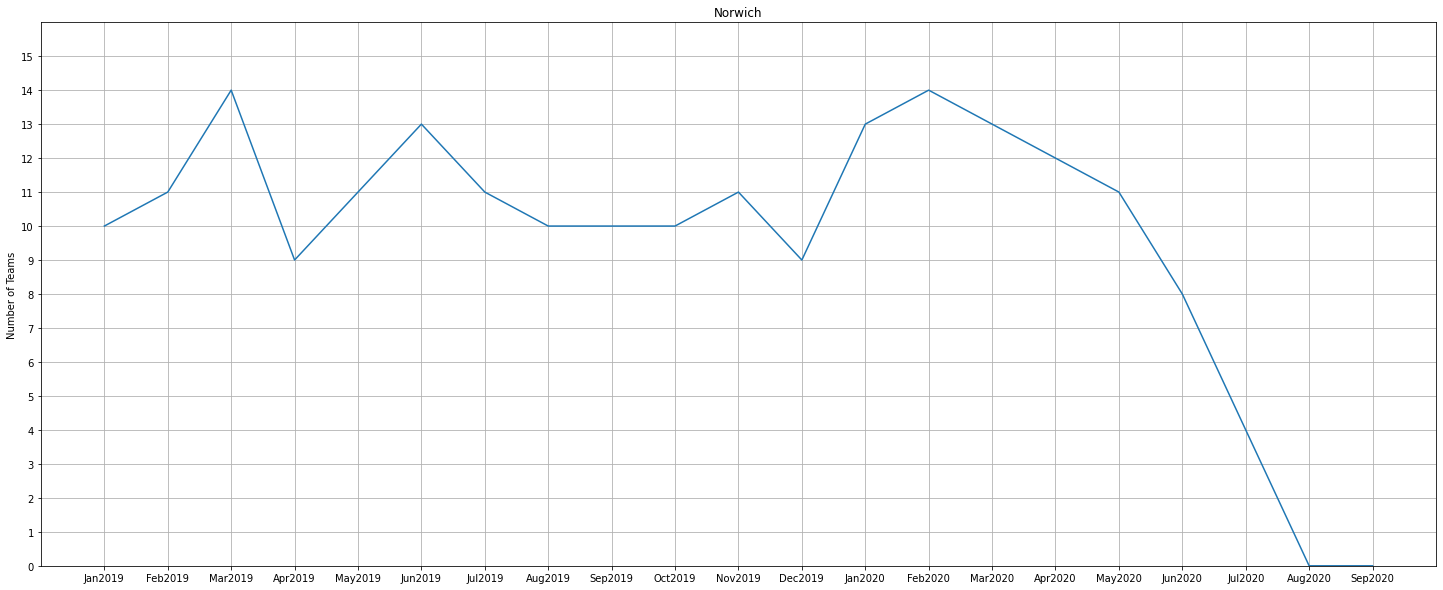

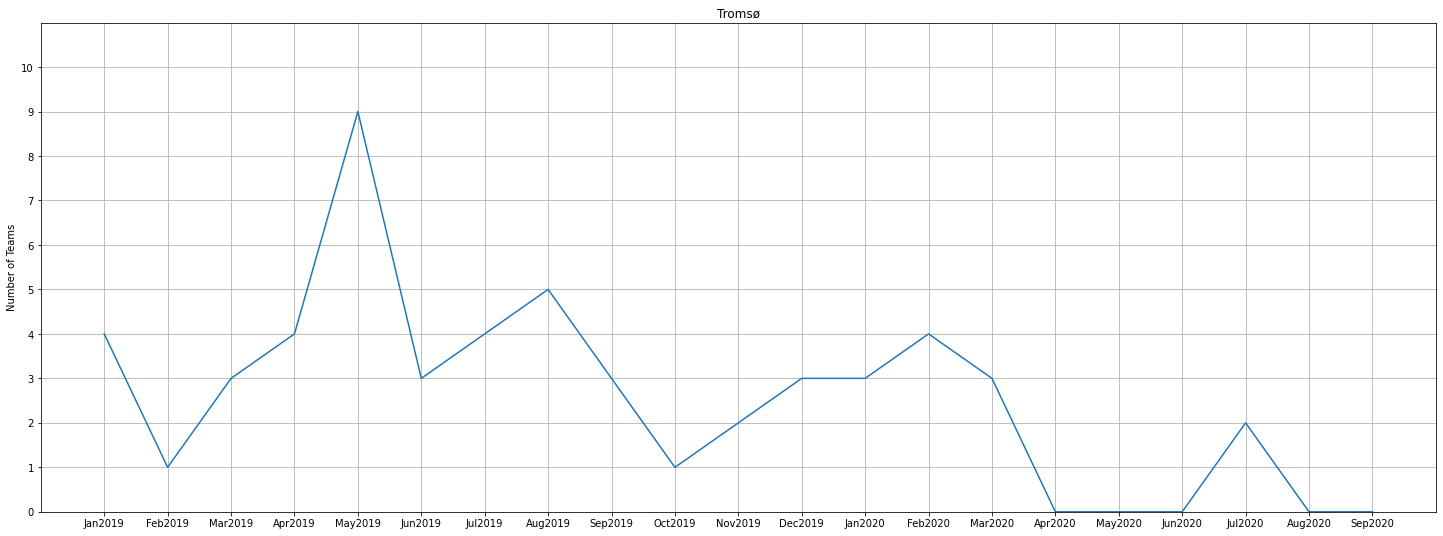

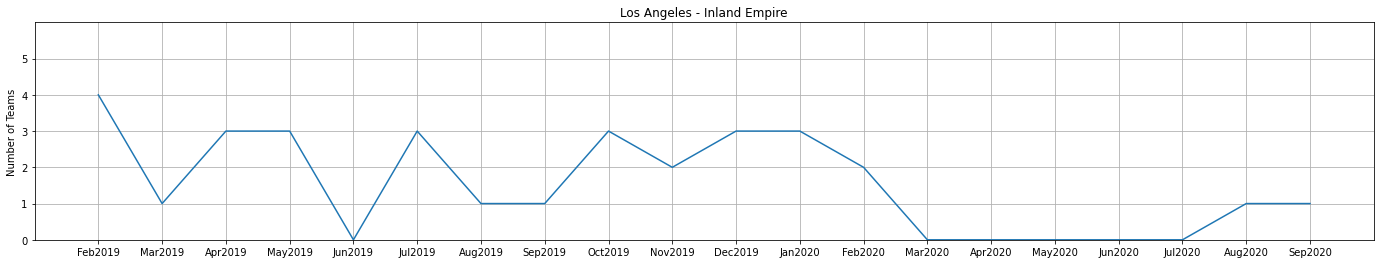

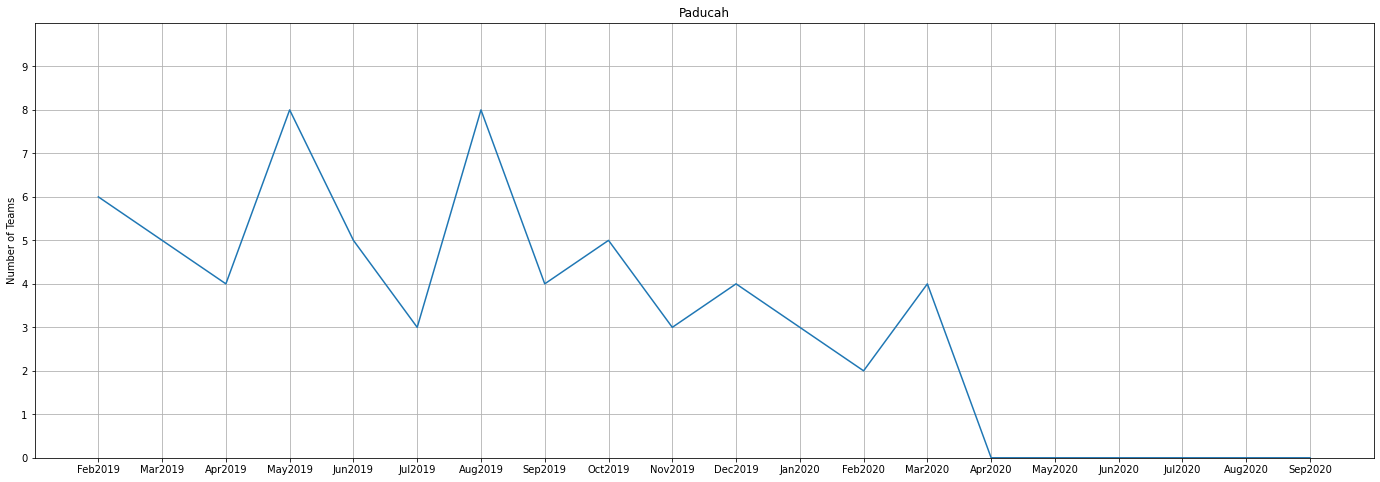

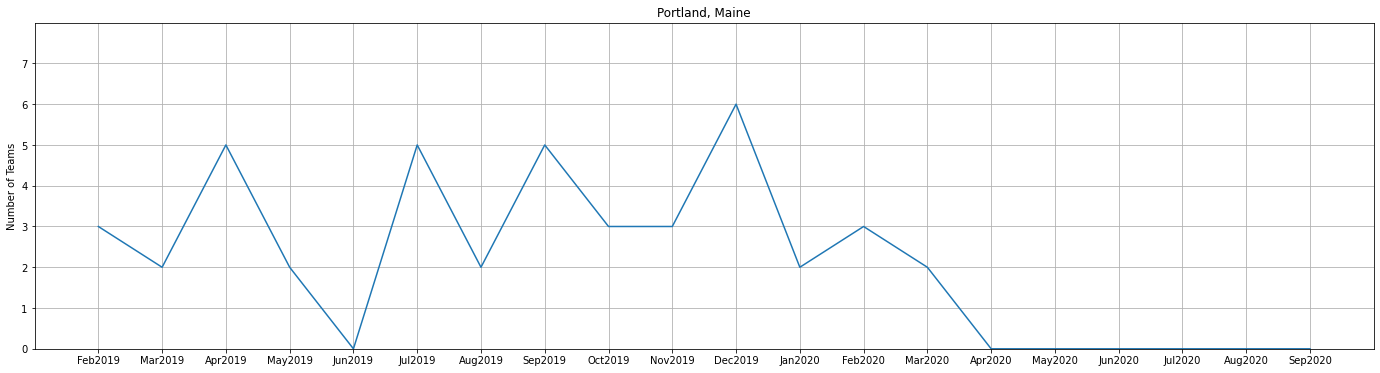

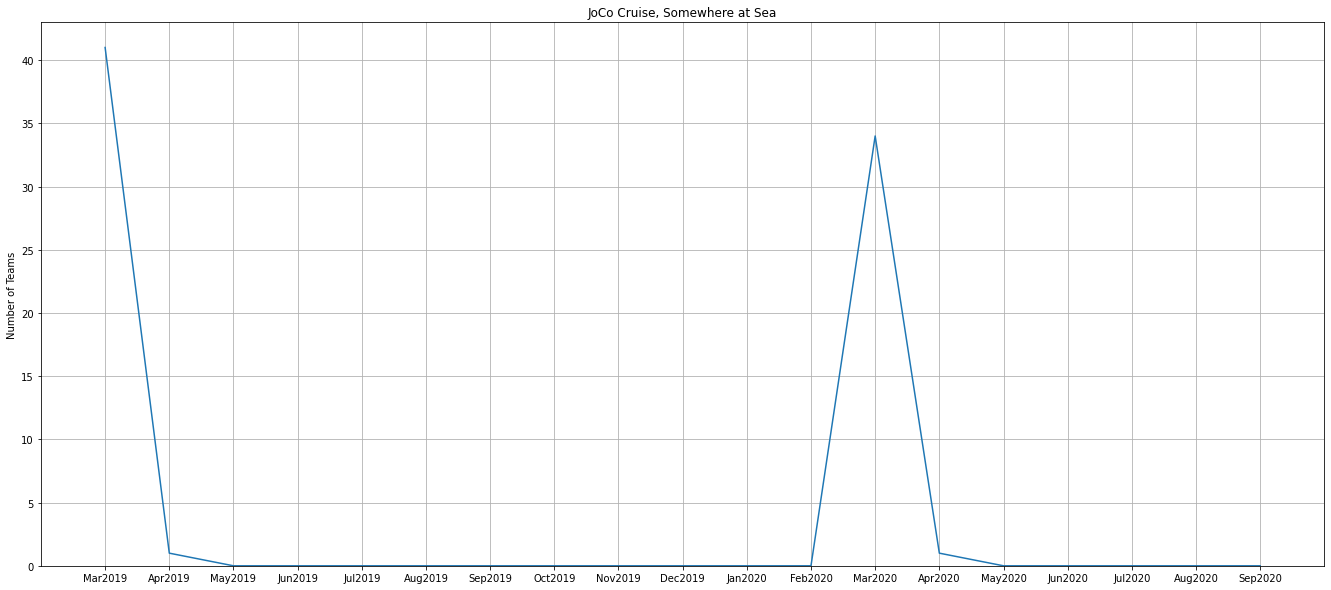

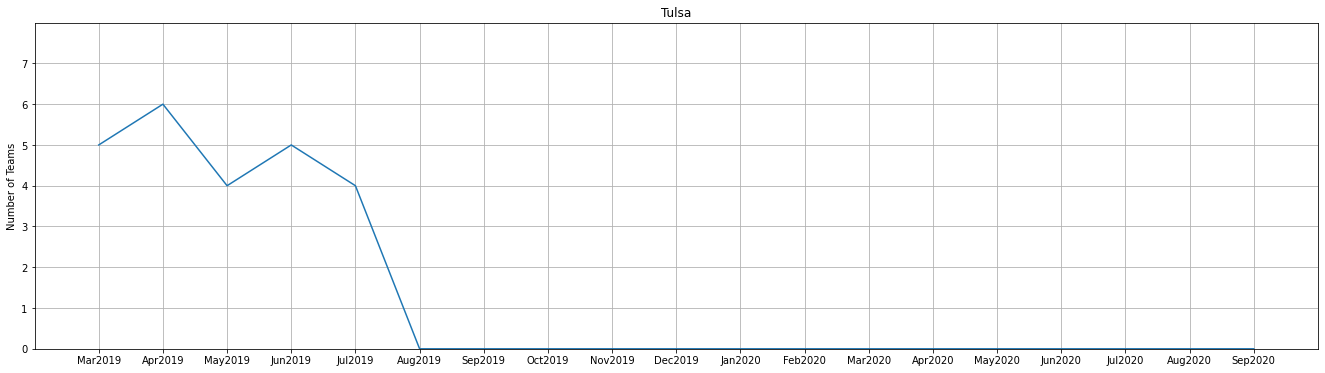

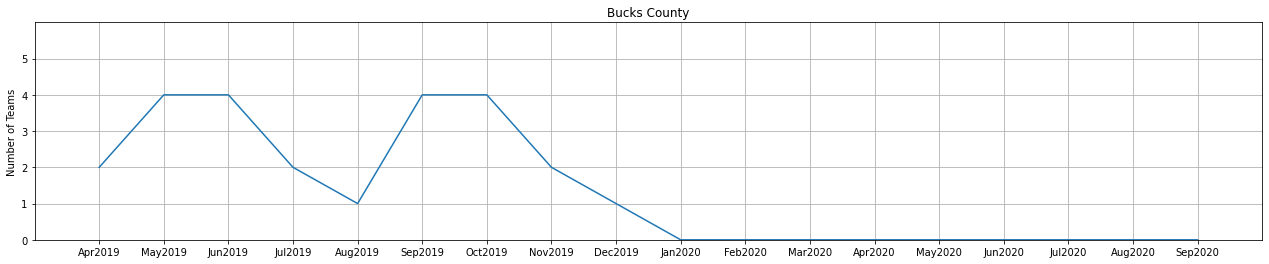

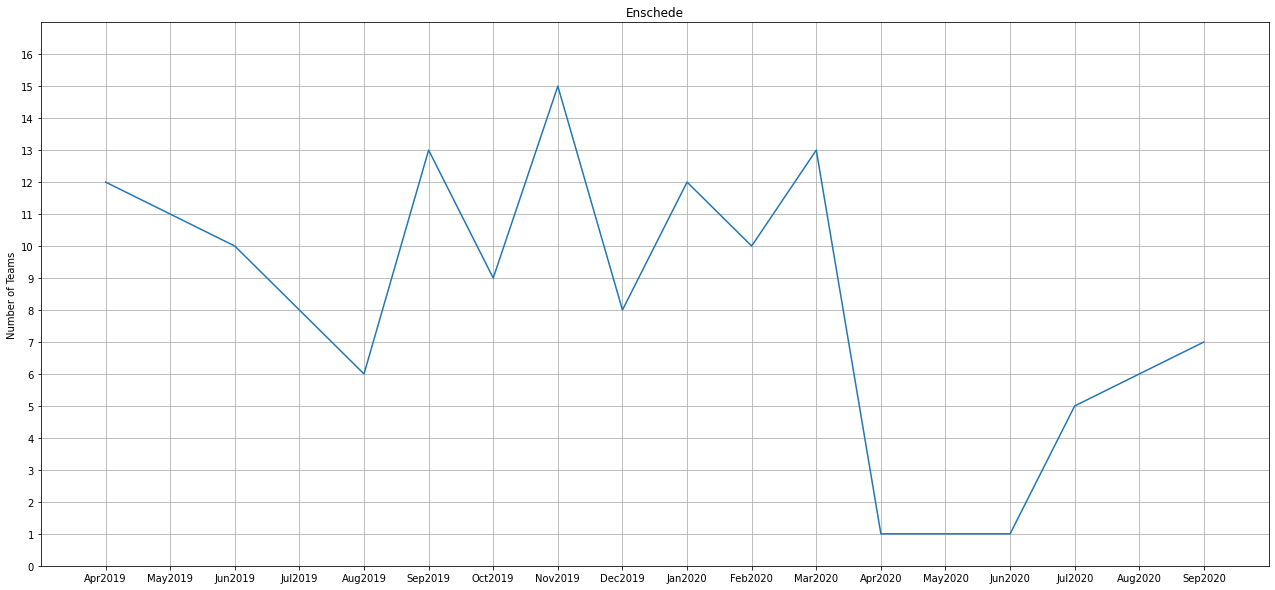

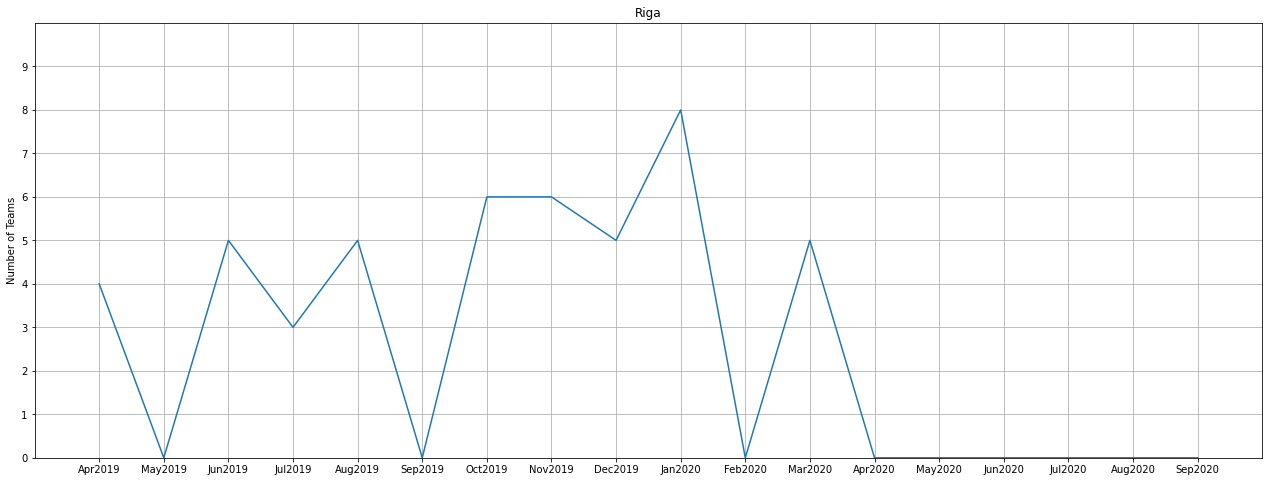

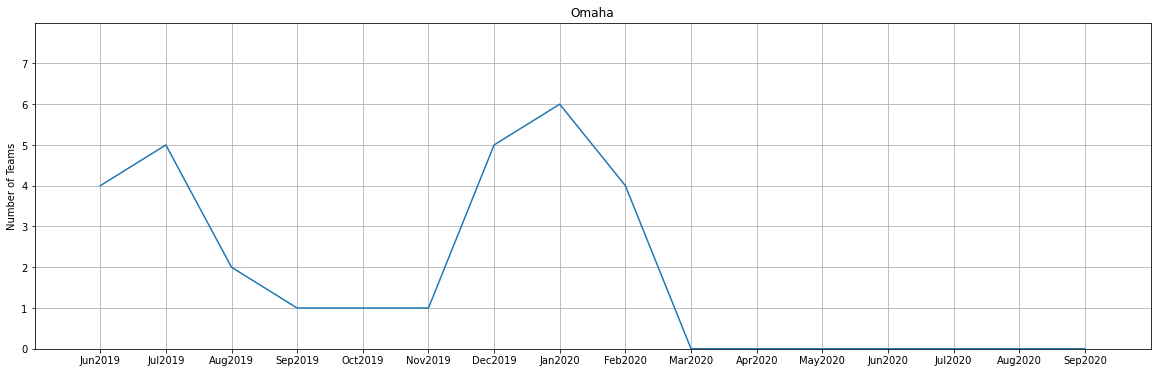

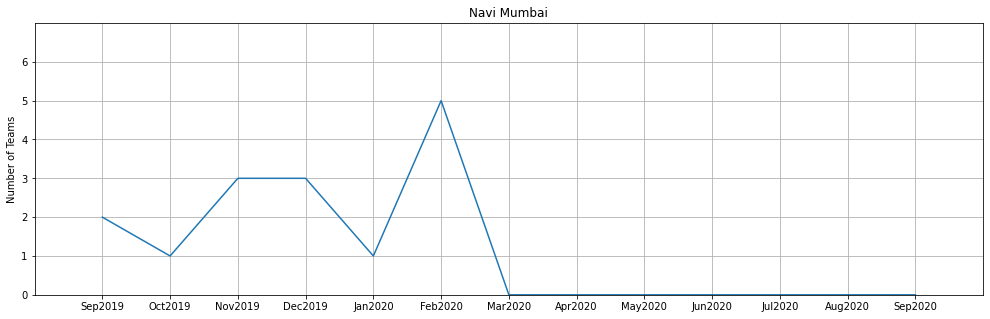

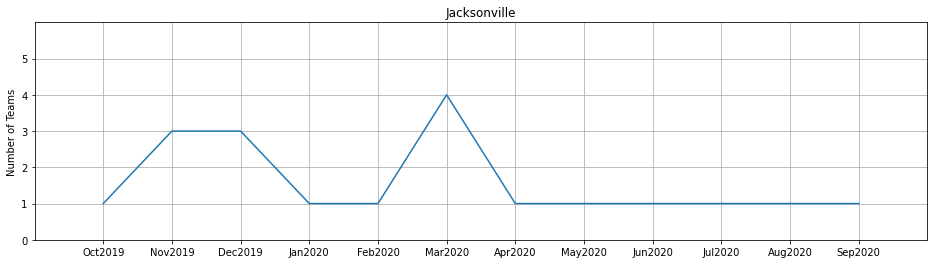

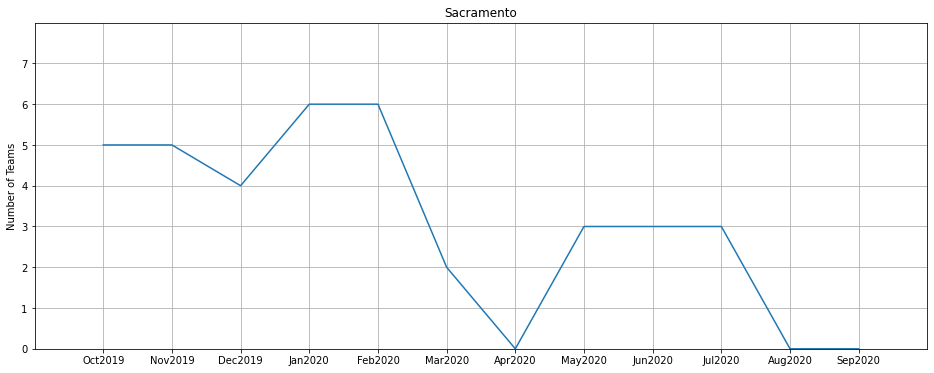

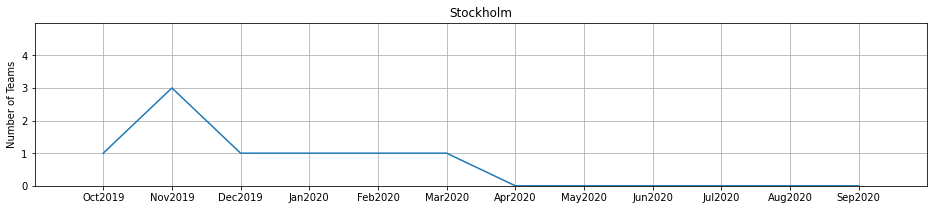

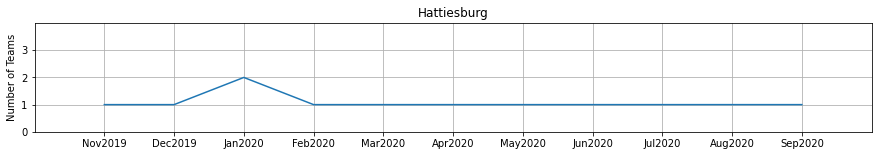

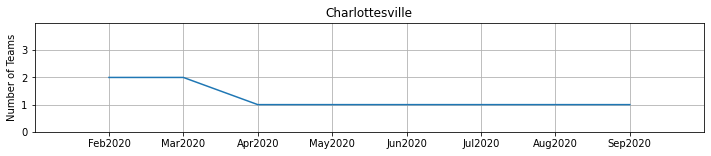

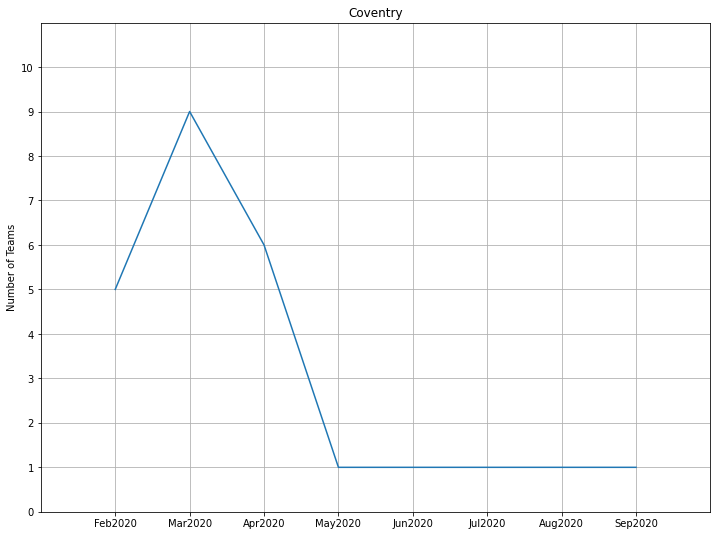

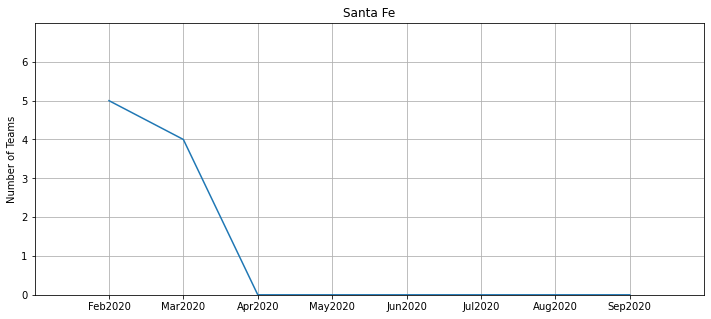

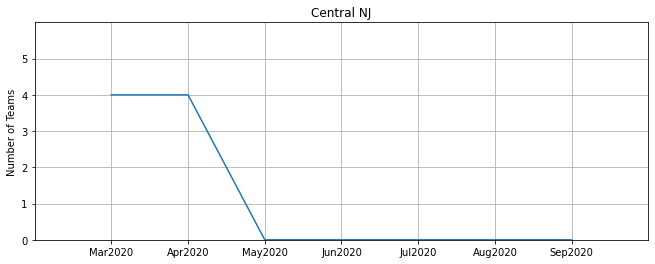

In [8]:
import os
import matplotlib.pyplot as plt
import tqdm

dir_name = 'locations'
try:
    os.mkdir(dir_name)
except FileExistsError:
    print("Directory " , dir_name ,  " already exists")

# Create a directory and plot for each location
for loc in all_loc_data:
    loc.creat_dir()
    loc.graph()
